---
**Análisis exploratorio de datos y modelo de clasificación multiclase**

---

**Autor:** Acher Bizen Egido Mairal  
**Proyecto:** TFM - *Detección de enfermedades a través de modelos de clasificación multiclase aplicados a datasets de microARNs en biopsias líquidas*  
**Universidad Internacional de Valencia (VIU)**  
**Fecha de última modificación:** XX-XX-XXXX    

---
**Uso de Inteligencia Artificial en el desarrollo del código**

---
Este cuaderno ha sido elaborado combinando **desarrollo propio** con **asistencia de herramientas de Inteligencia Artificial**, empleadas de manera responsable y transparente.  
Durante la construcción del código se utilizaron principalmente **ChatGPT (OpenAI)** y **GitHub Copilot**, y en algunos casos **Claude (Anthropic)**, con el objetivo de:
- Generar estructuras base de código (funciones, pipelines, validaciones cruzadas, visualizaciones, etc.).  
- Explorar diferentes alternativas de implementación y optimización.  
- Solicitar aclaraciones teóricas y referencias para pasos metodológicos complejos o poco conocidos.

El flujo de trabajo relacionado con la IA consistió en:
1. Formular una misma consulta a dos IAs para contrastar enfoques.  
2. Seleccionar, validar y adaptar manualmente la mejor propuesta.  
3. Verificar el funcionamiento y exactitud del código a través de pruebas y búsqueda de documentación adicional.  

De este modo, la **IA se ha utilizado como herramienta de apoyo técnico y de aprendizaje**, no como sustituto del razonamiento ni del diseño metodológico.  
Todas las decisiones finales sobre preprocesamiento, modelado y análisis fueron tomadas por el autor tras validar los resultados empíricamente.


## **Librería de imports**

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip, re
import pandas as pd
import os
import seaborn as sns
import dataframe_image as dfi
import shap



from scipy import stats
from pathlib import Path
from google.colab import drive
from collections import defaultdict, OrderedDict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import (
    f1_score, balanced_accuracy_score, make_scorer, accuracy_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_fscore_support
)
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from statsmodels.stats.multitest import multipletests
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from imblearn.pipeline import Pipeline
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from imblearn.pipeline import Pipeline as ImbPipeline

# #Instalación de UMAP
# !pip install -q umap-learn
# from umap import UMAP

# #Instalación de ComBat
# !pip -q install neurocombat==0.2.12
# try:
#     from neuroCombat import neuroCombat
# except ImportError:
#     from neurocombat import neuroCombat
# import importlib, sys
# importlib.invalidate_caches()


# **Biblioteca de funciones**


In [97]:
# Guarda un resumen compacto del DataFrame para el reporte.
def snapshot_df(df, name, notes=""):
    info = {
        "name": name,
        "shape": df.shape,
        "index_name": df.index.name,
        "columns_n": len(df.columns),
        "na_cells": int(df.isna().sum().sum()),
        "rows_with_na": int(df.isna().any(axis=1).sum()),
        "cols_with_na": int(df.isna().any(axis=0).sum()),
        "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,
        "notes": notes
    }
    audit_log.append(info)
    display(pd.DataFrame([info]))

# Resumen de una serie categórica (clases, etc.).
def snapshot_value_counts(ser, name, notes=""):
    vc = ser.value_counts(dropna=False).rename("count").to_frame()
    display(pd.DataFrame({"name":[name], "notes":[notes]}))
    display(vc)

# Informa de miARNs duplicados en el índice.
def miRNA_dup_report(df, name):
    dups = df.index.duplicated(keep=False)
    n_dup = dups.sum()
    print(f"[{name}] miARNs duplicados en índice: {n_dup}")
    if n_dup:
        display(df.index[dups].to_series().value_counts().head(20))

def columns_intersection_report(cols_a, cols_b, name_a="A", name_b="B"):
    set_a, set_b = set(cols_a), set(cols_b)
    inter = set_a & set_b
    only_a = set_a - set_b
    only_b = set_b - set_a
    print(f"[{name_a}∩{name_b}] comunes: {len(inter)} | solo {name_a}: {len(only_a)} | solo {name_b}: {len(only_b)}")
    if len(only_a):
        print(f"Ejemplos solo {name_a}:", list(sorted(only_a))[:5])
    if len(only_b):
        print(f"Ejemplos solo {name_b}:", list(sorted(only_b))[:5])
    return inter, only_a, only_b

def library_size_plot(expr_df, title="Tamaño de librería por muestra"):
    libsize = expr_df.sum(axis=0)
    plt.figure()
    libsize.sort_values().plot(kind="bar")
    plt.title(title)
    plt.ylabel("Suma de cuentas (por muestra)")
    plt.xlabel("Muestras (GSM)")
    plt.tight_layout()
    plt.show()

def zero_fraction_plots(expr_df, title_prefix="Fracción de ceros"):
    frac_zero_genes = (expr_df == 0).sum(axis=1) / expr_df.shape[1]
    frac_zero_samples = (expr_df == 0).sum(axis=0) / expr_df.shape[0]

    plt.figure()
    frac_zero_genes.hist(bins=30)
    plt.title(f"{title_prefix} por miRNA")
    plt.xlabel("Fracción")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

    plt.figure()
    frac_zero_samples.hist(bins=30)
    plt.title(f"{title_prefix} por muestra")
    plt.xlabel("Fracción")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()


In [98]:
# =================================================================================================================================================
# Lee un txt/csv (posible .gz) con separador sep, usa la PRIMERA columna como índice (independientemente del nombre), y devuelve un DataFrame.
# =================================================================================================================================================
def read_firstcol_as_index(path, sep="\t"):
    df = pd.read_csv(path, sep=sep, header=0)
    df = df.set_index(df.columns[0])
    return df

# ============================================
# Homogeneiza nombres de miARN en el índice:
#    - a minúsculas
#    - elimina prefijo 'hsa-' si aparece
#    - recorta espacios
#    Devuelve df con índice normalizado.
# ===========================================
def normalize_mirna_index(df):
    new_idx = (
        df.index.astype(str)
          .str.strip()
          .str.lower()
          .str.replace(r'^hsa-', '', regex=True)
    )
    df = df.copy()
    df.index = new_idx
    return df

# =====================================================
# Pasa de (miRNA x muestras) a (muestras x miRNA).
# =====================================================
def to_samples_x_features(expr_df):
    return expr_df.T.copy()


audit_log = []

# **Creación del dataset**

## **Construcción del dataset**

In [130]:
# =============================
# Montaje de Google Drive
# =============================
drive.mount('/content/drive')

# Rutas de trabajo del Drive
base_path_pancreatic = "/content/drive/MyDrive/Máster BigData y ciencia de datos VIU/TFM/Datos/Pancreatic cancer"
base_path_mRCC = "/content/drive/MyDrive/Máster BigData y ciencia de datos VIU/TFM/Datos/Metastatic renal cell carcinoma (mRCC)"
base_path_breast = "/content/drive/MyDrive/Máster BigData y ciencia de datos VIU/TFM/Datos/Breast cancer"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **Preparación del dataset de cáncer de páncreas**

In [131]:
# =============================
# Páncreas: expresión (xlsx)
# =============================
base_path = base_path_pancreatic
expr_file = f"{base_path}/GSE304572_processed_data.xlsx"

# La hoja "counts" tiene miARN en filas y muestras en columnas
expr_df = pd.read_excel(expr_file, sheet_name="counts")

# Voy a utilizar la primera columna como índice
expr_df = expr_df.set_index(expr_df.columns[0])


In [132]:
# ==================================================
# Páncreas: metadatos (soft.gz) -> DataFrame
# ==================================================
meta_file = f"{base_path}/GSE304572_family.soft.gz"

records = []
cur = {"gsm": None, "title": [], "chars": [], "desc": []}

# Función para 'cerrar' un bloque de muestra
def flush_block_pancreas(cur, records):
    if not cur["gsm"]:
        return
    text_full = " ".join(cur["title"] + cur["chars"] + cur["desc"])
    text_l = text_full.lower()

    # Las palabras clave por las que voy a clasificar son:
    #       pdac o pancreatic cancer            = PancreasCancerMaligno
    #       ipmn                                = PancreasCancerBenigno
    #       chronic pancreatitis o pancreatitis = PancreasCancerBenigno
    label = None
    if ("pdac" in text_l) or ("pancreatic cancer" in text_l) or re.search(r"\bcancer\b", text_l):
        label = "PancreasCancerMaligno"
    elif "ipmn" in text_l or "chronic pancreatitis" in text_l or re.search(r"\bpancreatitis\b", text_l):
        label = "PancreasCancerBenigno"

    # Intenta extraer un "core" tipo Patient: XXX o Library name: XXX
    code = None
    m1 = re.search(r"Patient:\s*([A-Za-z0-9_+\-]+)", text_full, flags=re.I)
    if m1: code = m1.group(1)
    m2 = re.search(r"Library name:\s*([A-Za-z0-9_+\-]+)", text_full, flags=re.I)
    if not code and m2: code = m2.group(1)
    core = code.split("-", 1)[0] if code else None

    # Me guardo los registros encontrados
    records.append({
        "GSM": cur["gsm"],
        "label": label,
        "patient_code": code,
        "patient_core": core
    })

with gzip.open(meta_file, "rt") as fh:
    for raw in fh:
        line = raw.strip()
        if line.startswith("^SAMPLE ="):
            flush_block_pancreas(cur, records)
            cur = {"gsm": line.split("= ")[1], "title": [], "chars": [], "desc": []}
        elif line.startswith("!Sample_title"):
            cur["title"].append(line.split("=", 1)[1].strip())
        elif line.startswith("!Sample_characteristics_ch1"):
            cur["chars"].append(line.split("=", 1)[1].strip())
        elif line.startswith("!Sample_description") or line.startswith("!Sample_data_processing"):
            cur["desc"].append(line.split("=", 1)[1].strip())
flush_block_pancreas(cur, records)

meta_pancreas = pd.DataFrame.from_records(records)


In [133]:
# =============================
# Páncreas: preparar X,y
# =============================

# Normaliza los nombres de miARN
#   - Pasa todo a minúsculas.
#   - Eliminar los prefijos 'hsa-' si aparecen.
#   - Recorta los espacios.
expr_pancreas = normalize_mirna_index(expr_df)

# Vector de etiquetas (voy a utilizar 'patient_core' como columna)
expr_cols = expr_pancreas.columns.tolist()
code2label = dict(zip(meta_pancreas["patient_core"], meta_pancreas["label"]))

# Construcción X (muestras x miRNA) e y (etiquetas finas del estudio de páncreas)
X_pancreas = to_samples_x_features(expr_pancreas)
y_pancreas = [code2label.get(c, None) for c in X_pancreas.index]


In [134]:
# ==================================================
# Páncreas: Preparación de los metadatos mínimos
# ==================================================
meta_pancreas_min = pd.DataFrame({
    "sample_id": X_pancreas.index.astype(str),   # Uso el índice de X_pancreas
    "label": y_pancreas,
    "dataset": "GSE304572",
    "matrix_type": "plasma_total"
})

#### **Preparación del cáncer renal**

In [135]:
# ===============================
# Renal (mRCC): expresión (xlsx)
# ===============================
expr_renal_path = f"{base_path_mRCC}/GSE93175_miRNA_322selected_RC8_log2.txt.gz"

expr_renal = pd.read_csv(
    expr_renal_path,
    sep="\t",
    header=1,
    index_col=0
)

# Elimino de las columnas no numéricas
non_numeric_cols = [c for c in expr_renal.columns if not pd.api.types.is_numeric_dtype(expr_renal[c])]
if non_numeric_cols:
    print("Descartando columnas no numéricas:", non_numeric_cols)
    expr_renal = expr_renal.drop(columns=non_numeric_cols)

# Compruebo que todo es numérico y no hay NaNs
expr_renal = expr_renal.apply(pd.to_numeric, errors="coerce").fillna(0)

Descartando columnas no numéricas: ['5033']


In [136]:
# =======================================================
# Renal (mRCC): normalización de nombres y transponer
# =======================================================
expr_renal = normalize_mirna_index(expr_renal)

# (muestras x miRNA)
X_renal = expr_renal.T.copy()

# Etiquetas (solo hay una clase en este caso --> Renal_mRCC)
y_renal = ["Renal_mRCC"] * X_renal.shape[0]


In [137]:
# =================================
# Renal (mRCC): metadatos mínimos
# =================================
meta_renal = pd.DataFrame({
    "sample_id": X_renal.index,
    "label": y_renal,
    "dataset": "GSE93175",
    "matrix_type": "plasma_exosome"
})


#### **Preparación cáncer de mama**

In [138]:
# =============================
# Carga de la matriz TPM
# =============================

expr_breast_path = f"{base_path_breast}/GSE270497_All.TPM.exp.txt.gz"

expr_breast_raw = pd.read_csv(
    expr_breast_path,
    sep="\t",
    index_col=0,
    low_memory=False
)

# Filtrar solo miRNA
idx = expr_breast_raw.index.astype(str).str.lower()
is_mirna = idx.str.startswith("hsa-mir") | idx.str.startswith("hsa-let")
expr_breast_miR = expr_breast_raw.loc[is_mirna].copy()

# Eliminar columnas no expresión si existen
non_expr_cols = ["smallRNApreName", "smallRNASequence"]
expr_breast_miR = expr_breast_miR.drop(columns=non_expr_cols, errors="ignore")

Como en este dataset hay miARN que no son microARN, voy a filtrarlos y quedarme sólo con los ARNs de este tipo, para eso voy a buscar las entradas que empiecen por **hsa-mir** o **hsa-let**

In [139]:
# =============================
# Normalizar nombres de miRNA
# =============================
def normalize_mirna_index(df):
    new_idx = (
        df.index.astype(str)
          .str.strip()
          .str.lower()
          .str.replace(r'^hsa-', '', regex=True)
    )
    df = df.copy()
    df.index = new_idx
    return df

expr_breast_miR = normalize_mirna_index(expr_breast_miR)

# Colapso los duplicados duplicados por media (no hay en verdad)
if expr_breast_miR.index.duplicated().sum() > 0:
    expr_breast_miR = expr_breast_miR.groupby(expr_breast_miR.index).mean()

In [140]:
# =================================
# Transponer a (muestras x miRNA)
# =================================
X_breast = expr_breast_miR.T.copy()
X_breast.index.name = "sample_id"

In [141]:
# ===================================================
# Parseao de SOFT y extracción de etiquetas
# ===================================================


soft_path = f"{base_path_breast}/GSE270497_family.soft.gz"

records = []
cur = {"gsm": None, "title": [], "chars": [], "desc": []}

def flush_block(cur, records):
    if not cur["gsm"]:
        return
    text_full = " ".join(cur["title"] + cur["chars"] + cur["desc"])
    text_l = text_full.lower()

    # Etiqueta binaria por presencia de 'positive'/'negative'
    subgroup = None
    if "positive" in text_l:
        subgroup = "Positive"
    elif "negative" in text_l:
        subgroup = "Negative"

    # Extraer el código tipo BCE### desde title/desc (clave para enlazar con columnas de expresión)
    m = re.search(r"\b(BCE\d{2,4})\b", text_full, flags=re.I)
    bce_code = m.group(1).upper() if m else None

    records.append({
        "GSM": cur["gsm"],
        "bce_code": bce_code,     # <- puente hacia X_breast.index
        "subgroup": subgroup,
        "title": " | ".join(cur["title"]) if cur["title"] else None
    })

with gzip.open(soft_path, "rt") as fh:
    for raw in fh:
        line = raw.strip()
        if line.startswith("^SAMPLE ="):
            flush_block(cur, records)
            cur = {"gsm": line.split("= ")[1], "title": [], "chars": [], "desc": []}
        elif line.startswith("!Sample_title"):
            cur["title"].append(line.split("=", 1)[1].strip())
        elif line.startswith("!Sample_characteristics_ch1"):
            cur["chars"].append(line.split("=", 1)[1].strip())
        elif line.startswith("!Sample_description") or line.startswith("!Sample_data_processing"):
            cur["desc"].append(line.split("=", 1)[1].strip())
flush_block(cur, records)

meta_soft = pd.DataFrame.from_records(records)

In [142]:
# =============================================
# Enlazar metadatos con X_breast por BCE###
# =============================================
X_breast.index = X_breast.index.astype(str).str.upper()
meta_soft["bce_code"] = meta_soft["bce_code"].astype(str).str.upper()

# Me quedo con filas que sí tienen BCE y etiqueta
meta_linkable = meta_soft.dropna(subset=["bce_code", "subgroup"]).copy()

# Si hubiese múltiples GSM con el mismo BCE, resolvemos por mayoría (o el primero)
code2label = (meta_linkable
              .groupby("bce_code")["subgroup"]
              .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0])
              .to_dict())

# Chequeo de cobertura
expr_ids = pd.Index(X_breast.index.astype(str).str.upper())   # BCE### en expresión
missing_in_meta = expr_ids.difference(pd.Index(list(code2label.keys())))
print(f"Columnas (muestras) sin etiqueta en metadatos: {len(missing_in_meta)}")

# =================================================
# Construcción y filtrado de X,y etiquetados
# =================================================
# y vector alineado al índice de X_breast
y_breast = pd.Series([code2label.get(s, None) for s in expr_ids], index=X_breast.index, name="label")

# Filtro las muestras con etiqueta conocida
mask_labeled = y_breast.notna()
X_breast_labeled = X_breast.loc[mask_labeled].copy()
y_breast_labeled = y_breast.loc[mask_labeled].copy()

# Partiendo de X_breast_labeled y y_breast_labeled
meta_breast = pd.DataFrame({
    "sample_id": X_breast_labeled.index,
    "label": y_breast_labeled.values,
    "dataset": "Breast"
}).set_index("sample_id")


Columnas (muestras) sin etiqueta en metadatos: 0


**Resumen de bloque:**

1. **Carga y limpieza de tres datasets independientes** de expresión de miARNs en plasma/plasma-exosomas:
    - Cáncer de páncreas (GSE304572).
    - Cáncer renal metastásico (mRCC) (GSE93175).
    - Cáncer de mama (GSE270497).

2. **Normalización y preprocesamiento de matrices de expresión**:
    - Filtrado de solo miARNs (descartando piRNA, tsRNA u otros).
    - Nombres iguales de miARNs con normalize_mirna_index.
    - Eliminación de columnas no relacionadas con la expresión.

3. **Eliminación de duplicados si hay**.

4. **Transformación de todas las matrices al formato estándar: muestras × miARNs**.

5. **Construcción de metadatos mínimos para cada dataset**: Para cada muestra, hay:
    - sample_id, label (clase), dataset (GSE...), matrix_type.
    - En el de cáncer de mama también existe una columna opcional *subgroup* (Positive/Negative si aparece en el ID).


Ahora todos los datos tienen un formato homogéneo, listo para unirlos o analizarlos por separado en clasificación multiclase.

## **Preprocesamiento**

### **Preprocesado Cáncer pancreatico**

In [143]:
# =========================================
# Filtrado de baja abundancia (Pancreas)
# =========================================
PRESENCE_THRESHOLD = 3       # conteos >=3 lo considero "presencia"
MIN_PREV_GLOBAL = 0.20       # ≥20% de muestras
MIN_PREV_PER_CLASS = 0.20    # ≥20% dentro de al menos una clase (PDAC o Benigno)

expr_counts_pancreas = expr_df.copy()     # miRNA x muestras (counts)
meta_pancreas = meta_pancreas_min.copy()
meta_pancreas = meta_pancreas.loc[meta_pancreas['sample_id'].isin(expr_counts_pancreas.columns)].copy()

# Reordeno las columnas de expr_counts_pancreas para que coincidan con meta
expr_counts_pancreas = expr_counts_pancreas.loc[:, meta_pancreas['sample_id'].tolist()]

# Etiquetas por muestra
labels_pancreas = pd.Series(meta_pancreas['label'].values,
                            index=meta_pancreas['sample_id'].values,
                            name='label')

# Matriz booleana de presencia
presence_pancreas = (expr_counts_pancreas >= PRESENCE_THRESHOLD)

# Prevalencia global
prev_global_pancreas = presence_pancreas.sum(axis=1) / presence_pancreas.shape[1]

# Prevalencia por clase
classes = labels_pancreas.unique()
prev_by_class_pancreas = {}
for cls in classes:
    cols_cls = labels_pancreas.index[labels_pancreas == cls]
    if len(cols_cls) == 0:
        continue
    prev_by_class_pancreas[cls] = presence_pancreas[cols_cls].sum(axis=1) / len(cols_cls)

# Máscara final de retención
mask_keep_pancreas = prev_global_pancreas >= MIN_PREV_GLOBAL
for cls, prev_s in prev_by_class_pancreas.items():
    mask_keep_pancreas = mask_keep_pancreas | (prev_s >= MIN_PREV_PER_CLASS)

expr_counts_filt_pancreas = expr_counts_pancreas.loc[mask_keep_pancreas].copy()

print(f"[Filtrado · Pancreas] miRNA totales: {expr_counts_pancreas.shape[0]}  → retenidos: {expr_counts_filt_pancreas.shape[0]} "
      f"(umbral presencia ≥{PRESENCE_THRESHOLD}, prevalencia ≥{int(MIN_PREV_GLOBAL*100)}% global "
      f"o ≥{int(MIN_PREV_PER_CLASS*100)}% en alguna clase)")


[Filtrado · Pancreas] miRNA totales: 2369  → retenidos: 230 (umbral presencia ≥3, prevalencia ≥20% global o ≥20% en alguna clase)


In [144]:
# ===========================================
# Normalización (CPM/RPM + log2) · Pancreas
# ===========================================

# CPM/RPM por muestra
lib_sizes_pancreas = expr_counts_filt_pancreas.sum(axis=0)  # suma por muestra
lib_sizes_pancreas = lib_sizes_pancreas.replace(0, np.nan)  # evito la división por cero

expr_cpm_pancreas = expr_counts_filt_pancreas.divide(lib_sizes_pancreas, axis=1) * 1e6

# log2(CPM + 1)
expr_logcpm_pancreas = np.log2(expr_cpm_pancreas + 1.0)

# Versiones principales
X_logcpm_features_by_samples_pancreas = expr_logcpm_pancreas.copy()   # miRNA x muestras
X_logcpm_samples_by_features_pancreas = expr_logcpm_pancreas.T        # muestras x miRNA

print("[Normalización · Pancreas] Escala log2(CPM+1):")
print(" - Matriz (miRNA x muestras):", X_logcpm_features_by_samples_pancreas.shape)
print(" - Matriz (muestras x miRNA):", X_logcpm_samples_by_features_pancreas.shape)


[Normalización · Pancreas] Escala log2(CPM+1):
 - Matriz (miRNA x muestras): (230, 85)
 - Matriz (muestras x miRNA): (85, 230)


### **Preprocesado cáncer renal**

In [145]:
# ==========================================
# Preprocesado mínimo · mRCC (GSE93175)
# - Se mantiene la escala log2 original
# - Se eliminan los miRNAs de varianza cero
# - Se crea una versión z-score para exploración y fusión entre datasets
# ==========================================

# Comprobación ligera de valores NA --> (No hay ya lo he comprobado antes, pero por si acaso)
if X_renal.isna().any().any():
    print("Aviso: se han encontrado NA en X_renal; se reemplazan por 0 para continuar.")
    X_renal = X_renal.fillna(0)

# Elimino los miRNAs constantes (varianza = 0)
var_renal = X_renal.var(axis=0, ddof=0)
mask_nonconst = var_renal > 0
dropped_const = int((~mask_nonconst).sum())
if dropped_const > 0:
    print(f"Eliminando {dropped_const} miRNAs constantes (sin variación entre muestras).")

X_renal_log = X_renal.loc[:, mask_nonconst].copy()  # seguimos en log2
print("X_renal_log (tras quitar constantes):", X_renal_log.shape)

# z-score por miRNA (Usado luego en PCA/UMAP y para fusionar con los otros datasets)
def zscore_by_feature(df_mxf: pd.DataFrame) -> pd.DataFrame:
    mu = df_mxf.mean(axis=0)
    sd = df_mxf.std(axis=0, ddof=0).replace(0, np.nan)
    z = (df_mxf - mu) / sd
    return z.fillna(0.0)

X_renal_z = zscore_by_feature(X_renal_log)


X_renal_log (tras quitar constantes): (42, 322)


### **Preprocesado Cáncer de mama**

In [146]:
# ==========================================
# Filtrado de baja abundancia (Breast · TPM)
# ==========================================

PRESENCE_TPM = 1.0           # TPM ≥ 1 se considera "presencia" (así evito ruido de fondo)
MIN_PREV_GLOBAL = 0.20       # ≥20% de muestras
MIN_PREV_PER_CLASS = 0.20    # ≥20% dentro de al menos una clase (Positive/Negative)

# Alineo por si acaso
Xb = X_breast_labeled.copy()
yb = y_breast_labeled.reindex(Xb.index).astype(str)

presence = (Xb.T >= PRESENCE_TPM)   # Matriz booleana de presencia, miRNA x muestra

# Prevalencia global y por clase
prev_global = presence.sum(axis=1) / presence.shape[1]

classes = yb.dropna().unique()
prev_by_class = {}
for cls in classes:
    cols_cls = yb.index[yb == cls]
    if len(cols_cls) == 0:
        continue
    prev_by_class[cls] = presence[cols_cls].sum(axis=1) / len(cols_cls)

# Máscara final (global OR alguna clase)
mask_keep = (prev_global >= MIN_PREV_GLOBAL)
for cls, prev_s in prev_by_class.items():
    mask_keep = mask_keep | (prev_s >= MIN_PREV_PER_CLASS)

# Aplico el filtrado sobre X (muestras x miRNA)
kept_mirnas = presence.index[mask_keep]
X_breast_filt = Xb.loc[:, kept_mirnas].copy()

print(
    f"[Filtrado · Breast] miRNA totales: {Xb.shape[1]} retenidos: {X_breast_filt.shape[1]} "
    f"(TPM≥{PRESENCE_TPM}, prevalencia ≥{int(MIN_PREV_GLOBAL*100)}% global "
    f"o ≥{int(MIN_PREV_PER_CLASS*100)}% en alguna clase)"
)


[Filtrado · Breast] miRNA totales: 2656 retenidos: 2448 (TPM≥1.0, prevalencia ≥20% global o ≥20% en alguna clase)


In [147]:
# ==========================================
# Normalización (log2(TPM+1)) · Breast
# ==========================================

# Transformación logarítmica
X_logtpm_breast = np.log2(X_breast_filt + 1.0)      # muestras x miRNA

# Versiones de conveniencia (mismas que en páncreas, pero con TPM)
X_logtpm_samples_by_features_breast = X_logtpm_breast.copy()     # muestras x miRNA
X_logtpm_features_by_samples_breast = X_logtpm_breast.T.copy()   # miRNA x muestras

print("[Normalización · Breast] Escala log2(TPM+1):")
print(" - Matriz (muestras x miRNA):", X_logtpm_samples_by_features_breast.shape)
print(" - Matriz (miRNA x muestras):", X_logtpm_features_by_samples_breast.shape)

[Normalización · Breast] Escala log2(TPM+1):
 - Matriz (muestras x miRNA): (180, 2448)
 - Matriz (miRNA x muestras): (2448, 180)


## **Intersección de miRNA comunes**

En este apartado se lleva a cabo la **integración de los distintos datasets de expresión de miARNs** (páncreas, renal y mama) con el objetivo de conformar una **matriz global y homogénea** que permita el análisis multiclase.

En primer lugar, se identifican los **miARNs comunes** entre los tres conjuntos de datos, garantizando así que la comparación y el aprendizaje automático se realicen únicamente sobre un espacio de características compartido. Posteriormente, se generan subconjuntos restringidos a dichos miARNs comunes para cada patología.

En el caso del cáncer de páncreas, se ha optado por **conservar tanto las muestras benignas (Pancreatitis e IPMN) como las malignas**, la idea es hacer dos grupos de cáncer de páncreas para tener más riqueza a la hora de procesarlas. (Luego ya veremos si esto nos crea muchos problemas por el desbalanceo en la clasificación y tenemos que pasar a 4 clases).

Finalmente, se procede a la **concatenación de las matrices de expresión resultantes** y de sus correspondientes metadatos mínimos, obteniendo así un único conjunto de datos (X_all y meta_all) en el que cada fila representa una muestra y cada columna un miARN común a todos los estudios. De este modo, se dispone de una estructura unificada para aplicar posteriormente modelos de clasificación multiclase.

In [148]:
# =============================
# Intersección de miRNA comunes
# =============================

mir_sets = [
    set(X_pancreas.columns),
    set(X_renal.columns),
    set(X_breast.columns)
]

common_mirnas = sorted(set.intersection(*mir_sets))
print("miRNA comunes en los 3 datasets:", len(common_mirnas))
print("Ejemplo:", common_mirnas[:10])


miRNA comunes en los 3 datasets: 261
Ejemplo: ['mir-100-5p', 'mir-106b-3p', 'mir-106b-5p', 'mir-107', 'mir-10a-3p', 'mir-10a-5p', 'mir-10b-5p', 'mir-1197', 'mir-122-5p', 'mir-1224-5p']


In [149]:
# ======================================================
# Voy a normalizar los nombres de las columnas
# ======================================================

def normalize_mirna_cols(df: pd.DataFrame) -> pd.DataFrame:
    cols = (pd.Index(df.columns.astype(str))
              .str.strip()
              .str.lower()
              .str.replace(r'^hsa-', '', regex=True))
    out = df.copy()
    out.columns = cols
    # Si tras normalizar hubiera columnas duplicadas, agrupo por media
    if out.columns.duplicated().any():
        out = out.groupby(axis=1, level=0).mean()
    return out

# Páncreas: muestras x miRNA en log2(CPM+1)
Xp = normalize_mirna_cols(X_logcpm_samples_by_features_pancreas)

# Renal: muestras x miRNA en log2 (tras quitar varianza cero)
Xr = normalize_mirna_cols(X_renal_log)

# Breast: muestras x miRNA en log2(TPM+1)
Xb = normalize_mirna_cols(X_logtpm_samples_by_features_breast)

# ====================================================
# Intersección de miRNA comunes (por columnas)
# ====================================================
mir_sets = [set(Xp.columns), set(Xr.columns), set(Xb.columns)]
common_mirnas = sorted(set.intersection(*mir_sets))

print("miRNA comunes en los 3 datasets:", len(common_mirnas))
if len(common_mirnas) == 0:
    raise ValueError("No hay intersección de miRNA entre los 3 datasets. Revisa la normalización de nombres.")

# Subconjuntos alineados a la intersección (mismo orden de columnas)
X_pancreas_c = Xp.loc[:, common_mirnas].copy()
X_renal_c    = Xr.loc[:, common_mirnas].copy()
X_breast_c   = Xb.loc[:, common_mirnas].copy()

print("Pancreas (cortado):", X_pancreas_c.shape)
print("Renal (cortado):",    X_renal_c.shape)
print("Breast (cortado):",   X_breast_c.shape)

# Concatenación global (filas = muestras)
X_all = pd.concat([X_pancreas_c, X_renal_c, X_breast_c], axis=0)
print("Matriz global X_all:", X_all.shape)

# Metadatos globales alineados con X_all
meta_pancreas_min_i = meta_pancreas_min.set_index("sample_id") if "sample_id" in meta_pancreas_min.columns else meta_pancreas_min.copy()
meta_renal_i        = meta_renal.set_index("sample_id")         if "sample_id" in meta_renal.columns        else meta_renal.copy()
meta_breast_i       = meta_breast.copy()

# Unifico y reordeno según X_all.index
meta_all = pd.concat([meta_pancreas_min_i, meta_renal_i, meta_breast_i], axis=0)
meta_all = meta_all.reindex(X_all.index)

# Relleno las columnas faltantes típicas para consistencia (no hay)
for col in ["dataset", "matrix_type", "label", "subgroup"]:
    if col not in meta_all.columns:
        meta_all[col] = np.nan

meta_all = meta_all.reset_index().rename(columns={"index": "sample_id"})

print("Metadatos globales:", meta_all.shape)
print(meta_all["label"].value_counts(dropna=False))


miRNA comunes en los 3 datasets: 135
Pancreas (cortado): (85, 135)
Renal (cortado): (42, 135)
Breast (cortado): (180, 135)
Matriz global X_all: (307, 135)
Metadatos globales: (307, 5)
label
Positive                 120
PancreasCancerMaligno     65
Negative                  60
Renal_mRCC                42
PancreasCancerBenigno     20
Name: count, dtype: int64


In [150]:
# ======================================
# Re-etiquetado unificado de clases
# ======================================

# Diccionario de mapeo
label_map = {
    "Positive": "BreastCancer",                         # mama positivo
    "Negative": "ControlBreastCancer",                  # mama negativo === Control
    "PancreasCancerMaligno": "PancreasCancer",          # páncreas maligno
    "PancreasCancerBenigno": "ControlPancreasCancer",   # páncreas benigno
    "Renal_mRCC": "RenalCancer"                         # renal metastásico
}

meta_all["label_5c"] = meta_all["label"].map(label_map)
y_5c = meta_all.set_index("sample_id")["label_5c"]

print("Distribución de clases re-etiquetadas:")
print(y_5c.value_counts())


Distribución de clases re-etiquetadas:
label_5c
BreastCancer             120
PancreasCancer            65
ControlBreastCancer       60
RenalCancer               42
ControlPancreasCancer     20
Name: count, dtype: int64


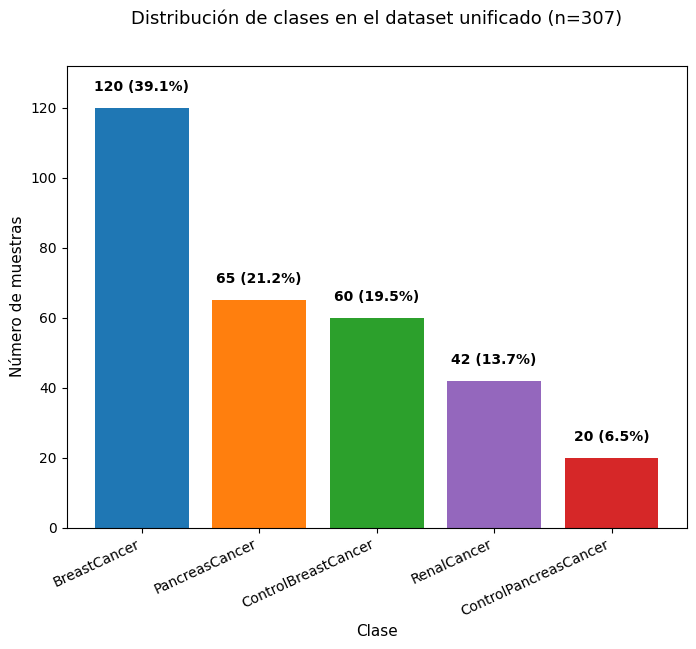

In [151]:
# Voy a guardarme una figura con las clases para la memoria
counts = y_5c.value_counts(dropna=False)
counts.index = counts.index.astype(str)
counts = counts.sort_values(ascending=False)
total = counts.sum()
pct = (counts / total * 100).round(1)

df_plot = pd.DataFrame({
    "Clase": counts.index,
    "Muestras": counts.values,
    "Porcentaje": pct.values
})

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd", "#d62728"]

plt.figure(figsize=(8, 6))
bars = plt.bar(df_plot["Clase"], df_plot["Muestras"], color=colors)

# Etiquetas sobre las barras
for rect, n, p in zip(bars, df_plot["Muestras"], df_plot["Porcentaje"]):
    plt.text(rect.get_x() + rect.get_width() / 2.0,
             rect.get_height() + 4,
             f"{n} ({p}%)",
             ha='center', va='bottom', fontsize=10, weight='bold')

# Ejes y título
plt.title(f"Distribución de clases en el dataset unificado (n={int(total)})", fontsize=13, pad=30)
plt.xlabel("Clase", fontsize=11)
plt.ylabel("Número de muestras", fontsize=11)
plt.xticks(rotation=25, ha='right')

plt.ylim(0, df_plot["Muestras"].max() * 1.1)
plt.margins(y = 0.15)

os.makedirs("/content", exist_ok=True)
out_path = "/content/class_balance_unified.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

---
**Posible texto para la memoria**

---
**Construcción del dataset unificado**

Para este trabajo se ha diseñado un dataset global a partir de tres estudios independientes de expresión de microARNs en biopsias líquidas, cada uno correspondiente a un tipo de enfermedad distinta:

- **Cáncer de páncreas (GSE304572)**: tras el preprocesamiento se obtuvieron **85 muestras**, con dos etiquetas clínicas: PancreasCancerMaligno (65 casos) y PancreasCancerBenigno (20 casos). Los datos originales en formato de counts se normalizaron mediante CPM (Counts Per Million) y posterior transformación log2(CPM+1), generando una matriz de expresión en escala logarítmica.

- **Carcinoma renal metastásico (mRCC, GSE93175)**: se incluyeron **42 muestras**, todas etiquetadas como Renal_mRCC. El dataset estaba ya expresado en escala log2, por lo que únicamente se filtraron los miRNA de varianza cero, manteniendo únicamente aquellos con variación entre muestras.

- **Cáncer de mama (GSE270497)**: se integraron **180 muestras distribuidas en dos grupos (Positive y Negative)**, según la presencia o ausencia de la enfermedad. El dataset original estaba expresado en TPM, aplicándose una normalización mediante log2(TPM+1) para homogeneizar su escala con los otros estudios.

En todos los casos se procedió a una **normalización de los nombres de los miRNA**, eliminando prefijos redundantes (como hsa-) y unificando el formato para garantizar la comparabilidad entre datasets.

---

**Intersección de miRNA comunes**

Dado que cada estudio puede haber cuantificado un número diferente de miRNA, se realizó la **intersección de genes comunes entre los tres conjuntos**. El resultado fue un subconjunto de **135 miRNA compartidos**, presentes en páncreas, renal y mama. Algunos ejemplos son:
['mir-106b-3p', 'mir-106b-5p', 'mir-107', 'mir-10a-5p', 'mir-10b-5p', 'mir-122-5p', 'mir-125a-5p', 'mir-126-3p', 'mir-126-5p', 'mir-127-3p'].

Esto permite construir tres matrices cortadas y alineadas, todas con el mismo número de columnas (135 miRNA):
  - Páncreas: 85 muestras × 135 miRNA
  - Renal: 42 muestras × 135 miRNA
  - Mama: 180 muestras × 135 miRNA

La concatenación de estos subconjuntos genera una** matriz global de 307 muestras y 135 miRNA**, acompañada de metadatos que incluyen información sobre el sample_id, la etiqueta clínica (label), el dataset de origen y el tipo de matriz biológica.


## **Exploración del dataset**

En un primer lugar voy a utilizar técnicas de **reducción de la dimensionaliad**, para poder observar agrupaciones en los datasets con muchos datos.

1. **PCA (Principal Component Analysis)**: Busca combinaciones lineales de las variables originales que maximicen la varizanza explicada.

2. **UMAP (Uniform Manifold Approximation and Projection)**: Modela los datos como un grafo de proximidad (vecinos cercanos en el espacio de alta dimensión). Intenta preservar esas relaciones de vecindad al proyectar a 2D.


### **PCA exploratoria**

**Características de la PCA:**
- Es un **método lineal**, que **preserva la estructura global de los datos** (direcciones de mayor variabilidad).
- Cada eje (PC1, PC2) tiene una **cantidad clara de varianza explicada**.
- Permite relacionar directamente los componentes con combinaciones de miARNs.

**Limitaciones:**
    
- Si las separaciones entre clases están dadas por relaciones no lineales, puede no captarlas bien.
- Los gráficos PCA a veces muestran solapamiento fuerte aunque en el espacio original haya estructuras más complejas.

Varianza explicada: PC1=30.06%, PC2=20.70% (Total 50.77%)


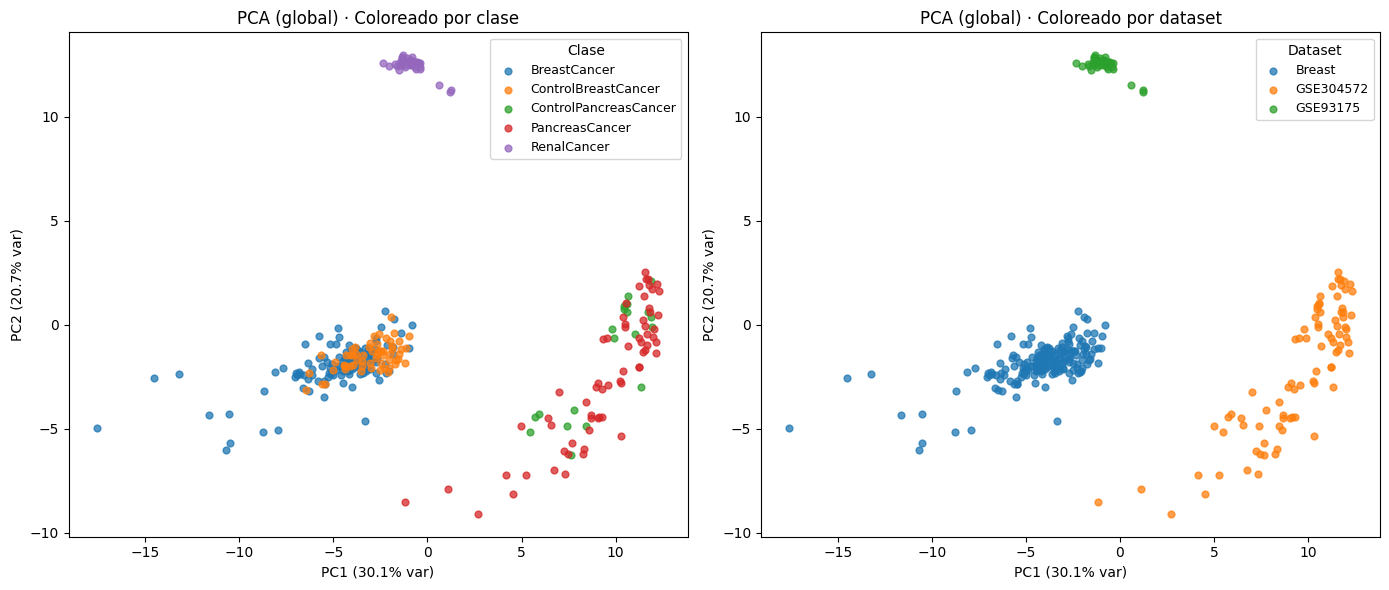

In [152]:
# ======================================================
# PCA sobre la matriz global normalizada (X_all)
# ======================================================

# Alineo los metadatos y las etiquetas
meta_idx = meta_all.set_index("sample_id") if "sample_id" in meta_all.columns else meta_all.copy()

# Ya existe pero por si acaso
if "label_5c" not in meta_idx.columns and "label" in meta_idx.columns:
    label_map = {
        "Positive": "BreastCancer",
        "Negative": "ControlBreastCancer",
        "PancreasCancerMaligno": "PancreasCancer",
        "PancreasCancerBenigno": "ControlPancreasCancer",
        "Renal_mRCC": "RenalCancer"
    }
    meta_idx["label_5c"] = meta_idx["label"].map(label_map)

# Reindexo los metadatos al orden de X_all
meta_idx = meta_idx.reindex(X_all.index)

# Preparo la matriz X (adegurandome de que es numérica y que no tiene NaN/Inf)
X_use = X_all.copy()
X_use = X_use.apply(pd.to_numeric, errors="coerce")
X_use = X_use.replace([np.inf, -np.inf], np.nan).fillna(0.0) # Si hay Na paso a 0 (que no hay pero por si acaso)

# Estandarización (z-score por miRNA)
scaler = StandardScaler(with_mean=True, with_std=True)
X_z = scaler.fit_transform(X_use)          # (muestras x miRNA) -->z-score por columna

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_z)

pca_df = pd.DataFrame(X_pca, index=X_use.index, columns=["PC1", "PC2"])
pca_df["label_5c"] = meta_idx["label_5c"].fillna("Unknown")
pca_df["dataset"]  = meta_idx["dataset"].fillna("Unknown")

evr = pca.explained_variance_ratio_
print(f"Varianza explicada: PC1={evr[0]*100:.2f}%, PC2={evr[1]*100:.2f}% (Total {evr.sum()*100:.2f}%)")

# Gráficos: por clase y por dataset
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Coloreado por clase (label_5c)
for name, sub in pca_df.groupby("label_5c"):
    axes[0].scatter(sub["PC1"], sub["PC2"], alpha=0.75, label=name, s=24)
axes[0].set_title("PCA (global) · Coloreado por clase")
axes[0].set_xlabel(f"PC1 ({evr[0]*100:.1f}% var)")
axes[0].set_ylabel(f"PC2 ({evr[1]*100:.1f}% var)")
axes[0].legend(title="Clase", fontsize=9, markerscale=1)

# Coloreado por dataset
for name, sub in pca_df.groupby("dataset"):
    axes[1].scatter(sub["PC1"], sub["PC2"], alpha=0.75, label=name, s=24)
axes[1].set_title("PCA (global) · Coloreado por dataset")
axes[1].set_xlabel(f"PC1 ({evr[0]*100:.1f}% var)")
axes[1].set_ylabel(f"PC2 ({evr[1]*100:.1f}% var)")
axes[1].legend(title="Dataset", fontsize=9, markerscale=1)

# Me la guardo para descargarla y la muestro
plt.tight_layout()
os.makedirs("/content", exist_ok=True)
out_path = "/content/pca_global.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()



### **UMAP por enfermedad**


Proyecta las muestras a 2D para ver si las clases biológicas (BreastCancer, Renal_mRCC, PancreasCancer, IPMN, Pancreatitis) forman clústeres separados. Detecta estructura no lineal que el PCA podría no mostrar.

**Características de UMAP:**
- Modelo no lineal
- Pone más énfasis en la estructura local (agrupa puntos que son vecinos).
- Produce representaciones 2D en las que los puntos que están cercanos en la gráfica suelen ser “parecidos” en los datos originales.
- Los ejes (UMAP1, UMAP2) no tienen varianza explicada interpretable como en PCA.

**Ventajas frente a PCA:**
- Detecta clusters no lineales y separaciones complejas.
- Suele dar visualizaciones más claras de grupos/clases.

**Limitaciones:**
- No es determinista al 100% (cambia con random_state).
- No permite una interpretación directa de “qué miARN pesa más en UMAP1”.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


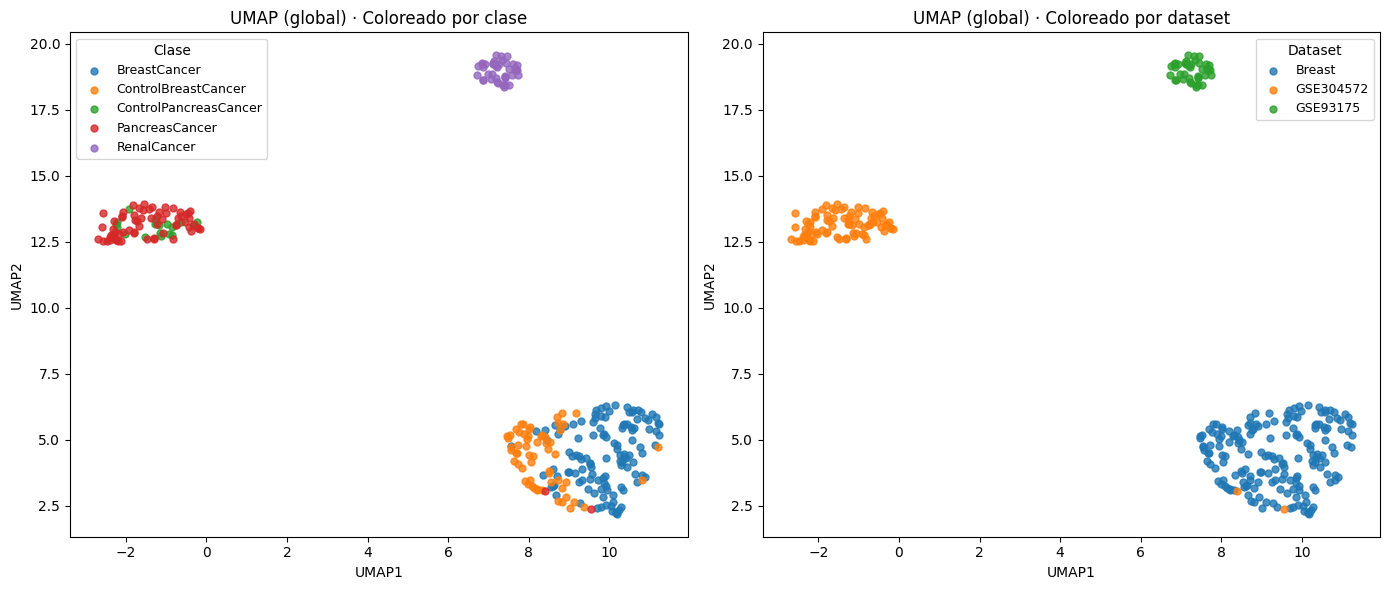

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


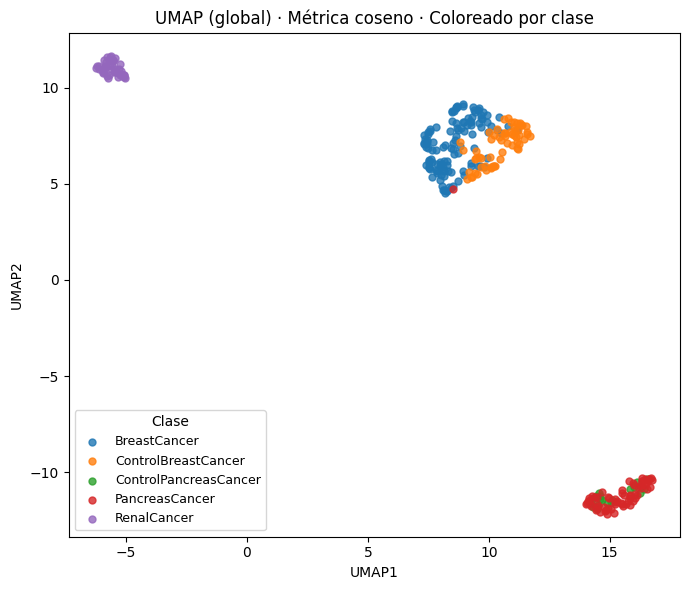

In [153]:
# =========================================================
# UMAP sobre la matriz global normalizada (X_all)
#   - Coloreado por clase (label_5c) y por dataset
#   - Sin usar matrices "crudas": solo el conjunto unificado
# =========================================================

# Metadatos y etiquetas
meta_idx = meta_all.set_index("sample_id") if "sample_id" in meta_all.columns else meta_all.copy()

if "label_5c" not in meta_idx.columns and "label" in meta_idx.columns:
    label_map = {
        "Positive": "BreastCancer",
        "Negative": "ControlBreastCancer",
        "PancreasCancerMaligno": "PancreasCancer",
        "PancreasCancerBenigno": "ControlPancreasCancer",
        "Renal_mRCC": "RenalCancer"
    }
    meta_idx["label_5c"] = meta_idx["label"].map(label_map)

# Alineo el orden de meta_idx con X_all
meta_idx = meta_idx.reindex(X_all.index)

# Preparar X (numérico, sin NaN)
X_use = (X_all.copy()
              .apply(pd.to_numeric, errors="coerce")
              .replace([np.inf, -np.inf], np.nan)
              .fillna(0.0))

# Estandarización
scaler = StandardScaler(with_mean=True, with_std=True)
X_z = scaler.fit_transform(X_use)

# UMAP
umap = UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)
X_umap = umap.fit_transform(X_z)

umap_df = pd.DataFrame(X_umap, index=X_use.index, columns=["UMAP1", "UMAP2"])
umap_df["label_5c"] = meta_idx["label_5c"].fillna("Unknown")
umap_df["dataset"]  = meta_idx["dataset"].fillna("Unknown")

# Gráficos
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Por clase
for name, sub in umap_df.groupby("label_5c"):
    axes[0].scatter(sub["UMAP1"], sub["UMAP2"], alpha=0.8, s=25, label=name)
axes[0].set_title("UMAP (global) · Coloreado por clase")
axes[0].set_xlabel("UMAP1"); axes[0].set_ylabel("UMAP2")
axes[0].legend(title="Clase", fontsize=9, markerscale=1)

# Por dataset
for name, sub in umap_df.groupby("dataset"):
    axes[1].scatter(sub["UMAP1"], sub["UMAP2"], alpha=0.8, s=25, label=name)
axes[1].set_title("UMAP (global) · Coloreado por dataset")
axes[1].set_xlabel("UMAP1"); axes[1].set_ylabel("UMAP2")
axes[1].legend(title="Dataset", fontsize=9, markerscale=1)

# Me la gaurdo para descargarla y la muestro
plt.tight_layout()
os.makedirs("/content", exist_ok=True)
out_path = "/content/umap_global.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

# He probado también con métrica 'coseno' (a veces separa mejor cuando hay diferencias de escala residuales)
umap_cos = UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42
).fit_transform(X_z)

umap_cos_df = pd.DataFrame(umap_cos, index=X_use.index, columns=["UMAP1", "UMAP2"])
umap_cos_df["label_5c"] = meta_idx["label_5c"].fillna("Unknown")

plt.figure(figsize=(7,6))
for name, sub in umap_cos_df.groupby("label_5c"):
    plt.scatter(sub["UMAP1"], sub["UMAP2"], alpha=0.8, s=25, label=name)
plt.title("UMAP (global) · Métrica coseno · Coloreado por clase")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.legend(title="Clase", fontsize=9, markerscale=1)
plt.tight_layout()
plt.show()


### **UMAP por dataset (posible lote)**
Mismo UMAP, pero **coloreado por dataset (GSE304572, GSE93175, GSE270497)**. Si ves clústeres por dataset, hay efecto de lote (tecnología, protocolo).

El objetivo es evaluar si las muestras se agrupan por enfermedad real o por origen técnico del dataset.
- Si en el UMAP las nubes están separadas principalmente por dataset (y no por clase clínica), es señal de batch effect (efecto lote).
- Si, por el contrario, las muestras de distintos datasets se mezclan bien según su enfermedad, significa que la integración entre datasets está funcionando.


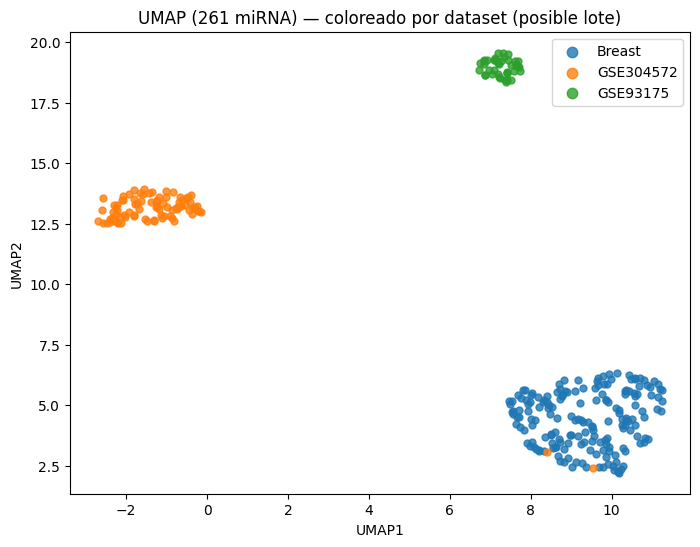

In [154]:
# UMAP coloreado por dataset
datasets = meta_idx["dataset"].reindex(X_all.index).fillna("Unknown")

umap_df_ds = umap_df.copy()
umap_df_ds["dataset"] = datasets.values

plt.figure(figsize=(8,6))
for ds, sub in umap_df_ds.groupby("dataset"):
    plt.scatter(sub["UMAP1"], sub["UMAP2"], alpha=0.8, label=ds, s=25)
plt.title("UMAP (261 miRNA) — coloreado por dataset (posible lote)")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.legend(markerscale=1.5, frameon=True)
plt.show()


**Resultados optenidos por UMAP:**
- **UMAP muestra que los datasets no están integrado**s: cada estudio forma su propio grupo separado.

- Aun así, coincide que cada dataset corresponde a una enfermedad distinta (salvo en páncreas, donde tienes benignos y malignos juntos en el mismo dataset).

Por tanto:
  - Es difícil saber si **la separación se debe solo a la biología de la enfermedad o también a efectos técnicos**.
  - Dentro de páncreas, la falta de separación entre benigno/maligno es un hallazgo relevante: indica que será un reto clasificarlos y necesitarás técnicas más avanzadas (o más features) para diferenciarlos.

### **Corrección de lote con ComBat (por dataset) y comparación**


**ComBat** es un método de **corrección de batch effect (efecto lote)** muy usado en genómica y transcriptómica.

El **batch effect** aparece cuando los datos provienen de distintos experimentos, plataformas o laboratorios (aquí, distintos datasets GEO), y las diferencias técnicas son tan grandes que las muestras se agrupan por origen del experimento en vez de por biología real.


In [155]:
# ========================================================================
# Diagnóstico de NaN por dataset (no sería necesario pero por si acaso)
# ========================================================================

# Calcula, para cada miRNA y cada dataset (lote), si hay todas las muestras NaN.
# Si un miRNA está completamente ausente en algún lote, ComBat no puede estimarlo bien.

# Me aseguro de que todo es numérico (NaN donde haya strings)
X_all_num = X_all.apply(pd.to_numeric, errors="coerce")
X_all_num.index = X_all_num.index.astype(str)

# indexo los metadatos por el ID correcto
id_col = "sample_id" if "sample_id" in meta_all.columns else ("index" if "index" in meta_all.columns else None)
assert id_col is not None, "meta_all necesita columna 'sample_id' o 'index'"
meta_idx = meta_all.set_index(id_col).copy()
meta_idx.index = meta_idx.index.astype(str)

datasets = meta_idx["dataset"].reindex(X_all_num.index)

# % de miRNA con todas las muestras NaN en al menos un dataset
all_nan_by_ds = (
    X_all_num
      .groupby(datasets, axis=0)
      .apply(lambda df: df.isna().all(axis=0))    # columnas (miRNA) que son todo NaN en ese dataset
)
miRNA_problematicos = all_nan_by_ds.any(axis=0)   # True si es todo NaN en cualquier dataset

print("miRNA totalmente NaN en ≥1 dataset:", int(miRNA_problematicos.sum()), "de", X_all_num.shape[1])


miRNA totalmente NaN en ≥1 dataset: 0 de 135


/tmp/ipython-input-2851745589.py:23: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(datasets, axis=0)


Se confirma que no hay ninguno

In [156]:
# Filtro los miRNA problemáticos (que no hay)
cols_keep = miRNA_problematicos[~miRNA_problematicos].index.tolist()
Xf = X_all_num[cols_keep].copy()

print("Forma tras filtrar miRNA problemáticos:", Xf.shape)


Forma tras filtrar miRNA problemáticos: (307, 135)


In [157]:
# ===========================================
# Imputación por dataset (mediana por miRNA)

# ===========================================
# Relleno NaNs usando la mediana por miRNA calculada dentro de cada dataset. Así evito que ComBat falle y reduzco el sesgo.
def batchwise_impute(df, batch_series):
    out = df.copy()
    for b in batch_series.dropna().unique():
        mask = (batch_series == b)
        sub = out.loc[mask]
        med = sub.median(axis=0, skipna=True)
        out.loc[mask] = sub.fillna(med)
    return out

Xi = batchwise_impute(Xf, datasets)
print("NaNs restantes tras imputación por dataset:", int(Xi.isna().sum().sum()))


NaNs restantes tras imputación por dataset: 0


In [158]:
covars = pd.DataFrame({"batch": datasets.values}, index=Xi.index)
covars["intercept"] = 1

combat_res = neuroCombat(
    dat=Xi.T.values,      # features x samples
    covars=covars,
    batch_col="batch"
)["data"]

X_combat_df = pd.DataFrame(combat_res.T, index=Xi.index, columns=Xi.columns)

scaler = StandardScaler()
Xc_scaled = scaler.fit_transform(X_combat_df.values)
Xc_scaled_df = pd.DataFrame(Xc_scaled, index=X_combat_df.index, columns=X_combat_df.columns)

print("Forma post-ComBat + z-score:", Xc_scaled_df.shape)


[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Forma post-ComBat + z-score: (307, 135)


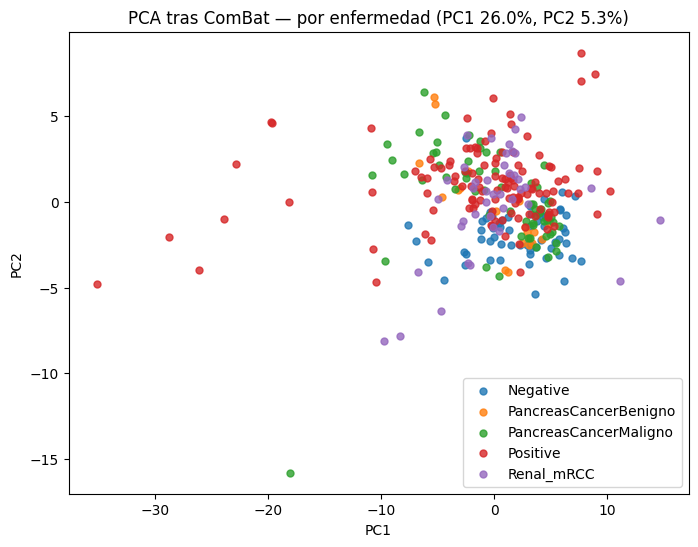

In [159]:
# =============================================
# PCA tras ComBat (coloreado por enfermedad)
# =============================================

labels_c = meta_idx["label"].reindex(Xc_scaled_df.index)

pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(Xc_scaled_df.values)

pca_df = pd.DataFrame(Xp, columns=["PC1","PC2"], index=Xc_scaled_df.index)
pca_df["label"] = labels_c.values

plt.figure(figsize=(8,6))
for lab, sub in pca_df.groupby("label"):
    plt.scatter(sub["PC1"], sub["PC2"], alpha=0.8, label=lab, s=25)

plt.title(f"PCA tras ComBat — por enfermedad (PC1 {pca.explained_variance_ratio_[0]*100:.1f}%, "
          f"PC2 {pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()

# La guardo y muestro
os.makedirs("/content", exist_ok=True)
out_path = "/content/pca_combat_global.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


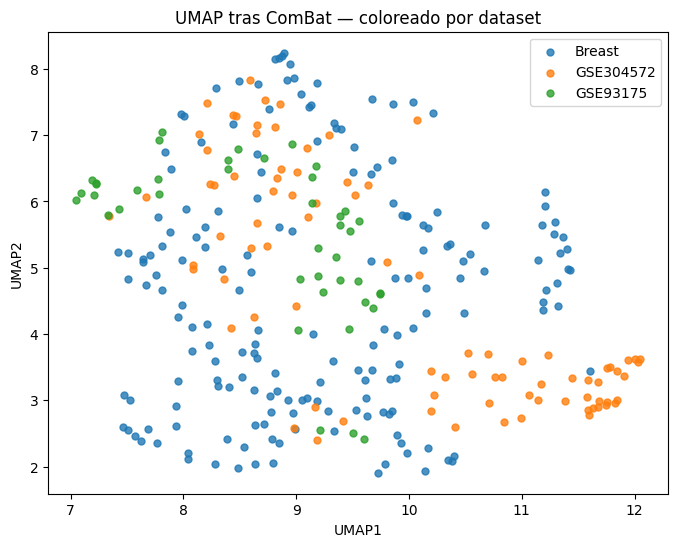

In [160]:
# =======================================
# UMAP tras ComBat (coloreado por dataset)
# =======================================

datasets_c = meta_idx["dataset"].reindex(Xc_scaled_df.index)

umap = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
Xu = umap.fit_transform(Xc_scaled_df.values)

umap_df = pd.DataFrame(Xu, columns=["UMAP1","UMAP2"], index=Xc_scaled_df.index)
umap_df["dataset"] = datasets_c.values

plt.figure(figsize=(8,6))
for ds, sub in umap_df.groupby("dataset"):
    plt.scatter(sub["UMAP1"], sub["UMAP2"], alpha=0.8, label=ds, s=25)

plt.title("UMAP tras ComBat — coloreado por dataset")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.legend()

# La guardo y muestro
os.makedirs("/content", exist_ok=True)
out_path = "/content/umap_combat_global.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()


**Conclusiones:**

**PCA (coloreado por enfermedad):**
- Antes de ComBat cada enfermedad estaba muy separada pero también lo estaban los datasets, es decir hay **riesgo de confundir efecto biológico con técnico**.
- Ahora las nubes están mucho más mezcladas en el espacio (más compactas), lo cual indica que se ha reducido bastante el efecto lote.
- **Siguen apareciendo algunos outliers** (puntos muy alejados), pero el patrón global es más coherente.

- **UMAP (coloreado por dataset)**:
- Antes, cada dataset formaba un clúster casi aislado.
- Después de ComBat, los datasets siguen mostrando gradientes (azul, naranja, verde no están completamente solapados), pero **ya no forman clústeres rígidos**. En otras palabras, ComBat ha reducido parte del sesgo técnico.

Esto es normal en este caso, porque se esta trabajando con datos biológicos heterogéneos y plataformas distintas, la corrección nunca es perfecta, pero suficiente para análisis multiclase.


**Resultados:**
1. **Antes de ComBat**: la separación entre datasets era casi absoluta (efecto lote muy fuerte).

2. **Después de ComBat**:
- El efecto lote se redujo (datasets más mezclados).
- La varianza explicada se redistribuyó: ahora no domina un único componente.
- La separación entre enfermedades no es tan clara, pero ahora refleja diferencias más sutiles (biología real vs ruido técnico).

3. **UMAP tras ComBat** confirma que, aunque el efecto lote no desaparece totalmente, la integración entre datasets es **mucho mejor** que antes.

La corrección con ComBat es necesaria, ya que **sin ella los modelos habrían aprendido principalmente a distinguir datasets, no enfermedades**.

Habrá que valorar si merece la pena la corrección, aunque se pierde parte de la varianza bruta, igual la señal es más interpretable y útil para clasificación.

# **Selección de características**



La idea es hacer dos selecciones de características por separado:

  **1. Selección por separado (cada dataset independiente)**

Consiste en coger cada dataset de cada enfermedad por separado, y seleccionar los miARN relevantes de solo ese dataset.

Con esto se consigue identificar biomarcadores específicos de cada enfermedad sin contaminación de otras y que sobre todo sean capaces de clasificar entre las dos clases que haya en el dataset (ya sea por ejemplo entre PancreasBenigno y PancreasMaligno en el caso de Cancer pancréatico o entre BreastControl y BreastCancer en el caso de cancer de mama).

Eso sí, hacer sólo este estudio tiene limitaciones. Por ejemplo,cada dataset tiene tamaño limitado, por lo que hay menos potencia estadística. Además los miARN seleccionados pueden no coincidir entre datasets (es difícil integrarlos luego en un modelo multiclase).

**2. Selección sobre el dataset conjunto (tras corrección de lote)**

Consiste en combinar todos los datasets en una matriz común, corrigir efectos de lote (ComBat) o no (voy a realizar ambos estudios), y seleccionar las características sobre el conjunto.

De este modo se utilizan todas las muestras a la vez (más potencia estadística y más robustez). Los miARN seleccionados se puede decir que son los que mejor discriminan entre enfermedades distintas, no solo dentro de una y es coherente con el objetico de este TFM: construir un modelo multiclase global (detectar y diferenciar enfermedades a partir de miARN).

No obstante, si sólo hicera este estudio, puedo perder señales muy específicas de un dataset (si un miARN solo cambia en un cáncer muy concreto y no en los otros).

Por todo esto he realizado tanto una selección de características en cada dataset como en el dataset conjunto.

## **Análisis global multiclase**

### **Preprocesado de los datos**

Alinea datos/etiquetas y define funciones de apoyo (FDR BH, CV con grupos por dataset, etc.).

Usaremos validación cruzada estratificada por clase y agrupada por dataset (si tu sklearn soporta StratifiedGroupKFold), para medir generalización entre estudios.

In [161]:
X_use = Xc_scaled_df if "Xc_scaled_df" in globals() else X_scaled_df
X_use = X_use.copy()
X_use.index = X_use.index.astype(str)

# Alineo los metadatos
id_col = "sample_id" if "sample_id" in meta_all.columns else ("index" if "index" in meta_all.columns else None)
meta_idx = meta_all.set_index(id_col).copy()
meta_idx.index = meta_idx.index.astype(str)

y = meta_idx["label"].reindex(X_use.index).astype("category")
groups = meta_idx["dataset"].reindex(X_use.index).astype(str)

print("X:", X_use.shape, "| clases:", list(y.cat.categories), "| datasets:", groups.unique().tolist())

def bh_fdr(pvals: pd.Series) -> pd.Series:
    """Benjamini-Hochberg FDR q-values (p ajustados)."""
    from statsmodels.stats.multitest import multipletests
    _, q, _, _ = multipletests(pvals, method="fdr_bh")
    return pd.Series(q, index=pvals.index)

try:
    from sklearn.model_selection import StratifiedGroupKFold
    def make_cv(n_splits=5, random_state=42):
        return StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    print("Usando StratifiedGroupKFold (estratificado por clase y separado por dataset).")
except Exception:
    from sklearn.model_selection import GroupKFold
    def make_cv(n_splits=5, random_state=42):
        # no estratifica; si prefieres estratificada normal: StratifiedKFold
        return GroupKFold(n_splits=n_splits)
    print("Fallback: GroupKFold (separa por dataset).")


X: (307, 135) | clases: ['Negative', 'PancreasCancerBenigno', 'PancreasCancerMaligno', 'Positive', 'Renal_mRCC'] | datasets: ['GSE304572', 'GSE93175', 'Breast']
Usando StratifiedGroupKFold (estratificado por clase y separado por dataset).


Tamaño del dataset (filtrado y normalizado): (307, 135)
Distribución de clases:
 label_5c
BreastCancer             120
PancreasCancer            65
ControlBreastCancer       60
RenalCancer               42
ControlPancreasCancer     20
Name: count, dtype: int64


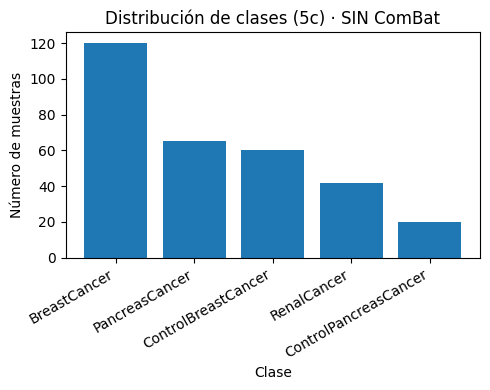

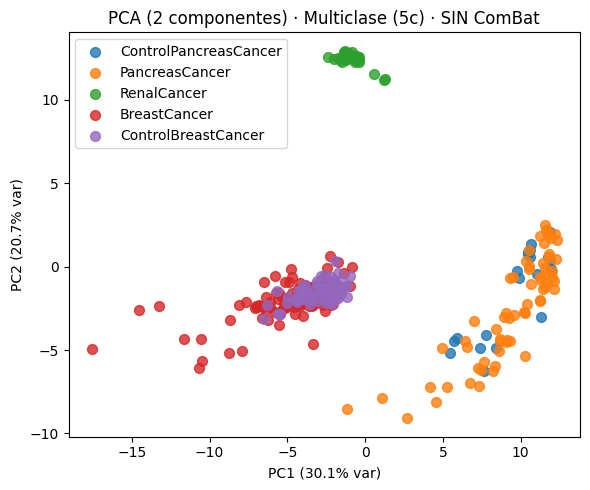

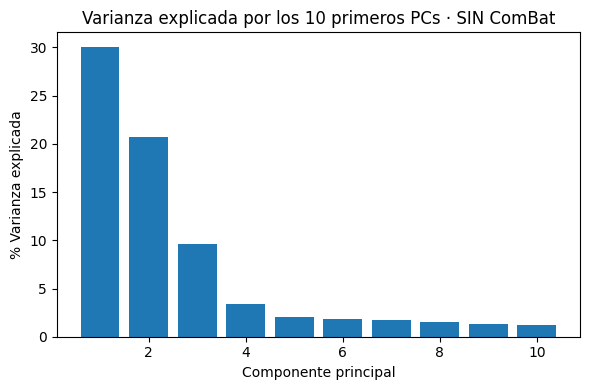

Tamaño del dataset (CON ComBat): (307, 135)
Distribución de clases (5c):
 label_5c
BreastCancer             120
PancreasCancer            65
ControlBreastCancer       60
RenalCancer               42
ControlPancreasCancer     20
Name: count, dtype: int64


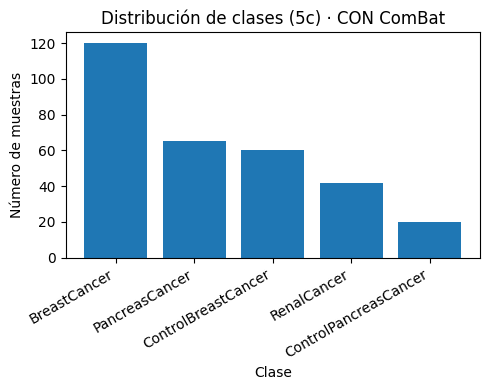

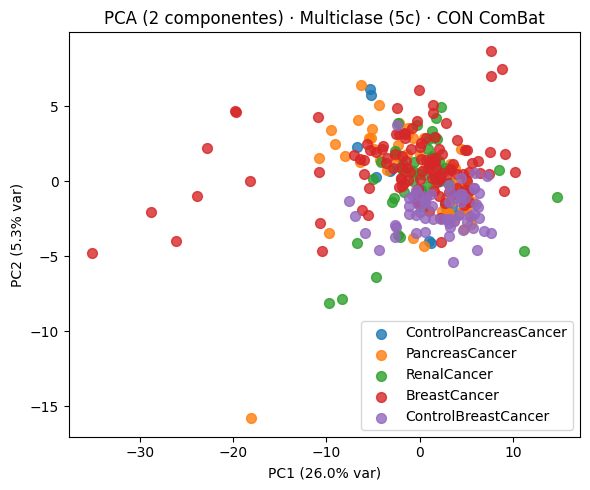

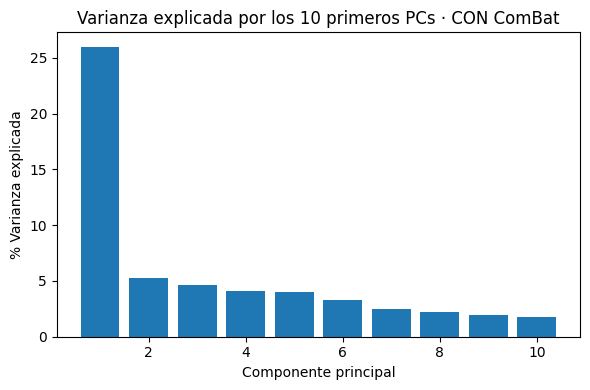

In [162]:
# ==================================================================================
# Matriz global (muestras x miRNA) para el caso de 5 clases y SIN ComBat
# ==================================================================================

# Alineo etiquetas multiclase (5 clases)
y_5c = meta_all.set_index("sample_id")["label_5c"].reindex(X_all.index)

# Filtro las muestras con la etiqueta válida
mask = y_5c.notna()
X = X_all.loc[mask].copy()
y = y_5c.loc[mask]

print("Tamaño del dataset (filtrado y normalizado):", X.shape)
print("Distribución de clases:\n", y.value_counts())

# Estandarización (z-score por miRNA)
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X.values)

# PCA
pca2 = PCA(n_components=2, random_state=42)
X_pca = pca2.fit_transform(X_scaled)

# Distribución de clases
counts = y.value_counts()
plt.figure(figsize=(5,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Distribución de clases (5c) · SIN ComBat")
plt.xlabel("Clase"); plt.ylabel("Número de muestras")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# PCA coloreado por clase
plt.figure(figsize=(6,5))
for cls in y.unique():
    idx = (y == cls).values
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=cls, s=50, alpha=0.8)
plt.legend(); plt.title("PCA (2 componentes) · Multiclase (5c) · SIN ComBat")
plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]*100:.1f}% var)")
plt.tight_layout()
plt.show()

# Varianza explicada (10 PCs)
pca10 = PCA(n_components=10, random_state=42).fit(X_scaled)
plt.figure(figsize=(6,4))
plt.bar(range(1,11), pca10.explained_variance_ratio_*100)
plt.xlabel("Componente principal"); plt.ylabel("% Varianza explicada")
plt.title("Varianza explicada por los 10 primeros PCs · SIN ComBat")
plt.tight_layout()
plt.show()


# ==========================================================================
# Matriz global (muestras x miRNA) para el caso de 5 clases y CON ComBat
# ==========================================================================
if "Xc_scaled_df" in globals():
    # Alineo a las mismas muestras del vector y (5 clases)
    Xc = Xc_scaled_df.reindex(y.index).copy()

    print("Tamaño del dataset (CON ComBat):", Xc.shape)
    print("Distribución de clases (5c):\n", y.value_counts())

    Xc_scaled = Xc.values  # ya está escalada

    # PCA
    pca2c = PCA(n_components=2, random_state=42)
    Xc_pca = pca2c.fit_transform(Xc_scaled)

    # Distribución de clases
    counts_c = y.value_counts()
    plt.figure(figsize=(5,4))
    plt.bar(counts_c.index.astype(str), counts_c.values)
    plt.title("Distribución de clases (5c) · CON ComBat")
    plt.xlabel("Clase"); plt.ylabel("Número de muestras")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    # PCA coloreado por clase
    plt.figure(figsize=(6,5))
    for cls in y.unique():
        idx = (y == cls).values
        plt.scatter(Xc_pca[idx,0], Xc_pca[idx,1], label=cls, s=50, alpha=0.8)
    plt.legend(); plt.title("PCA (2 componentes) · Multiclase (5c) · CON ComBat")
    plt.xlabel(f"PC1 ({pca2c.explained_variance_ratio_[0]*100:.1f}% var)")
    plt.ylabel(f"PC2 ({pca2c.explained_variance_ratio_[1]*100:.1f}% var)")
    plt.tight_layout()
    plt.show()

    # Varianza explicada (10 PCs)
    pca10c = PCA(n_components=10, random_state=42).fit(Xc_scaled)
    plt.figure(figsize=(6,4))
    plt.bar(range(1,11), pca10c.explained_variance_ratio_*100)
    plt.xlabel("Componente principal"); plt.ylabel("% Varianza explicada")
    plt.title("Varianza explicada por los 10 primeros PCs · CON ComBat")
    plt.tight_layout()
    plt.show()
else:
    print("No se detectó 'Xc_scaled_df' → se omite el bloque CON ComBat.")


### **Filtros univariantes**


#### **ANOVA F-test**

Voy a utilizar el **test ANOVA F** para evaluar si existen diferencias significativas en las medias de expresión de cada miARN entre las 5 clases estudiadas.


El análisis **ANOVA (Analysis of Variance)** evalúa, para cada miARN, si las **medias de expresión difieren significativamente entre las clases**.

En este contexto, cada miARN se analiza como una variable independiente, y la etiqueta de clase (por ejemplo, tipo de cáncer o control) como la variable de agrupación.

El estadístico F mide la relación entre la varianza entre grupos y la varianza dentro de los grupos.

Un **F alto y un p-valor bajo** indican que ese miARN **presenta diferencias de expresión significativas entre al menos dos clases**.

En otras palabras, un miARN que aparece en el top ANOVA es aquel **cuya expresión cambia significativamente entre grupos**, lo que lo convierte en un **posible biomarcador discriminante global** en el contexto multiclase.

Muestras y clases usadas (SIN ComBat):
label_5c
BreastCancer             120
PancreasCancer            65
ControlBreastCancer       60
RenalCancer               42
ControlPancreasCancer     20
Name: count, dtype: int64


Feature      F_score        p_value     q_value_BH
0  mir-23a-3p  1933.608059  9.589862e-214  1.294631e-211
1  mir-126-5p  1673.364103  1.192974e-204  8.052574e-203
2  mir-19a-3p  1194.081382  1.182075e-183  5.319337e-182
3  mir-23b-3p  1113.396530  2.381112e-179  8.036253e-178
4  mir-328-3p   930.814108  2.020350e-168  5.454945e-167
5  mir-574-3p   917.394428  1.532348e-167  3.447782e-166
6  mir-92b-3p   836.262411  5.921310e-162  1.141967e-160
7  mir-30e-3p   752.946939  1.128886e-155  1.904995e-154
8  mir-139-5p   712.592925  2.114503e-152  3.171754e-151
9   mir-22-3p   665.370905  2.367855e-148  3.196605e-147

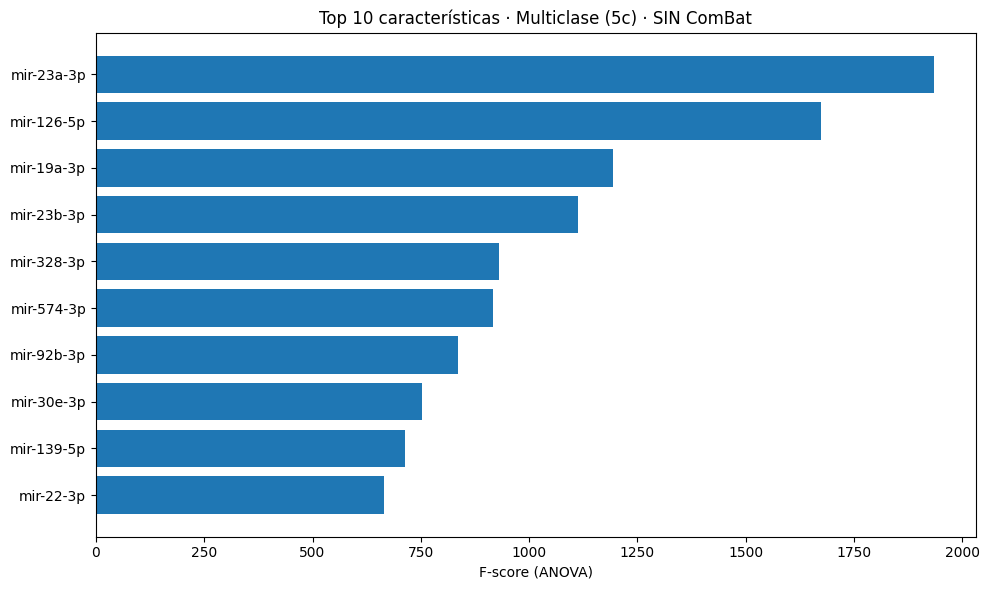


Guardado (SIN ComBat): 'anova_5c_df_sincombat' (tabla completa) y 'topN_5c_anova_sincombat' (Top 10).

Muestras y clases usadas (CON ComBat):
label_5c
BreastCancer             120
PancreasCancer            65
ControlBreastCancer       60
RenalCancer               42
ControlPancreasCancer     20
Name: count, dtype: int64


Feature    F_score       p_value    q_value_BH
0      mir-484  30.348896  3.081089e-21  4.159471e-19
1     mir-4492  13.788471  2.431198e-10  1.553252e-08
2   mir-425-5p  13.573964  3.451671e-10  1.553252e-08
3      mir-107  10.881213  2.965945e-08  1.001006e-06
4   mir-363-3p  10.350944  7.209703e-08  1.946620e-06
5    mir-22-3p   9.643465  2.370706e-07  4.921883e-06
6   mir-23a-3p   9.556815  2.743886e-07  4.921883e-06
7  mir-378a-3p   9.520632  2.916672e-07  4.921883e-06
8  mir-106b-3p   9.413060  3.497629e-07  5.246444e-06
9   mir-20a-5p   9.306745  4.185934e-07  5.651010e-06

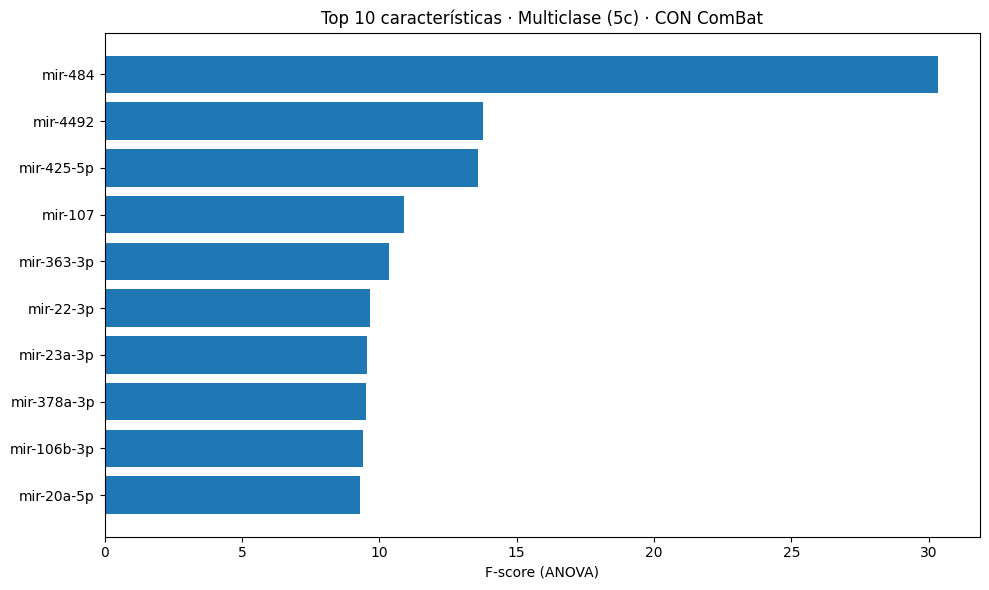


Guardado (CON ComBat): 'anova_5c_df_concombat' (tabla completa) y 'topN_5c_anova_concombat' (Top 10).


In [163]:
# ===========================================
# ANOVA (f_classif) (5 clases y sin ComBat)
# ===========================================

# BH-FDR (Benjamini–Hochberg)
def bh_fdr(pvals: pd.Series) -> pd.Series:
    p = pvals.values.astype(float)
    n = len(p)
    order = np.argsort(p)
    ranked = np.empty(n, dtype=float)
    cummin = 1.0
    for i in range(n-1, -1, -1):
        rank = i + 1
        val = p[order[i]] * n / rank
        cummin = min(cummin, val)
        ranked[order[i]] = min(cummin, 1.0)
    return pd.Series(ranked, index=pvals.index)

# Etiquetas multiclase (5 clases), alineadas a X_all
y_5c = meta_all.set_index("sample_id")["label_5c"].reindex(X_all.index)

# Filtro las muestras válidas (sin NaN en la etiqueta) --> No hay ninguna pero por si acaso
mask = y_5c.notna()
X_use = X_all.loc[mask].copy()
y_use = y_5c.loc[mask]

print("Muestras y clases usadas (SIN ComBat):")
print(y_use.value_counts())

# Limpio columnas problemáticas: constantes y NaNs --> No hay ninguna pero por si acaso
varianza = X_use.var(axis=0, ddof=1)
cols_const = varianza.index[varianza == 0]
if len(cols_const) > 0:
    X_use.drop(columns=cols_const, inplace=True)

if X_use.isna().any().any():
    X_use = X_use.fillna(X_use.median())

# Codifico clases a enteros para f_classif
y_codes = y_use.astype("category").cat.codes

# ANOVA multiclase
selector = SelectKBest(score_func=f_classif, k="all")
_ = selector.fit_transform(X_use, y_codes)

anova_results_5c_sin = pd.DataFrame({
    "Feature": X_use.columns.astype(str),
    "F_score": selector.scores_,
    "p_value": selector.pvalues_
}).sort_values(["F_score", "p_value"], ascending=[False, True]).reset_index(drop=True)

anova_results_5c_sin["q_value_BH"] = bh_fdr(anova_results_5c_sin["p_value"])

# Resultados principales
os.makedirs("/content", exist_ok=True)
top10_df = anova_5c_df_sincombat.head(10)
display(anova_results_5c_sin.head(10))

# Gráfico Top-N por F-score
topN = 10
top_df = anova_results_5c_sin.head(topN).iloc[::-1]
plt.figure(figsize=(10, 6))
plt.barh(top_df["Feature"], top_df["F_score"])
plt.xlabel("F-score (ANOVA)")
plt.title(f"Top {topN} características · Multiclase (5c) · SIN ComBat")
plt.tight_layout()

# Me la guardo para la memoria
plt.tight_layout()
plt.savefig("/content/anova_5c_sin_combat_top10.png", dpi=300, bbox_inches="tight")
plt.show()

# Variables de salida (SIN ComBat)
anova_5c_df_sincombat = anova_results_5c_sin.copy()
topN_5c_anova_sincombat = anova_results_5c_sin.head(topN)["Feature"].tolist()

print(f"\nGuardado (SIN ComBat): 'anova_5c_df_sincombat' (tabla completa) y 'topN_5c_anova_sincombat' (Top {topN}).")

# ==========================================================
# ANOVA (f_classif) (5 clases y con ComBat)
# ==========================================================
if "Xc_scaled_df" in globals():
    # Alineo las muestras a las mismas etiquetas 5c
    Xc_use = Xc_scaled_df.reindex(y_use.index).copy()

    print("\nMuestras y clases usadas (CON ComBat):")
    print(y_use.value_counts())

    # Limpio columnas problemáticas: constantes y NaNs --> No hay ninguna pero por si acaso
    varianza_c = Xc_use.var(axis=0, ddof=1)
    cols_const_c = varianza_c.index[varianza_c == 0]
    if len(cols_const_c) > 0:
        Xc_use.drop(columns=cols_const_c, inplace=True)

    if Xc_use.isna().any().any():
        Xc_use = Xc_use.fillna(Xc_use.median())

    # ANOVA multiclase sobre matriz ComBat
    selector_c = SelectKBest(score_func=f_classif, k="all")
    _ = selector_c.fit_transform(Xc_use, y_codes)

    anova_results_5c_con = pd.DataFrame({
        "Feature": Xc_use.columns.astype(str),
        "F_score": selector_c.scores_,
        "p_value": selector_c.pvalues_
    }).sort_values(["F_score", "p_value"], ascending=[False, True]).reset_index(drop=True)

    anova_results_5c_con["q_value_BH"] = bh_fdr(anova_results_5c_con["p_value"])

    # Resultados principales
    display(anova_results_5c_con.head(10))

    # Gráfico Top-N
    top_df_c = anova_results_5c_con.head(topN).iloc[::-1]
    plt.figure(figsize=(10, 6))
    plt.barh(top_df_c["Feature"], top_df_c["F_score"])
    plt.xlabel("F-score (ANOVA)")
    plt.title(f"Top {topN} características · Multiclase (5c) · CON ComBat")
    plt.tight_layout()
    plt.show()

    # Variables de salida (CON ComBat)
    anova_5c_df_concombat = anova_results_5c_con.copy()
    topN_5c_anova_concombat = anova_results_5c_con.head(topN)["Feature"].tolist()

    print(f"\nGuardado (CON ComBat): 'anova_5c_df_concombat' (tabla completa) y 'topN_5c_anova_concombat' (Top {topN}).")
else:
    print("\nNo se detectó 'Xc_scaled_df', se omite el bloque CON ComBat.")


#### **Kruskal-Wallis (no paramétrico)**

Voy a utilziar el test de Kruskal–Wallis como alternativa no paramétrica a ANOVA. Comparando las distribuciones de cada miARN entre varios grupos usando rangos, sin asumir normalidad ni varianzas iguales.

El test de **Kruskal-Wallis** es la versión no paramétrica del ANOVA, que no asume normalidad ni varianzas iguales.

Ordena las observaciones y compara las distribuciones de los valores de expresión entre clases.

El estadístico **H** refleja la **magnitud de las diferencias en las medianas entre grupos**.

En otras palabras, un miARN con **H elevado y p-valor pequeño** sugiere **diferencias sistemáticas en su distribución de expresión entre las clases.** A diferencia de ANOVA, este test es más robusto frente a valores atípicos o distribuciones sesgadas, por lo que refuerza los hallazgos de forma complementaria.

Muestras y clases usadas (SIN ComBat):
label_5c
BreastCancer             120
PancreasCancer            65
ControlBreastCancer       60
RenalCancer               42
ControlPancreasCancer     20
Name: count, dtype: int64
Columnas constantes eliminadas: 0


miRNA           H             p      p_adj_bh
107     mir-484  271.248714  1.716399e-57  2.317139e-55
51   mir-23a-3p  249.807367  7.162388e-53  4.834612e-51
46    mir-22-3p  246.744321  3.272463e-52  1.472608e-50
98   mir-423-3p  244.948414  7.974511e-52  2.691398e-50
52   mir-23b-3p  239.046680  1.488484e-50  4.018906e-49
8    mir-126-5p  237.046690  4.012528e-50  8.398092e-49
129  mir-92b-3p  236.881702  4.354566e-50  8.398092e-49
118  mir-574-3p  236.608375  4.986547e-50  8.414798e-49
72   mir-328-3p  235.678895  7.905672e-50  1.185851e-48
106    mir-451a  233.665139  2.145484e-49  2.896403e-48

Variables guardadas (SIN ComBat): `kruskal_5c_df_sincombat` (tabla completa) y `top20_5c_kruskal_sincombat` (lista).


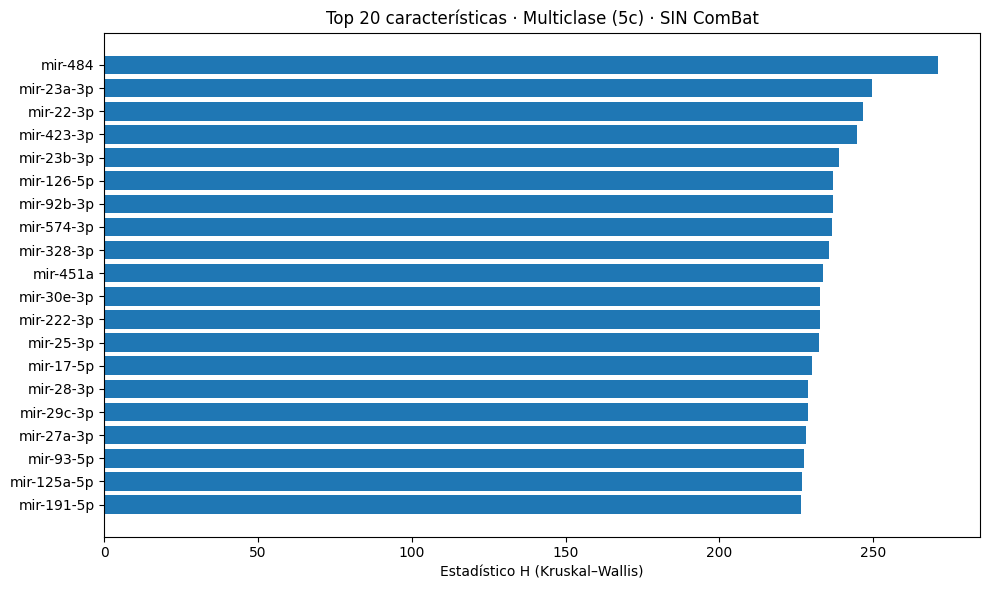


Muestras y clases usadas (CON ComBat):
label_5c
BreastCancer             120
PancreasCancer            65
ControlBreastCancer       60
RenalCancer               42
ControlPancreasCancer     20
Name: count, dtype: int64
Columnas constantes eliminadas (CON ComBat): 0


miRNA           H             p      p_adj_bh
107      mir-484  110.449820  5.835192e-23  7.877509e-21
0    mir-106b-3p   83.695275  2.868988e-17  1.936567e-15
42    mir-20a-5p   64.301410  3.610930e-13  1.624918e-11
103   mir-425-5p   61.544152  1.373734e-12  4.636353e-11
105     mir-4492   58.185017  6.978185e-12  1.884110e-10
87    mir-363-3p   55.019865  3.217988e-11  7.240472e-10
2        mir-107   54.006053  5.247344e-11  1.011988e-09
46     mir-22-3p   52.698930  9.851937e-11  1.662514e-09
98    mir-423-3p   49.393276  4.833511e-10  7.250266e-09
51    mir-23a-3p   48.838075  6.311112e-10  8.520001e-09

Variables guardadas (CON ComBat): 'kruskal_5c_df_concombat' (tabla completa) y 'top20_5c_kruskal_concombat' (lista).


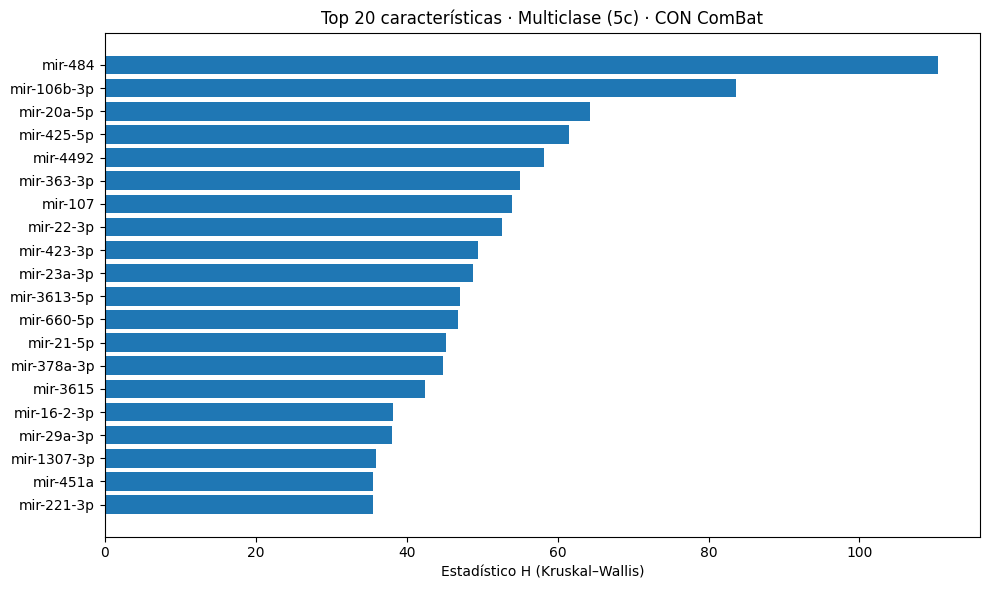

In [164]:
# ========================================
# Kruskal–Wallis (5 clases y sin ComBat)
# ========================================

# Aplica Kruskal–Wallis por columna (feature) agrupando por clase (y)
# Devuelviendo un DataFrame con H, p y p ajustado (BH-FDR)
def kruskal_safe(Xd: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
    rows = []
    classes = pd.unique(y)
    for col in Xd.columns:
        groups = [Xd.loc[y == c, col].values for c in classes]
        # Evito errores si algún grupo tiene longitud < 2 o var = 0
        try:
            H, p = stats.kruskal(*groups, nan_policy="omit")
        except Exception:
            H, p = 0.0, 1.0
        rows.append((col, H, p))
    out = pd.DataFrame(rows, columns=["miRNA", "H", "p"]).sort_values("p", ascending=True)
    out["p_adj_bh"] = multipletests(out["p"], method="fdr_bh")[1]
    return out

# Kruskal–Wallis SIN ComBat
y_5c = meta_all.set_index("sample_id")["label_5c"].reindex(X_all.index)
mask = y_5c.notna()

Xk = X_all.loc[mask].copy()
y  = y_5c.loc[mask].copy()

# Limpieza: columnas constantes y NaNs --> No hay pero por si acaso
varianza = Xk.var(axis=0, ddof=1)
const_cols = varianza.index[varianza == 0]
if len(const_cols) > 0:
    Xk.drop(columns=const_cols, inplace=True)

if Xk.isna().any().any():
    Xk = Xk.fillna(Xk.median())

print("Muestras y clases usadas (SIN ComBat):")
print(y.value_counts())
print(f"Columnas constantes eliminadas: {len(const_cols)}")

# Kruskal–Wallis multiclase
kruskal_5c_df_sincombat = kruskal_safe(Xk, y)
display(kruskal_5c_df_sincombat.head(10))

# Top-N (por p-valor)
topN = 20
top20_5c_kruskal_sincombat = kruskal_5c_df_sincombat.nsmallest(topN, "p")["miRNA"].tolist()

print("Variables guardadas (SIN ComBat): `kruskal_5c_df_sincombat` (tabla completa) y `top20_5c_kruskal_sincombat` (lista).")

# Gráfico de los Top-N por estadístico H
top_df = kruskal_5c_df_sincombat.nsmallest(topN, "p").copy().iloc[::-1]
plt.figure(figsize=(10, 6))
plt.barh(top_df["miRNA"], top_df["H"])
plt.xlabel("Estadístico H (Kruskal–Wallis)")
plt.title(f"Top {topN} características · Multiclase (5c) · SIN ComBat")
plt.tight_layout()
plt.show()

# ========================================
# Kruskal–Wallis (5 clases y con ComBat)
# ========================================
if "Xc_scaled_df" in globals():
    Xkc = Xc_scaled_df.reindex(y.index).copy()

    # Limpieza: columnas constantes y NaNs --> No las hay pero por si acaso
    varianza_c = Xkc.var(axis=0, ddof=1)
    const_cols_c = varianza_c.index[varianza_c == 0]
    if len(const_cols_c) > 0:
        Xkc.drop(columns=const_cols_c, inplace=True)

    if Xkc.isna().any().any():
        Xkc = Xkc.fillna(Xkc.median())

    print("\nMuestras y clases usadas (CON ComBat):")
    print(y.value_counts())
    print(f"Columnas constantes eliminadas (CON ComBat): {len(const_cols_c)}")

    # Kruskal–Wallis con matriz ComBat
    kruskal_5c_df_concombat = kruskal_safe(Xkc, y)
    display(kruskal_5c_df_concombat.head(10))

    # Top-N (por p-valor)
    top20_5c_kruskal_concombat = kruskal_5c_df_concombat.nsmallest(topN, "p")["miRNA"].tolist()

    print("Variables guardadas (CON ComBat): 'kruskal_5c_df_concombat' (tabla completa) y 'top20_5c_kruskal_concombat' (lista).")

    # Gráfico Top-N por H
    top_df_c = kruskal_5c_df_concombat.nsmallest(topN, "p").copy().iloc[::-1]
    plt.figure(figsize=(10, 6))
    plt.barh(top_df_c["miRNA"], top_df_c["H"])
    plt.xlabel("Estadístico H (Kruskal–Wallis)")
    plt.title(f"Top {topN} características · Multiclase (5c) · CON ComBat")
    plt.tight_layout()
    plt.show()
else:
    print("\nNo se detectó 'Xc_scaled_df', se omite el bloque CON ComBat.")


#### **Mutual Information (dependencia no lineal)**

Utilizo **Mutual Information (MI)** para medir la dependencia (lineal o no lineal) entre la expresión de cada miARN y la variable de clase. A diferencia de ANOVA o Kruskal, MI no devuelve un p-valor, sino un valor de información (≥0), donde los valores altos indican mayor poder de discriminación.

La **Mutual Information** mide la dependencia estadística entre la expresión de cada miARN y la variable de clase, sin suponer relaciones lineales.

**Cuantifica cuánta información** (en bits) **aporta conocer el valor de un miARN** para **predecir la clase** a la que pertenece una muestra.

Cuanto **mayor es el valor de MI**, mayor es la capacidad de ese miARN para reducir la incertidumbre sobre la clase.

En otras palabras, los miARNs con **mayor MI** son los que presentan **mayor poder predictivo global en un sentido multiclase**, incluso si la relación no es lineal.

In [165]:
# =================================================
# Mutual Information (MI) (5 clases y sin ComBat)
# =================================================

y_5c = meta_all.set_index("sample_id")["label_5c"].reindex(X_all.index)
mask = y_5c.notna()

Xk = X_all.loc[mask].copy()
y_ser = y_5c.loc[mask].copy()

# Limpieza: quitar columnas constantes y rellenar NaNs --> No los hay pero por si acaso
varianza = Xk.var(axis=0, ddof=1)
const_cols = varianza.index[varianza == 0]
if len(const_cols) > 0:
    Xk.drop(columns=const_cols, inplace=True)

if Xk.isna().any().any():
    Xk = Xk.fillna(Xk.median())

# Codifico y a enteros (0..C-1) para MI multiclase
y_codes = y_ser.astype("category").cat.codes

# Para mayor estabilidad, uso 5 vecinos (he probado antes con 3)
mi_vals = mutual_info_classif(
    Xk,
    y_codes,
    random_state=42,
    discrete_features=False,
    n_neighbors=5
)

mi_5c_df_sincombat = pd.DataFrame({
    "miRNA": Xk.columns,
    "MI": mi_vals
}).sort_values("MI", ascending=False).reset_index(drop=True)

display(mi_5c_df_sincombat.head(10))

# Guardo para reutilizar
top20_5c_mi_sincombat = mi_5c_df_sincombat.head(20)["miRNA"].tolist()
print("Variables guardadas (SIN ComBat): `mi_5c_df_sincombat` (tabla completa) y `top20_5c_mi_sincombat` (lista).")


# =================================================
# Mutual Information (MI) (5 clases y con ComBat)
# =================================================
if "Xc_scaled_df" in globals():
    Xkc = Xc_scaled_df.reindex(y_ser.index).copy()

    # Limpieza: constantes y NaNs --> No los hay pero por si acaso
    varianza_c = Xkc.var(axis=0, ddof=1)
    const_cols_c = varianza_c.index[varianza_c == 0]
    if len(const_cols_c) > 0:
        Xkc.drop(columns=const_cols_c, inplace=True)

    if Xkc.isna().any().any():
        Xkc = Xkc.fillna(Xkc.median())

    # MI con las mismas etiquetas codificadas
    mi_vals_c = mutual_info_classif(
        Xkc,
        y_codes,
        random_state=42,
        discrete_features=False,
        n_neighbors=5
    )

    mi_5c_df_concombat = pd.DataFrame({
        "miRNA": Xkc.columns,
        "MI": mi_vals_c
    }).sort_values("MI", ascending=False).reset_index(drop=True)

    display(mi_5c_df_concombat.head(10))

    top20_5c_mi_concombat = mi_5c_df_concombat.head(20)["miRNA"].tolist()
    print("Variables guardadas (CON ComBat): 'mi_5c_df_concombat' (tabla completa) y 'top20_5c_mi_concombat' (lista).")
else:
    print("No se detectó 'Xc_scaled_df', se omite el bloque CON ComBat.")


miRNA        MI
0     mir-484  1.166471
1   mir-22-3p  0.992580
2  mir-23a-3p  0.979955
3  mir-92b-3p  0.941305
4  mir-23b-3p  0.934001
5  mir-574-3p  0.929946
6  mir-126-5p  0.929313
7  mir-328-3p  0.925305
8   mir-28-3p  0.889851
9   mir-17-5p  0.878550

Variables guardadas (SIN ComBat): `mi_5c_df_sincombat` (tabla completa) y `top20_5c_mi_sincombat` (lista).


miRNA        MI
0   mir-299-5p  0.557901
1   mir-655-3p  0.508297
2   mir-539-5p  0.500211
3   mir-411-5p  0.422455
4   mir-539-3p  0.421747
5   mir-411-3p  0.402268
6   mir-377-3p  0.389804
7  mir-378a-5p  0.382915
8   mir-542-3p  0.359349
9   mir-424-3p  0.355815

Variables guardadas (CON ComBat): 'mi_5c_df_concombat' (tabla completa) y 'top20_5c_mi_concombat' (lista).


#### **Panel candidato de miRNAs no redundantes para páncreas (consenso ANOVA/Kruskal/MI + poda por correlación)**

---

El objetivo es **integrar los resultados de varios métodos de selección** (ANOVA, Kruskal–Wallis y Mutual Information) para priorizar miRNAs relevantes y, a continuación, eliminar redundancia entre ellos mediante una **poda por alta correlación**.
De esta manera obtengo un panel compacto y no redundante que mejora la interpretabilidad, reduce multicolineidad, disminuye el riesgo de sobreajuste y **manteniendo la señal biológica clave para distinguir las clases**.


Después de obtener los rankings individuales de **ANOVA, Kruskal-Wallis y MI**, se combinan para formar un **panel unificado de miARNs candidatos**.

- Se utiliza una estrategia tipo **Borda o consenso**: se priorizan los miARNs que aparecen de forma consistente entre los tres métodos.

- Luego se aplica una **poda por correlación** para eliminar variables altamente redundantes (es decir, miARNs muy correlacionados entre sí), conservando un conjunto más compacto e independiente.

Este panel final representa los **miARNs más informativos y menos redundantes**, que **de forma conjunta capturan la mayor parte de la variabilidad discriminativa entre las cinco clases**.

In [166]:
# =============================================================================
# Panel no redundante + Summary (5 clases)
# Semilla por Borda-like y poda greedy estable (por correlación)
# =============================================================================

# Helpers de normalización de tablas (ANOVA/KW/MI)
def norm_anova(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    cols = {c.lower(): c for c in df.columns}
    mirna_col = cols.get('feature') or cols.get('mirna') or 'miRNA'
    F_col     = cols.get('f_score') or cols.get('f')
    p_col     = cols.get('p_value') or cols.get('p')
    q_col     = cols.get('q_value_bh') or cols.get('p_adj_bh')

    out = pd.DataFrame()
    out['miRNA']    = df[mirna_col].astype(str) if (mirna_col in df.columns) else pd.Series(dtype=str)
    out['F']        = df[F_col] if (F_col in df.columns) else np.nan
    out['p']        = df[p_col] if (p_col in df.columns) else np.nan
    out['p_adj_bh'] = df[q_col] if (q_col in df.columns) else np.nan
    out = out.drop_duplicates('miRNA', keep='first')
    return out[['miRNA','F','p','p_adj_bh']]

def norm_kruskal(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    cols = {c.lower(): c for c in df.columns}
    mirna_col = cols.get('mirna') or 'miRNA'
    H_col     = cols.get('h') or 'H'
    p_col     = cols.get('p') or cols.get('p_value') or 'p'
    q_col     = cols.get('p_adj_bh') or cols.get('q_value_bh') or 'p_adj_bh'

    out = pd.DataFrame()
    out['miRNA']    = df[mirna_col].astype(str) if (mirna_col in df.columns) else pd.Series(dtype=str)
    out['H']        = df[H_col] if (H_col in df.columns) else np.nan
    out['p']        = df[p_col] if (p_col in df.columns) else np.nan
    out['p_adj_bh'] = df[q_col] if (q_col in df.columns) else np.nan
    out = out.drop_duplicates('miRNA', keep='first')
    return out[['miRNA','H','p','p_adj_bh']]

def norm_mi(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    cols = {c.lower(): c for c in df.columns}
    mirna_col = cols.get('mirna') or 'miRNA'
    mi_col    = cols.get('mi') or 'MI'
    out = pd.DataFrame()
    out['miRNA'] = df[mirna_col].astype(str) if (mirna_col in df.columns) else pd.Series(dtype=str)
    out['MI']    = df[mi_col] if (mi_col in df.columns) else np.nan
    out = out.drop_duplicates('miRNA', keep='first')
    return out[['miRNA','MI']]

def dedup_preserve_order(seq):
    return list(OrderedDict.fromkeys(seq))

# Poda greedy por correlación (mejor-primero, estable)
# Mantiene las features en el orden dado. Una nueva feature se acepta solo si su |corr| con TODAS las ya aceptadas es <= thr.
# method utilizado: 'pearson' (por defecto) o 'spearman'
def prune_by_correlation_greedy(Xd: pd.DataFrame, ordered_features, thr=0.90, method='pearson'):
    feats = [f for f in ordered_features if f in Xd.columns]
    kept, dropped = [], []
    if len(feats) <= 1:
        return feats, dropped

    sub = Xd[feats]
    if method == 'spearman':
        corr_mat = sub.rank(axis=0).corr(method='pearson').abs()
    else:
        corr_mat = sub.corr(method='pearson').abs()

    for f in feats:
        if not kept:
            kept.append(f)
            continue
        if any(corr_mat.loc[f, k] > thr for k in kept if f != k):
            dropped.append(f)
        else:
            kept.append(f)
    return kept, dropped

# Parámetros del panel
PANEL_K     = 15          # tamaño objetivo
CORR_THR    = 0.90        # umbral de correlación (|r|)
CORR_METHOD = 'pearson'   # 'pearson' o 'spearman' (me he quedado con pearson)
N_SEED      = 50          # cuántas top por fuente usar para la semilla

# ===========================
# Panel candidato SIN ComBat
# ===========================
y_5c = meta_all.set_index("sample_id")["label_5c"].reindex(X_all.index)
mask_valid = y_5c.notna()
Xf_sin = X_all.loc[mask_valid].copy()

# Normalizo/selecciono fuentes disponibles
anova_sources_sin   = [globals().get('anova_5c_df_sincombat'), globals().get('anova_5c_df_sin'), globals().get('anova_results_5c_sin')]
kruskal_sources_sin = [globals().get('kruskal_5c_df_sincombat'), globals().get('kruskal_results_5c_sin')]
mi_sources_sin      = [globals().get('mi_5c_df_sincombat'), globals().get('mi_results_5c_sin')]

anova_df_sin   = next((norm_anova(df)   for df in anova_sources_sin   if isinstance(df, pd.DataFrame)), pd.DataFrame(columns=['miRNA','F','p','p_adj_bh']))
kruskal_df_sin = next((norm_kruskal(df) for df in kruskal_sources_sin if isinstance(df, pd.DataFrame)), pd.DataFrame(columns=['miRNA','H','p','p_adj_bh']))
mi_df_sin      = next((norm_mi(df)      for df in mi_sources_sin      if isinstance(df, pd.DataFrame)), pd.DataFrame(columns=['miRNA','MI']))

# Semilla (ordenada por significancia/MI)
seed_parts_sin = []
if not anova_df_sin.empty:
    colp = 'p_adj_bh' if anova_df_sin['p_adj_bh'].notna().any() else 'p'
    seed_parts_sin += list(anova_df_sin.sort_values(colp, ascending=True)['miRNA'].dropna().astype(str).head(N_SEED))
if not kruskal_df_sin.empty:
    colpkw = 'p_adj_bh' if kruskal_df_sin['p_adj_bh'].notna().any() else 'p'
    seed_parts_sin += list(kruskal_df_sin.sort_values(colpkw, ascending=True)['miRNA'].dropna().astype(str).head(N_SEED))
if not mi_df_sin.empty:
    seed_parts_sin += list(mi_df_sin.sort_values('MI', ascending=False)['miRNA'].dropna().astype(str).head(N_SEED))

panel_seed_sin = dedup_preserve_order([m for m in seed_parts_sin if m in Xf_sin.columns])
if len(panel_seed_sin) == 0:
    panel_seed_sin = list(Xf_sin.columns)

# Poda por correlación
panel_keep_sin, panel_drop_sin = prune_by_correlation_greedy(
    Xf_sin, panel_seed_sin, thr=CORR_THR, method=CORR_METHOD
)
panel_5c_sincombat_final = panel_keep_sin[:PANEL_K]

print(f"[SIN ComBat] Semilla inicial (n={len(panel_seed_sin)}), método={CORR_METHOD}, thr={CORR_THR}")
print(f"[SIN ComBat] Panel candidato (no redundante, k={len(panel_5c_sincombat_final)}): {panel_5c_sincombat_final}")
print(f"[SIN ComBat] Descartadas por alta correlación (> {CORR_THR}): {len(panel_drop_sin)}")

# Summary (SIN ComBat)
summary_sin = pd.DataFrame({"miRNA": panel_5c_sincombat_final})

if not anova_df_sin.empty:
    summary_sin = summary_sin.merge(anova_df_sin, on="miRNA", how="left")

if not kruskal_df_sin.empty:
    summary_sin = summary_sin.merge(
        kruskal_df_sin.rename(columns={"p": "p_kw", "p_adj_bh": "p_kw_adj"}),
        on="miRNA", how="left"
    )

if not mi_df_sin.empty:
    summary_sin = summary_sin.merge(mi_df_sin, on="miRNA", how="left")

# Renombrado p de ANOVA si existe
if 'p' in summary_sin.columns:
    summary_sin = summary_sin.rename(columns={"p": "p_anova"})
if 'p_adj_bh' in summary_sin.columns:
    summary_sin = summary_sin.rename(columns={"p_adj_bh": "p_anova_adj"})

sort_cols = [c for c in ["p_anova_adj","p_anova","p_kw_adj","p_kw","MI"] if c in summary_sin.columns]
ascending_flags = [False if c == "MI" else True for c in sort_cols]
summary_5c_sincombat = summary_sin.sort_values(sort_cols, ascending=ascending_flags).reset_index(drop=True)

display(summary_5c_sincombat)

# ===========================
# Panel candidato CON ComBat
# ===========================
if "Xc_scaled_df" in globals():
    Xf_con = Xc_scaled_df.reindex(Xf_sin.index).copy()

    anova_sources_con   = [globals().get('anova_5c_df_concombat')]
    kruskal_sources_con = [globals().get('kruskal_5c_df_concombat')]
    mi_sources_con      = [globals().get('mi_5c_df_concombat')]

    anova_df_con   = next((norm_anova(df)   for df in anova_sources_con   if isinstance(df, pd.DataFrame)), pd.DataFrame(columns=['miRNA','F','p','p_adj_bh']))
    kruskal_df_con = next((norm_kruskal(df) for df in kruskal_sources_con if isinstance(df, pd.DataFrame)), pd.DataFrame(columns=['miRNA','H','p','p_adj_bh']))
    mi_df_con      = next((norm_mi(df)      for df in mi_sources_con      if isinstance(df, pd.DataFrame)), pd.DataFrame(columns=['miRNA','MI']))

    seed_parts_con = []
    if not anova_df_con.empty:
        colp = 'p_adj_bh' if anova_df_con['p_adj_bh'].notna().any() else 'p'
        seed_parts_con += list(anova_df_con.sort_values(colp, ascending=True)['miRNA'].dropna().astype(str).head(N_SEED))
    if not kruskal_df_con.empty:
        colpkw = 'p_adj_bh' if kruskal_df_con['p_adj_bh'].notna().any() else 'p'
        seed_parts_con += list(kruskal_df_con.sort_values(colpkw, ascending=True)['miRNA'].dropna().astype(str).head(N_SEED))
    if not mi_df_con.empty:
        seed_parts_con += list(mi_df_con.sort_values('MI', ascending=False)['miRNA'].dropna().astype(str).head(N_SEED))

    panel_seed_con = dedup_preserve_order([m for m in seed_parts_con if m in Xf_con.columns])
    if len(panel_seed_con) == 0:
        panel_seed_con = list(Xf_con.columns)

    panel_keep_con, panel_drop_con = prune_by_correlation_greedy(
        Xf_con, panel_seed_con, thr=CORR_THR, method=CORR_METHOD
    )
    panel_5c_concombat_final = panel_keep_con[:PANEL_K]

    print(f"[CON ComBat] Semilla inicial (n={len(panel_seed_con)}), método={CORR_METHOD}, thr={CORR_THR}")
    print(f"[CON ComBat] Panel candidato (no redundante, k={len(panel_5c_concombat_final)}): {panel_5c_concombat_final}")
    print(f"[CON ComBat] Descartadas por alta correlación (> {CORR_THR}): {len(panel_drop_con)}")

    summary_con = pd.DataFrame({"miRNA": panel_5c_concombat_final})

    if not anova_df_con.empty:
        summary_con = summary_con.merge(anova_df_con, on="miRNA", how="left")
    if not kruskal_df_con.empty:
        summary_con = summary_con.merge(
            kruskal_df_con.rename(columns={"p": "p_kw", "p_adj_bh": "p_kw_adj"}),
            on="miRNA", how="left"
        )
    if not mi_df_con.empty:
        summary_con = summary_con.merge(mi_df_con, on="miRNA", how="left")

    if 'p' in summary_con.columns:
        summary_con = summary_con.rename(columns={"p": "p_anova"})
    if 'p_adj_bh' in summary_con.columns:
        summary_con = summary_con.rename(columns={"p_adj_bh": "p_anova_adj"})

    sort_cols_con = [c for c in ["p_anova_adj","p_anova","p_kw_adj","p_kw","MI"] if c in summary_con.columns]
    ascending_flags_con = [False if c == "MI" else True for c in sort_cols_con]
    summary_5c_concombat = summary_con.sort_values(sort_cols_con, ascending=ascending_flags_con).reset_index(drop=True)

    display(summary_5c_concombat)
else:
    print("No se detectó `Xc_scaled_df` → se omite el bloque CON ComBat.")


[SIN ComBat] Semilla inicial (n=70), método=pearson, thr=0.9
[SIN ComBat] Panel candidato (no redundante, k=15): ['mir-23a-3p', 'mir-19a-3p', 'mir-328-3p', 'mir-484', 'mir-125a-5p', 'mir-331-3p', 'mir-26b-5p', 'mir-126-3p', 'mir-99a-5p', 'mir-424-5p', 'mir-423-3p', 'mir-451a', 'mir-29c-3p', 'mir-423-5p', 'mir-424-3p']
[SIN ComBat] Descartadas por alta correlación (> 0.9): 17


miRNA            F        p_anova    p_anova_adj           H  \
0    mir-23a-3p  1933.608059  9.589862e-214  1.294631e-211  249.807367   
1    mir-19a-3p  1194.081382  1.182075e-183  5.319337e-182  189.750096   
2    mir-328-3p   930.814108  2.020350e-168  5.454945e-167  235.678895   
3       mir-484   466.658532  6.824919e-128  6.581171e-127  271.248714   
4   mir-125a-5p   415.477872  2.135445e-121  1.601583e-120  226.992694   
5    mir-331-3p   381.166742  1.186882e-116  8.433109e-116  189.090796   
6    mir-26b-5p   355.649951  6.917582e-113  4.447017e-112  207.375752   
7    mir-126-3p   321.747939  1.594585e-107  9.359522e-107  125.283949   
8    mir-99a-5p   318.517804  5.460534e-107  3.071551e-106  118.168192   
9    mir-424-5p   298.400780  1.473625e-103  7.651517e-103  185.593216   
10   mir-423-3p   292.654539  1.521742e-102  7.608708e-102  244.948414   
11     mir-451a   291.725429  2.227250e-102  1.073853e-101  233.665139   
12   mir-29c-3p   268.952792   3.456167e-98   1.608906e-97  228.856649   
13   mir-423-5p   256.211735   1.013039e-95   4.558677e-95  165.472713   
14   mir-424-3p   230.615914   1.823892e-90   7.942755e-90  187.647639   

            p_kw      p_kw_adj        MI  
0   7.162388e-53  4.834612e-51  0.979955  
1   5.997851e-40  2.130816e-39  0.625627  
2   7.905672e-50  1.185851e-48  0.925305  
3   1.716399e-57  2.317139e-55  1.166471  
4   5.860768e-48  4.164230e-47  0.732756  
5   8.311227e-40  2.805039e-39  0.696711  
6   9.745947e-44  4.244203e-43  0.721446  
7   3.968987e-26  6.958614e-26  0.455093  
8   1.314809e-24  2.191348e-24  0.607151  
9   4.689563e-39  1.406869e-38  0.756249  
10  7.974511e-52  2.691398e-50  0.802985  
11  2.145484e-49  2.896403e-48  0.769107  
12  2.326604e-48  1.963072e-47  0.774221  
13  9.794247e-35  2.361113e-34  0.541228  
14  1.697268e-39  5.588565e-39  0.851631

[CON ComBat] Semilla inicial (n=88), método=pearson, thr=0.9
[CON ComBat] Panel candidato (no redundante, k=15): ['mir-484', 'mir-4492', 'mir-425-5p', 'mir-107', 'mir-363-3p', 'mir-22-3p', 'mir-23a-3p', 'mir-378a-3p', 'mir-106b-3p', 'mir-20a-5p', 'mir-423-3p', 'mir-3613-5p', 'mir-221-3p', 'mir-660-5p', 'mir-451a']
[CON ComBat] Descartadas por alta correlación (> 0.9): 0


miRNA          F       p_anova   p_anova_adj           H  \
0       mir-484  30.348896  3.081089e-21  4.159471e-19  110.449820   
1      mir-4492  13.788471  2.431198e-10  1.553252e-08   58.185017   
2    mir-425-5p  13.573964  3.451671e-10  1.553252e-08   61.544152   
3       mir-107  10.881213  2.965945e-08  1.001006e-06   54.006053   
4    mir-363-3p  10.350944  7.209703e-08  1.946620e-06   55.019865   
5     mir-22-3p   9.643465  2.370706e-07  4.921883e-06   52.698930   
6    mir-23a-3p   9.556815  2.743886e-07  4.921883e-06   48.838075   
7   mir-378a-3p   9.520632  2.916672e-07  4.921883e-06   44.886280   
8   mir-106b-3p   9.413060  3.497629e-07  5.246444e-06   83.695275   
9    mir-20a-5p   9.306745  4.185934e-07  5.651010e-06   64.301410   
10   mir-423-3p   9.181980  5.169131e-07  6.343933e-06   49.393276   
11  mir-3613-5p   8.496079  1.653322e-06  1.859987e-05   47.030687   
12   mir-221-3p   8.336793  2.167198e-06  2.250552e-05   35.513936   
13   mir-660-5p   7.927956  4.345327e-06  3.945964e-05   46.762144   
14     mir-451a   7.922699  4.384404e-06  3.945964e-05   35.566079   

            p_kw      p_kw_adj        MI  
0   5.835192e-23  7.877509e-21  0.283844  
1   6.978185e-12  1.884110e-10  0.187910  
2   1.373734e-12  4.636353e-11  0.104158  
3   5.247344e-11  1.011988e-09  0.201634  
4   3.217988e-11  7.240472e-10  0.191388  
5   9.851937e-11  1.662514e-09  0.167148  
6   6.311112e-10  8.520001e-09  0.102379  
7   4.198401e-09  4.048458e-08  0.093300  
8   2.868988e-17  1.936567e-15  0.235190  
9   3.610930e-13  1.624918e-11  0.243185  
10  4.833511e-10  7.250266e-09  0.109941  
11  1.502637e-09  1.844145e-08  0.242505  
12  3.642583e-07  2.458743e-06  0.092929  
13  1.709158e-09  1.922803e-08  0.138677  
14  3.553776e-07  2.458743e-06  0.100374

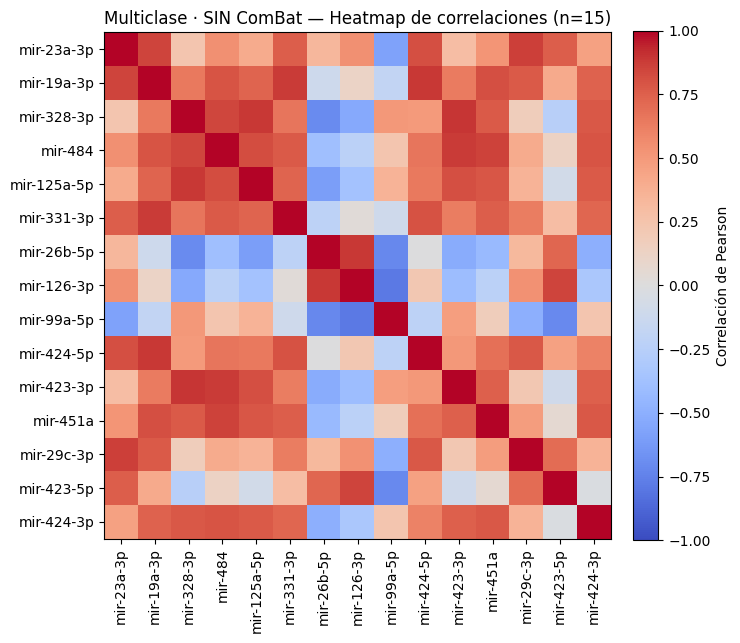

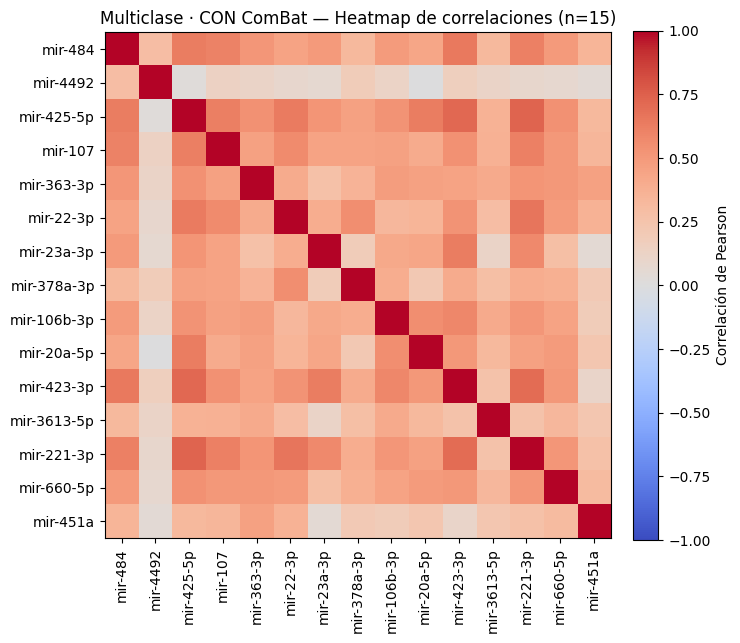

In [167]:
# ===========================================
# Heatmap de correlaciones — Panel final (5c)
# ===========================================

# Matriz base SIN ComBat (muestras × miRNA) alineada a etiquetas válidas.
def _build_base_matrix_sin():
    if 'Xf_sin' in globals() and isinstance(Xf_sin, pd.DataFrame):
        return Xf_sin.copy()
    # reconstruyo desde X_all
    y_5c_loc = meta_all.set_index("sample_id")["label_5c"].reindex(X_all.index)
    mask_valid = y_5c_loc.notna()
    return X_all.loc[mask_valid].copy()

# Matriz base CON ComBat (muestras × miRNA) alineada a etiquetas válidas.
def _build_base_matrix_con():
    if 'Xf_con' in globals() and isinstance(Xf_con, pd.DataFrame):
        return Xf_con.copy()
    if "Xc_scaled_df" in globals():
        y_5c_loc = meta_all.set_index("sample_id")["label_5c"].reindex(Xc_scaled_df.index)
        mask_valid = y_5c_loc.notna()
        return Xc_scaled_df.loc[mask_valid].copy()
    return None

# Dibuja heatmap de correlación (Pearson) para el set de features dado.
def _plot_corr_heatmap(X_base: pd.DataFrame, features: list, title_prefix: str):
    feats = [f for f in features if f in X_base.columns]
    if len(feats) < 2:
        print(f"[{title_prefix}] No hay suficientes características en el panel para un heatmap (se requieren ≥2).")
        return
    corr = X_base[feats].corr(method='pearson')

    plt.figure(figsize=(max(6, 0.5*len(feats)), max(5, 0.5*len(feats))))
    im = plt.imshow(corr.values, vmin=-1, vmax=1, cmap='coolwarm')
    plt.colorbar(im, fraction=0.046, pad=0.04, label='Correlación de Pearson')
    plt.xticks(ticks=np.arange(len(feats)), labels=feats, rotation=90)
    plt.yticks(ticks=np.arange(len(feats)), labels=feats)
    plt.title(f"{title_prefix} — Heatmap de correlaciones (n={len(feats)})")
    plt.tight_layout()

    # Me la guardo para la memoria
    plt.tight_layout()
    plt.savefig(f"/content/global_corr_pearson_panel15_{title_prefix}.png", dpi=300, bbox_inches="tight")
    plt.show()

panels = []

# SIN ComBat
if 'panel_5c_sincombat_final' in globals() and isinstance(panel_5c_sincombat_final, (list, tuple)) and len(panel_5c_sincombat_final) > 0:
    X_base_sin = _build_base_matrix_sin()
    panels.append(("Multiclase · SIN ComBat", X_base_sin, list(panel_5c_sincombat_final)))

# CON ComBat
if 'panel_5c_concombat_final' in globals() and isinstance(panel_5c_concombat_final, (list, tuple)) and len(panel_5c_concombat_final) > 0:
    X_base_con = _build_base_matrix_con()
    if X_base_con is not None:
        panels.append(("Multiclase · CON ComBat", X_base_con, list(panel_5c_concombat_final)))

# Viaulización
for title, X_base, feats in panels:
  _plot_corr_heatmap(X_base, feats, title_prefix=title)


#### **Log2FC y tamaño de efecto (Cohen´s d) en One-vs-all**

Mientras que **ANOVA, Kruskal o MI** indican si hay **diferencias globales entre grupos**, no muestran qué grupo concreto está impulsando esas diferencias ni la magnitud de los cambios.

Por ello, voy a calcular el **log2 Fold Change (log2FC)** y el **tamaño de efecto (Cohen´s d)** en un **esquema one-vs-all**, haciendo una comparación entre las dos clases y permitiendo identificar miARNs sobreexpresados o infraexpresados en un grupo concreto.

##### **Log2FC one-vs-all**

Los **valores positivos** de log2FC indican **sobreexpresión** en la clase frente al resto. Por otro lado, los **negativos**, expresan **infraexpresión relativa**.

[SIN ComBat] Coincidencias panel: 15/15


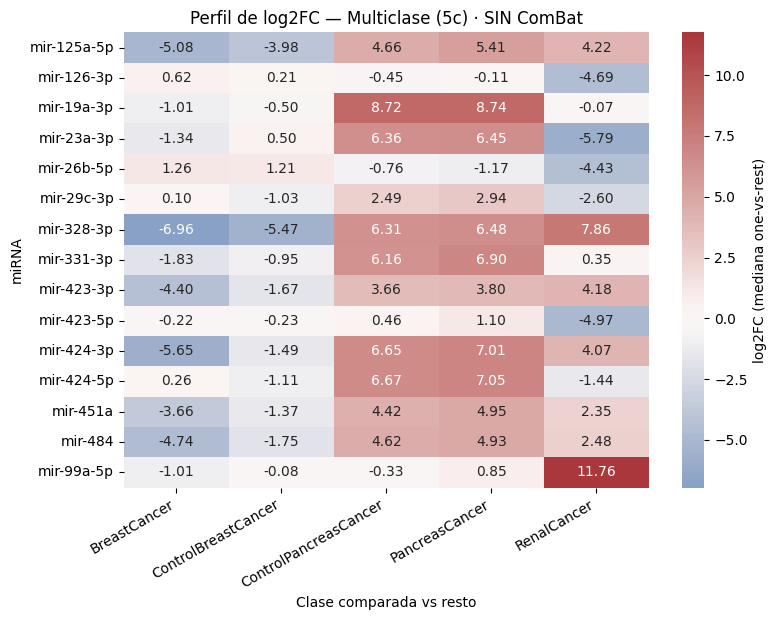

[CON ComBat] Coincidencias panel: 15/15


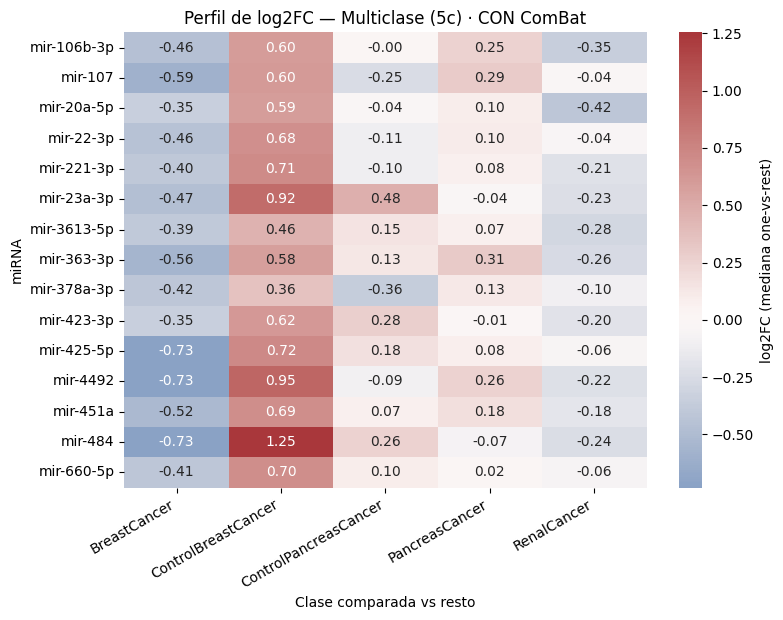

In [168]:
# =========================================
# Efectos de tamaño (log2FC) + (5 clases)
# =========================================

# Utilidad: tabla de efectos (one-vs-rest)
def effect_table(X_df, y_series, miRNAs=None):
    if miRNAs is None:
        miRNAs = X_df.columns
    classes = pd.unique(y_series)
    rows = []
    for m in miRNAs:
        x_m = X_df[m].values
        for c in classes:
            g1 = X_df.loc[y_series == c, m].values
            g0 = X_df.loc[y_series != c, m].values
            # log2FC (mediana g1 - mediana g0)
            log2fc = (np.median(g1) - np.median(g0)) if (g1.size > 0 and g0.size > 0) else np.nan
            # Cohen's d (pooled SD)
            s1, s0 = np.std(g1, ddof=1), np.std(g0, ddof=1)
            n1, n0 = len(g1), len(g0)
            sp = np.sqrt(((n1-1)*s1**2 + (n0-1)*s0**2) / (n1+n0-2)) if (n1+n0-2) > 0 else np.nan
            d = (np.mean(g1) - np.mean(g0)) / sp if (sp is not None and sp > 0) else np.nan
            rows.append((m, c, log2fc, d, n1, n0))
    return pd.DataFrame(rows, columns=["miRNA","class","log2FC_median","cohens_d","n_class","n_other"])

# Helpers para matrices base 5c
def _base_matrix_sin():
    # Usa la misma base que la poda de correlación si existe
    if 'Xf_sin' in globals() and isinstance(Xf_sin, pd.DataFrame):
        return Xf_sin.copy()
    y5 = meta_all.set_index("sample_id")["label_5c"].reindex(X_all.index)
    return X_all.loc[y5.notna()].copy()

def _base_matrix_con():
    if 'Xf_con' in globals() and isinstance(Xf_con, pd.DataFrame):
        return Xf_con.copy()
    if "Xc_scaled_df" in globals():
        y5 = meta_all.set_index("sample_id")["label_5c"].reindex(Xc_scaled_df.index)
        return Xc_scaled_df.loc[y5.notna()].copy()
    return None

def _labels_for(index_like):
    return meta_all.set_index("sample_id")["label_5c"].reindex(index_like)

def _plot_effect_heatmap(res_effects, title):
    heat_df = res_effects.pivot(index="miRNA", columns="class", values="log2FC_median")
    plt.figure(figsize=(8, max(6, 0.42*len(heat_df.index))))
    sns.heatmap(heat_df, cmap="vlag", center=0, annot=True, fmt=".2f",
                cbar_kws={"label":"log2FC (mediana one-vs-rest)"})
    plt.title(title)
    plt.ylabel("miRNA"); plt.xlabel("Clase comparada vs resto")
    plt.xticks(rotation=30, ha="right")

    # Me las guardo para la memoria
    plt.tight_layout()
    plt.savefig(f"/content/global_cohens_panel15_{title}.png", dpi=300, bbox_inches="tight")
    plt.show()

# ============
# SIN ComBat
# ============
X_base_sin = _base_matrix_sin()
y_sin = _labels_for(X_base_sin.index)

# Panel SIN ComBat (si existe), si no, uso el general
if 'panel_5c_sincombat_final' in globals() and isinstance(panel_5c_sincombat_final, (list, tuple)) and len(panel_5c_sincombat_final) > 0:
    panel_sin = [m for m in panel_5c_sincombat_final if m in X_base_sin.columns]
    print(f"[SIN ComBat] Coincidencias panel: {len(panel_sin)}/{len(panel_5c_sincombat_final)}")
else:
    panel_sin = [c for c in X_base_sin.columns][:15]
    print(f"[SIN ComBat] No se encontró 'panel_5c_sincombat_final'. Usando fallback de {len(panel_sin)} features.")

# Seguridad básica: NaNs -> mediana --> No hace falta pero por sia caso
if X_base_sin.isna().any().any():
    X_base_sin = X_base_sin.fillna(X_base_sin.median())

res_effects_sin = effect_table(X_base_sin, y_sin, miRNAs=panel_sin)
_plot_effect_heatmap(res_effects_sin, "Perfil de log2FC — Multiclase (5c) · SIN ComBat")

# Variables de salida
effects_5c_sincombat_df = res_effects_sin.copy()

# ============
# CON ComBat
# ============
X_base_con = _base_matrix_con()
if X_base_con is not None:
    y_con = _labels_for(X_base_con.index)

    if 'panel_5c_concombat_final' in globals() and isinstance(panel_5c_concombat_final, (list, tuple)) and len(panel_5c_concombat_final) > 0:
        panel_con = [m for m in panel_5c_concombat_final if m in X_base_con.columns]
        print(f"[CON ComBat] Coincidencias panel: {len(panel_con)}/{len(panel_5c_concombat_final)}")
    else:
        panel_con = [c for c in X_base_con.columns][:15]
        print(f"[CON ComBat] No se encontró 'panel_5c_concombat_final'. Usando fallback de {len(panel_con)} features.")

    if X_base_con.isna().any().any():
        X_base_con = X_base_con.fillna(X_base_con.median())

    res_effects_con = effect_table(X_base_con, y_con, miRNAs=panel_con)
    _plot_effect_heatmap(res_effects_con, "Perfil de log2FC — Multiclase (5c) · CON ComBat")

    # Variables de salida
    effects_5c_concombat_df = res_effects_con.copy()
else:
    print("No se detectó 'Xc_scaled_df',  se omite el bloque CON ComBat.")


##### **Cohen's d one-vs-all**

El **log2FC** indica la **dirección y magnitud cruda de la diferencia**, pero puede verse afectado por la escala de los datos. No obstante, el **Cohen’s d**, mide la **diferencia estandarizada** (diferencia de medias / desviación combinada).

- d ≈ 0.2 → efecto pequeño
- d ≈ 0.5 → efecto moderado
- d ≥ 0.8 → efecto grande

Esto lo hace más comparable y útil para priorizar biomarcadores.

[SIN ComBat] Cohen's d para panel (15 miARNs).


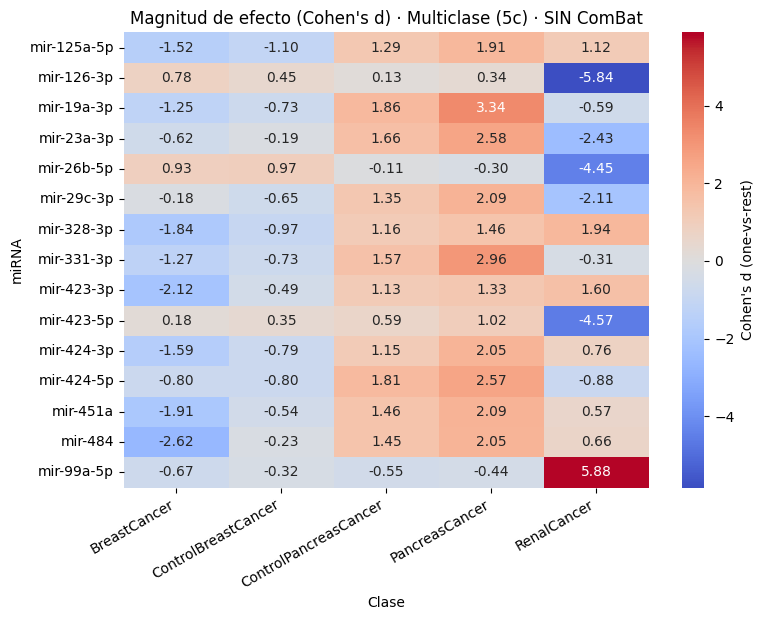

[CON ComBat] Cohen's d para panel (15 miARNs).


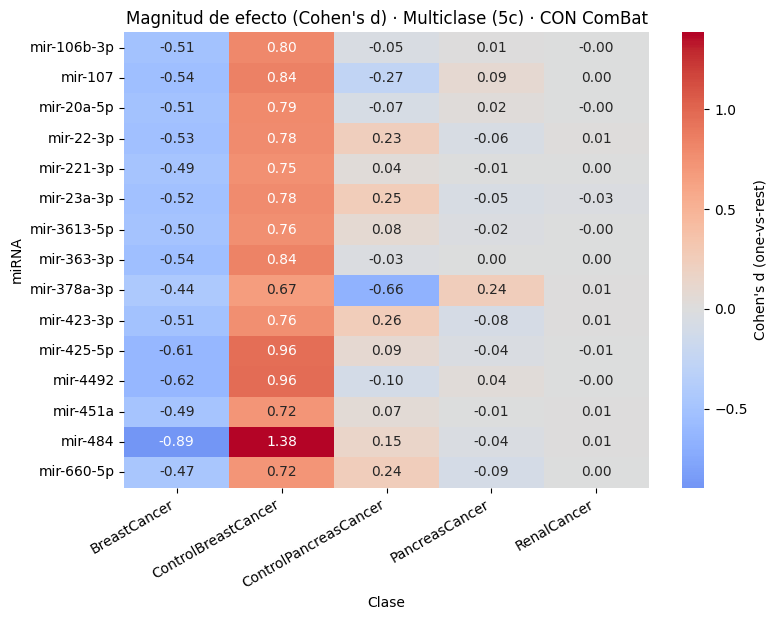

In [169]:
# =========================================
# Tamaños de efecto (Cohen's d) + (5 clases)
# =========================================

def _base_matrix_sin():
    if 'Xf_sin' in globals() and isinstance(Xf_sin, pd.DataFrame):
        return Xf_sin.copy()
    y5 = meta_all.set_index("sample_id")["label_5c"].reindex(X_all.index)
    return X_all.loc[y5.notna()].copy()

def _base_matrix_con():
    if 'Xf_con' in globals() and isinstance(Xf_con, pd.DataFrame):
        return Xf_con.copy()
    if "Xc_scaled_df" in globals():
        y5 = meta_all.set_index("sample_id")["label_5c"].reindex(Xc_scaled_df.index)
        return Xc_scaled_df.loc[y5.notna()].copy()
    return None

def _labels_for(index_like):
    return meta_all.set_index("sample_id")["label_5c"].reindex(index_like)

def _plot_cohen_heatmap(X_base, y_ser, panel_list, title):
    panel = [m for m in panel_list if m in X_base.columns]
    if len(panel) == 0:
        print(f"[{title}] No hay miRNAs del panel en la matriz base.")
        return
    # Seguridad: NaNs -> mediana
    if X_base.isna().any().any():
        X_base = X_base.fillna(X_base.median())

    res_effects = effect_table(X_base, y_ser, miRNAs=panel)  # usa la función definida antes
    heat_d = res_effects.pivot(index="miRNA", columns="class", values="cohens_d")

    plt.figure(figsize=(8, max(6, 0.42*len(panel))))
    sns.heatmap(heat_d, cmap="coolwarm", center=0, annot=True, fmt=".2f",
                cbar_kws={"label":"Cohen's d (one-vs-rest)"})
    plt.title(title)
    plt.ylabel("miRNA"); plt.xlabel("Clase")
    plt.xticks(rotation=30, ha="right")

    # Me las guardo para la memoria
    plt.tight_layout()
    plt.savefig(f"/content/global_cohens_panel15_{title}.png", dpi=300, bbox_inches="tight")
    plt.show()


# ===================
# SIN ComBat
# ===================
X_base_sin = _base_matrix_sin()
y_sin = _labels_for(X_base_sin.index)

if 'panel_5c_sincombat_final' in globals() and isinstance(panel_5c_sincombat_final, (list, tuple)) and len(panel_5c_sincombat_final) > 0:
    print(f"[SIN ComBat] Cohen's d para panel ({len(panel_5c_sincombat_final)} miARNs).")
    _plot_cohen_heatmap(X_base_sin, y_sin, list(panel_5c_sincombat_final),
                        "Magnitud de efecto (Cohen's d) · Multiclase (5c) · SIN ComBat")
else:
    print("[SIN ComBat] No se encontró 'panel_5c_sincombat_final'. (Ejecuta el bloque del panel candidato).")

# ===================
# CON ComBat
# ===================
X_base_con = _base_matrix_con()
if X_base_con is not None:
    y_con = _labels_for(X_base_con.index)
    if 'panel_5c_concombat_final' in globals() and isinstance(panel_5c_concombat_final, (list, tuple)) and len(panel_5c_concombat_final) > 0:
        print(f"[CON ComBat] Cohen's d para panel ({len(panel_5c_concombat_final)} miARNs).")
        _plot_cohen_heatmap(X_base_con, y_con, list(panel_5c_concombat_final),
                            "Magnitud de efecto (Cohen's d) · Multiclase (5c) · CON ComBat")
    else:
        print("[CON ComBat] No se encontró 'panel_5c_concombat_final'.")
else:
    print("No se detectó 'Xc_scaled_df', se omite el bloque CON ComBat.")


### **Métodos embebidos**

#### **Logistic Regression con regularización**

Los modelos de **regresión logística regularizada** utilizan penalizaciones sobre los coeficientes para controlar la complejidad del modelo y **seleccionar las variables más informativas**:

- **Regularización L2 (Ridge)**: Penaliza el cuadrado de los coeficientes, reduciendo su magnitud pero **sin anularlos por completo**.
Tiende a distribuir el peso entre múltiples miARNs correlacionados, favoreciendo **modelos estables y menos sensibles al ruido**.
Los coeficientes de mayor valor absoluto representan miARNs con **mayor influencia global en la predicción de las clases**.

- **Regularización L1 (Lasso)**: Penaliza el valor absoluto de los coeficientes, llevando algunos **exactamente a cero**.
Esto permite realizar selección automática de características, **conservando solo los miARNs con contribución significativa**. Un miARN con coeficiente diferente a 0 se considera relevante porque **aporta información exclusiva que mejora la separación entre las clases**.

- **Elastic Net (mezcla L1 + L2)**: Combina ambas penalizaciones para **equilibrar parsimonia (pocos miARNs) y robustez frente a la multicolinealidad**. Es especialmente útil cuando existen miARNs altamente correlacionados, ya que permite conservar subconjuntos complementarios en lugar de eliminar uno solo arbitrariamente.

La comparación de estos tres enfoques permite observar **qué miARNs mantienen un peso elevado de forma consistente**.
Además, la métrica Balanced Accuracy (CV media) cuantifica la capacidad del modelo para clasificar correctamente las cinco clases, corrigiendo posibles desequilibrios en la frecuencia de cada grupo.

In [170]:
# =============================================================
# Embedded feature selection · Logistic Regression (5 clases)
# =============================================================

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Devuelve coeficientes por feature, en multiclase (multinomial): coef_.shape = (n_clases, n_features)
def coef_df(clf, feature_names):
    coef = clf.coef_                      # (k, p) o (1, p)
    classes = clf.classes_
    if coef.shape[0] == 1:
        colnames = [str(classes[1]) if len(classes) >= 2 else "class1"]
    else:
        colnames = [str(c) for c in classes]
    df = pd.DataFrame(coef.T, index=feature_names, columns=colnames)
    df["coef_abs_mean"] = df.abs().mean(axis=1)
    return df.sort_values("coef_abs_mean", ascending=False)

#  LogisticRegressionCV.scores_:
#     - En OvR: dict por clase.
#     - En multinomial: array (n_folds, n_Cs) o (n_folds, n_Cs, n_l1_ratios).
# Esta función promedia correctamente en ambos casos.
def mean_cv_score(clf):
    s = clf.scores_
    if isinstance(s, dict):
        return float(np.mean([arr.mean() for arr in s.values()]))
    else:
        return float(np.mean(np.array(s)))

def _prepare_block(X_base: pd.DataFrame, y_base: pd.Series, features_panel: list):
    feats = [f for f in features_panel if f in X_base.columns]
    if len(feats) == 0:
        raise RuntimeError("Ninguna feature del panel está presente en la matriz base.")
    X_emb = X_base[feats].copy()
    if X_emb.isna().any().any():
        X_emb = X_emb.fillna(X_emb.median())
    return X_emb, y_base.reindex(X_emb.index), feats

# ============
# SIN ComBat
# ============
# Matriz base y etiquetas 5c
y_5c = meta_all.set_index("sample_id")["label_5c"].reindex(X_all.index)
mask_valid = y_5c.notna()
X_base_sin = X_all.loc[mask_valid].copy()
y_base_sin = y_5c.loc[mask_valid].copy()
X_emb_sin, y_emb_sin, features_panel_sin = _prepare_block(X_base_sin, y_base_sin, list(panel_5c_sincombat_final))

# L2 (baseline, estable)
pipe_l2_sin = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegressionCV(
        Cs=np.logspace(-3, 3, 15),
        penalty="l2",
        solver="lbfgs",                 # multinomial
        class_weight="balanced",
        cv=cv,
        scoring="balanced_accuracy",    # robusto a desbalanceo en multiclase
        max_iter=8000,
        n_jobs=None,
        refit=True,
        multi_class="multinomial",
        random_state=42
    ))
])

pipe_l2_sin.fit(X_emb_sin, y_emb_sin)
clf_l2_sin = pipe_l2_sin.named_steps["clf"]
coefs_l2_sorted_5c_sin = coef_df(clf_l2_sin, features_panel_sin)
ba_l2_sin = mean_cv_score(clf_l2_sin)

print("=== L2 (baseline) · Top 15 por |coef| medio · SIN ComBat ===")
display(coefs_l2_sorted_5c_sin.head(15))
print(f"Balanced Accuracy (CV media): {ba_l2_sin:.3f}")

# L1 (sparse) para selección
pipe_l1_sin = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegressionCV(
        Cs=np.logspace(-3, 3, 15),
        penalty="l1",
        solver="saga",                  # necesario para L1 en multinomial
        class_weight="balanced",
        cv=cv,
        scoring="balanced_accuracy",
        max_iter=12000,
        n_jobs=None,
        refit=True,
        multi_class="multinomial",
        random_state=42
    ))
])

pipe_l1_sin.fit(X_emb_sin, y_emb_sin)
clf_l1_sin = pipe_l1_sin.named_steps["clf"]
coefs_l1_sorted_5c_sin = coef_df(clf_l1_sin, features_panel_sin)

selected_l1_5c_sin = coefs_l1_sorted_5c_sin.drop(columns=["coef_abs_mean"]).abs().sum(axis=1)
selected_l1_5c_sin = selected_l1_5c_sin[selected_l1_5c_sin > 0].index.tolist()
ba_l1_sin = mean_cv_score(clf_l1_sin)

print("\n=== L1 (sparse) · Selección real · SIN ComBat ===")
print(f"Features con coeficiente ≠ 0: {len(selected_l1_5c_sin)}")
display(coefs_l1_sorted_5c_sin.loc[selected_l1_5c_sin].head(15))
print(f"Balanced Accuracy (CV media): {ba_l1_sin:.3f}")

# Elastic Net (SAGA) – mezcla suave de L1 y L2
pipe_en_sin = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegressionCV(
        Cs=np.logspace(-3, 3, 15),
        penalty="elasticnet",
        solver="saga",
        l1_ratios=[0.1, 0.3, 0.5],      # suaves para evitar "todo 0" (antes estaban más altos y salía alguno)
        class_weight="balanced",
        cv=cv,
        scoring="balanced_accuracy",
        max_iter=15000,
        n_jobs=None,
        refit=True,
        multi_class="multinomial",
        random_state=42
    ))
])

pipe_en_sin.fit(X_emb_sin, y_emb_sin)
clf_en_sin = pipe_en_sin.named_steps["clf"]
coefs_en_sorted_5c_sin = coef_df(clf_en_sin, features_panel_sin)

selected_en_5c_sin = coefs_en_sorted_5c_sin.drop(columns=["coef_abs_mean"]).abs().sum(axis=1)
selected_en_5c_sin = selected_en_5c_sin[selected_en_5c_sin > 0].index.tolist()
ba_en_sin = mean_cv_score(clf_en_sin)

print("\n=== Elastic Net (saga) · SIN ComBat ===")
print(f"Features con coeficiente ≠ 0: {len(selected_en_5c_sin)}")
display(coefs_en_sorted_5c_sin.loc[selected_en_5c_sin].head(15))
print(f"Balanced Accuracy (CV media): {ba_en_sin:.3f}")

# =============
# CON ComBat
# =============
if "Xc_scaled_df" in globals():
    y_5c_c = meta_all.set_index("sample_id")["label_5c"].reindex(Xc_scaled_df.index)
    mask_valid_c = y_5c_c.notna()
    X_base_con = Xc_scaled_df.loc[mask_valid_c].copy()
    y_base_con = y_5c_c.loc[mask_valid_c].copy()

    X_emb_con, y_emb_con, features_panel_con = _prepare_block(X_base_con, y_base_con, list(panel_5c_concombat_final))

    # L2
    pipe_l2_con = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", LogisticRegressionCV(
            Cs=np.logspace(-3, 3, 15),
            penalty="l2",
            solver="lbfgs",
            class_weight="balanced",
            cv=cv,
            scoring="balanced_accuracy",
            max_iter=8000,
            n_jobs=None,
            refit=True,
            multi_class="multinomial",
            random_state=42
        ))
    ])
    pipe_l2_con.fit(X_emb_con, y_emb_con)
    clf_l2_con = pipe_l2_con.named_steps["clf"]
    coefs_l2_sorted_5c_con = coef_df(clf_l2_con, features_panel_con)
    ba_l2_con = mean_cv_score(clf_l2_con)

    print("\n=== L2 (baseline) · CON ComBat ===")
    display(coefs_l2_sorted_5c_con.head(15))
    print(f"Balanced Accuracy (CV media): {ba_l2_con:.3f}")

    # L1
    pipe_l1_con = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", LogisticRegressionCV(
            Cs=np.logspace(-3, 3, 15),
            penalty="l1",
            solver="saga",
            class_weight="balanced",
            cv=cv,
            scoring="balanced_accuracy",
            max_iter=12000,
            n_jobs=None,
            refit=True,
            multi_class="multinomial",
            random_state=42
        ))
    ])
    pipe_l1_con.fit(X_emb_con, y_emb_con)
    clf_l1_con = pipe_l1_con.named_steps["clf"]
    coefs_l1_sorted_5c_con = coef_df(clf_l1_con, features_panel_con)
    selected_l1_5c_con = coefs_l1_sorted_5c_con.drop(columns=["coef_abs_mean"]).abs().sum(axis=1)
    selected_l1_5c_con = selected_l1_5c_con[selected_l1_5c_con > 0].index.tolist()
    ba_l1_con = mean_cv_score(clf_l1_con)

    print("\n=== L1 (sparse) · CON ComBat ===")
    print(f"Features con coeficiente ≠ 0: {len(selected_l1_5c_con)}")
    display(coefs_l1_sorted_5c_con.loc[selected_l1_5c_con].head(15))
    print(f"Balanced Accuracy (CV media): {ba_l1_con:.3f}")

    # Elastic Net
    pipe_en_con = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", LogisticRegressionCV(
            Cs=np.logspace(-3, 3, 15),
            penalty="elasticnet",
            solver="saga",
            l1_ratios=[0.1, 0.3, 0.5],
            class_weight="balanced",
            cv=cv,
            scoring="balanced_accuracy",
            max_iter=15000,
            n_jobs=None,
            refit=True,
            multi_class="multinomial",
            random_state=42
        ))
    ])
    pipe_en_con.fit(X_emb_con, y_emb_con)
    clf_en_con = pipe_en_con.named_steps["clf"]
    coefs_en_sorted_5c_con = coef_df(clf_en_con, features_panel_con)
    selected_en_5c_con = coefs_en_sorted_5c_con.drop(columns=["coef_abs_mean"]).abs().sum(axis=1)
    selected_en_5c_con = selected_en_5c_con[selected_en_5c_con > 0].index.tolist()
    ba_en_con = mean_cv_score(clf_en_con)

    print("\n=== Elastic Net (saga) · CON ComBat ===")
    print(f"Features con coeficiente ≠ 0: {len(selected_en_5c_con)}")
    display(coefs_en_sorted_5c_con.loc[selected_en_5c_con].head(15))
    print(f"Balanced Accuracy (CV media): {ba_en_con:.3f}")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== L2 (baseline) · Top 15 por |coef| medio · SIN ComBat ===


BreastCancer  ControlBreastCancer  ControlPancreasCancer  \
mir-484         -1.427626             0.833431               0.373976   
mir-29c-3p       0.780691            -0.940702               0.245660   
mir-126-3p       0.612207            -0.138923              -0.475309   
mir-423-5p       0.106928             0.033890              -0.573429   
mir-424-5p       0.188941            -0.510885               0.825150   
mir-23a-3p      -0.539614             0.204857               0.565133   
mir-26b-5p      -0.220352             0.838456               0.107251   
mir-423-3p      -0.704627             0.118716               0.437973   
mir-331-3p      -0.303474            -0.251394              -0.169056   
mir-328-3p      -0.237972            -0.523499               0.450132   
mir-19a-3p      -0.309078            -0.282628               0.275204   
mir-451a        -0.713939             0.211402               0.206543   
mir-99a-5p      -0.320303             0.129604              -0.342190   
mir-125a-5p      0.024340            -0.671016               0.248301   
mir-424-3p      -0.306999            -0.322200               0.047182   

             PancreasCancer  RenalCancer  coef_abs_mean  
mir-484            0.152936     0.067283       0.571050  
mir-29c-3p         0.257252    -0.342902       0.513441  
mir-126-3p         0.514214    -0.512189       0.450568  
mir-423-5p         0.957749    -0.525138       0.439427  
mir-424-5p        -0.303375    -0.199831       0.405636  
mir-23a-3p         0.195847    -0.426223       0.386335  
mir-26b-5p        -0.234662    -0.490694       0.378283  
mir-423-3p        -0.127471     0.275409       0.332839  
mir-331-3p         0.817717    -0.093793       0.327087  
mir-328-3p         0.009329     0.302010       0.304588  
mir-19a-3p         0.463306    -0.146805       0.295404  
mir-451a           0.217962     0.078032       0.285576  
mir-99a-5p        -0.014017     0.546907       0.270604  
mir-125a-5p        0.224002     0.174373       0.268407  
mir-424-3p         0.464888     0.117129       0.251680

Balanced Accuracy (CV media): 0.786


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== L1 (sparse) · Selección real · SIN ComBat ===
Features con coeficiente ≠ 0: 15


BreastCancer  ControlBreastCancer  ControlPancreasCancer  \
mir-423-5p       0.000000             0.740133              -1.067568   
mir-484         -5.541688             0.000000               2.915152   
mir-125a-5p      0.000000            -2.957298               3.696958   
mir-328-3p      -0.455937             0.000000               6.819019   
mir-29c-3p       2.271357            -3.329930               1.127621   
mir-126-3p       3.837321             0.000000              -0.172141   
mir-19a-3p      -2.855236             0.103011               0.000000   
mir-424-5p       0.948971            -1.027983               3.454148   
mir-26b-5p       0.000000             4.542172              -0.398775   
mir-23a-3p      -2.132909             0.000000               2.815376   
mir-331-3p      -0.418440             0.000000               0.000000   
mir-99a-5p      -1.670155             0.025387              -0.324196   
mir-423-3p       0.000000             0.000000               1.998649   
mir-451a        -1.372932             0.000000               0.000000   
mir-424-3p       0.000000            -0.118356               0.000000   

             PancreasCancer  RenalCancer  coef_abs_mean  
mir-423-5p         6.286774    -0.646522       1.748199  
mir-484           -0.055744     0.000000       1.702517  
mir-125a-5p       -1.349440     0.000000       1.600739  
mir-328-3p        -0.711346     0.000000       1.597260  
mir-29c-3p         0.000000     0.000000       1.345782  
mir-126-3p         2.259640    -0.127495       1.279319  
mir-19a-3p         2.501232     0.000000       1.091896  
mir-424-5p         0.000000     0.000000       1.086220  
mir-26b-5p         0.351133     0.000000       1.058416  
mir-23a-3p         0.000000     0.000000       0.989657  
mir-331-3p         2.484266     0.000000       0.580541  
mir-99a-5p         0.000000     0.774160       0.558780  
mir-423-3p        -0.636481     0.000000       0.527026  
mir-451a           0.438482     0.000000       0.362283  
mir-424-3p         0.916451     0.000000       0.206961

Balanced Accuracy (CV media): 0.668


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Elastic Net (saga) · SIN ComBat ===
Features con coeficiente ≠ 0: 15


BreastCancer  ControlBreastCancer  ControlPancreasCancer  \
mir-484         -1.530944             0.817467               0.334640   
mir-29c-3p       0.753870            -0.942257               0.186430   
mir-126-3p       0.611565            -0.047787              -0.437553   
mir-423-5p       0.043553             0.000000              -0.513623   
mir-424-5p       0.139499            -0.509116               0.857068   
mir-26b-5p      -0.140686             0.875070               0.082532   
mir-23a-3p      -0.527725             0.118413               0.573259   
mir-423-3p      -0.729745             0.034496               0.420942   
mir-331-3p      -0.243009            -0.194494              -0.081595   
mir-328-3p      -0.179863            -0.509940               0.410754   
mir-19a-3p      -0.257977            -0.230994               0.246396   
mir-99a-5p      -0.282363             0.068495              -0.327597   
mir-451a        -0.737054             0.136644               0.142772   
mir-125a-5p      0.000000            -0.672356               0.164302   
mir-424-3p      -0.272966            -0.288416               0.003511   

             PancreasCancer  RenalCancer  coef_abs_mean  
mir-484            0.079927     0.000000       0.552596  
mir-29c-3p         0.208579    -0.317304       0.481688  
mir-126-3p         0.496938    -0.512433       0.421255  
mir-423-5p         0.987677    -0.531505       0.415272  
mir-424-5p        -0.234260    -0.142801       0.376549  
mir-26b-5p        -0.222107    -0.483380       0.360755  
mir-23a-3p         0.139338    -0.413812       0.354510  
mir-423-3p        -0.056952     0.220163       0.292460  
mir-331-3p         0.861641    -0.010405       0.278229  
mir-328-3p         0.000000     0.253635       0.270838  
mir-19a-3p         0.429749    -0.076064       0.248236  
mir-99a-5p         0.000000     0.553868       0.246465  
mir-451a           0.148315     0.000000       0.232957  
mir-125a-5p        0.179808     0.097454       0.222784  
mir-424-3p         0.418679     0.032405       0.203195

Balanced Accuracy (CV media): 0.711


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== L2 (baseline) · CON ComBat ===


BreastCancer  ControlBreastCancer  ControlPancreasCancer  \
mir-484         -0.722976             1.387459              -0.229134   
mir-4492        -0.548797             1.175156              -0.258751   
mir-22-3p       -0.348355             0.174698               0.709378   
mir-378a-3p     -0.132332             0.507522              -0.682901   
mir-660-5p      -0.196956             0.213277               0.468592   
mir-20a-5p      -0.246634             0.610004              -0.338163   
mir-3613-5p     -0.251558             0.477398               0.081829   
mir-221-3p       0.269920            -0.075384              -0.449830   
mir-363-3p      -0.072024             0.505522              -0.264947   
mir-107          0.138851             0.063479              -0.453007   
mir-423-3p       0.144851            -0.217865               0.299800   
mir-23a-3p      -0.271062             0.088685               0.330449   
mir-425-5p      -0.154222             0.362830               0.054592   
mir-451a        -0.163616            -0.094292               0.257325   
mir-106b-3p     -0.061024             0.107015              -0.042101   

             PancreasCancer  RenalCancer  coef_abs_mean  
mir-484           -0.218422    -0.216928       0.554984  
mir-4492          -0.186548    -0.181060       0.470062  
mir-22-3p         -0.419137    -0.116583       0.353630  
mir-378a-3p        0.358265    -0.050554       0.346315  
mir-660-5p        -0.304285    -0.180628       0.272748  
mir-20a-5p         0.032420    -0.057627       0.256970  
mir-3613-5p       -0.181711    -0.125957       0.223691  
mir-221-3p         0.160432     0.094862       0.210086  
mir-363-3p        -0.080576    -0.087975       0.202209  
mir-107            0.244802     0.005875       0.181203  
mir-423-3p        -0.180989    -0.045797       0.177861  
mir-23a-3p        -0.071682    -0.076390       0.167653  
mir-425-5p        -0.159591    -0.103609       0.166969  
mir-451a          -0.001390     0.001972       0.103719  
mir-106b-3p       -0.010325     0.006436       0.045380

Balanced Accuracy (CV media): 0.419


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== L1 (sparse) · CON ComBat ===
Features con coeficiente ≠ 0: 15


BreastCancer  ControlBreastCancer  ControlPancreasCancer  \
mir-484         -0.534880             2.309303               0.000000   
mir-4492        -0.350160             1.673947              -0.058634   
mir-378a-3p     -0.079972             0.729172              -0.657611   
mir-22-3p       -0.209394             0.192417               0.982485   
mir-20a-5p      -0.223803             0.933574              -0.277803   
mir-3613-5p     -0.121099             0.762081               0.198880   
mir-363-3p       0.000000             0.790928              -0.181805   
mir-660-5p       0.000000             0.201879               0.647173   
mir-423-3p       0.165615            -0.198250               0.388955   
mir-221-3p       0.144455             0.000000              -0.625739   
mir-107          0.071368             0.000000              -0.491286   
mir-23a-3p      -0.176084             0.024378               0.362044   
mir-451a        -0.134460            -0.106097               0.278604   
mir-425-5p       0.000000             0.221619               0.116568   
mir-106b-3p     -0.000520             0.000000               0.000000   

             PancreasCancer  RenalCancer  coef_abs_mean  
mir-484            0.000000          0.0       0.568837  
mir-4492           0.000000          0.0       0.416548  
mir-378a-3p        0.408111          0.0       0.374973  
mir-22-3p         -0.288759          0.0       0.334611  
mir-20a-5p         0.044354          0.0       0.295907  
mir-3613-5p       -0.031460          0.0       0.222704  
mir-363-3p         0.000000          0.0       0.194547  
mir-660-5p        -0.105146          0.0       0.190840  
mir-423-3p        -0.111430          0.0       0.172850  
mir-221-3p         0.018948          0.0       0.157829  
mir-107            0.189417          0.0       0.150414  
mir-23a-3p         0.000000          0.0       0.112501  
mir-451a           0.000000          0.0       0.103832  
mir-425-5p        -0.001812          0.0       0.068000  
mir-106b-3p        0.000000          0.0       0.000104

Balanced Accuracy (CV media): 0.368


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Elastic Net (saga) · CON ComBat ===
Features con coeficiente ≠ 0: 15


BreastCancer  ControlBreastCancer  ControlPancreasCancer  \
mir-484         -0.656497             2.049698              -0.100546   
mir-4492        -0.388773             1.589603              -0.085258   
mir-378a-3p     -0.087241             0.683196              -0.681338   
mir-22-3p       -0.305788             0.166377               0.954056   
mir-20a-5p      -0.229881             0.884795              -0.319082   
mir-660-5p      -0.115608             0.262527               0.609837   
mir-3613-5p     -0.204140             0.665639               0.145559   
mir-423-3p       0.218861            -0.298037               0.417584   
mir-221-3p       0.235104            -0.100024              -0.632933   
mir-363-3p       0.000000             0.785693              -0.219110   
mir-107          0.140256             0.000000              -0.490809   
mir-23a-3p      -0.209532             0.119177               0.396027   
mir-425-5p      -0.067826             0.386801               0.125342   
mir-451a        -0.149836            -0.180669               0.310010   
mir-106b-3p     -0.032612             0.000000               0.000000   

             PancreasCancer  RenalCancer  coef_abs_mean  
mir-484           -0.074093    -0.072141       0.590595  
mir-4492          -0.006554     0.000000       0.414038  
mir-378a-3p        0.439548    -0.005814       0.379428  
mir-22-3p         -0.385109    -0.034388       0.369144  
mir-20a-5p         0.065932    -0.011479       0.302234  
mir-660-5p        -0.231404    -0.104703       0.264816  
mir-3613-5p       -0.125064    -0.067850       0.241650  
mir-423-3p        -0.144690     0.000000       0.215834  
mir-221-3p         0.093886     0.013996       0.215189  
mir-363-3p         0.000000    -0.002038       0.201368  
mir-107            0.254557     0.000000       0.177124  
mir-23a-3p         0.000000    -0.003430       0.145633  
mir-425-5p        -0.066052    -0.019030       0.133010  
mir-451a           0.000000     0.000000       0.128103  
mir-106b-3p        0.000000     0.011313       0.008785

Balanced Accuracy (CV media): 0.390


In [171]:
# ==========================================
# Tabla resumen de resultados (L2, L1, EN)
# Multiclase (5c) · Balanced Accuracy (CV)
# ==========================================
def _safe_top(index_like, k=5):
    idx = list(index_like) if index_like is not None else []
    return ", ".join(idx[:k]) if len(idx) > 0 else "—"

def _build_summary(features_panel, coefs_l2_sorted, coefs_l1_sorted, coefs_en_sorted,
                   selected_l1, selected_en, ba_l2, ba_l1, ba_en):
    return pd.DataFrame({
        "Método": ["L2 (Ridge)", "L1 (Lasso)", "Elastic Net"],
        "Nº features": [
            len(features_panel),
            len(selected_l1),
            len(selected_en)
        ],
        "Balanced Acc. CV (media)": [ba_l2, ba_l1, ba_en],
        "Top 5 miARNs": [
            _safe_top(coefs_l2_sorted.head(5).index if coefs_l2_sorted is not None else []),
            _safe_top(coefs_l1_sorted.loc[selected_l1].head(5).index if (coefs_l1_sorted is not None and len(selected_l1)>0) else []),
            _safe_top(coefs_en_sorted.loc[selected_en].head(5).index if (coefs_en_sorted is not None and len(selected_en)>0) else []),
        ]
    })

# SIN ComBat
try:
    tabla_5c_sincombat = _build_summary(
        features_panel_sin,
        coefs_l2_sorted_5c_sin, coefs_l1_sorted_5c_sin, coefs_en_sorted_5c_sin,
        selected_l1_5c_sin, selected_en_5c_sin,
        ba_l2_sin, ba_l1_sin, ba_en_sin
    )
    print("=== Resumen · MULTICLASE (5c) · SIN ComBat ===")
    display(tabla_5c_sincombat)
except Exception as e:
    print(f"[SIN ComBat] No se pudo construir la tabla (¿faltan variables previas?): {e}")

# CON ComBat
if "Xc_scaled_df" in globals():
    try:
        tabla_5c_concombat = _build_summary(
            features_panel_con,
            coefs_l2_sorted_5c_con, coefs_l1_sorted_5c_con, coefs_en_sorted_5c_con,
            selected_l1_5c_con, selected_en_5c_con,
            ba_l2_con, ba_l1_con, ba_en_con
        )
        print("\n=== Resumen · MULTICLASE (5c) · CON ComBat ===")
        display(tabla_5c_concombat)
    except Exception as e:
        print(f"[CON ComBat] No se pudo construir la tabla (¿faltan variables previas?): {e}")


=== Resumen · MULTICLASE (5c) · SIN ComBat ===


Método  Nº features  Balanced Acc. CV (media)  \
0   L2 (Ridge)           15                  0.786462   
1   L1 (Lasso)           15                  0.667761   
2  Elastic Net           15                  0.711444   

                                        Top 5 miARNs  
0  mir-484, mir-29c-3p, mir-126-3p, mir-423-5p, m...  
1  mir-423-5p, mir-484, mir-125a-5p, mir-328-3p, ...  
2  mir-484, mir-29c-3p, mir-126-3p, mir-423-5p, m...


=== Resumen · MULTICLASE (5c) · CON ComBat ===


Método  Nº features  Balanced Acc. CV (media)  \
0   L2 (Ridge)           15                  0.419487   
1   L1 (Lasso)           15                  0.368117   
2  Elastic Net           15                  0.390373   

                                        Top 5 miARNs  
0  mir-484, mir-4492, mir-22-3p, mir-378a-3p, mir...  
1  mir-484, mir-4492, mir-378a-3p, mir-22-3p, mir...  
2  mir-484, mir-4492, mir-378a-3p, mir-22-3p, mir...

---
**Posible texto para la memoria**

---
Se han utilizado modelos lineales penalizados **(logistic regression con regularización)** para discriminar entre clases de un mismo dataset. En este caso el objetivo se centra más en seleccionar las *features* (miARNs) más relevantes biológicamente), antes que en la predicción de clases.

Para ello, he trabajado con las siguientes regularizaciones como mecanismos de selección:
  - **L2 (Ridge)**: no hace feature selection, pero estabiliza los coeficientes y da un ranking fiable de importancia.

  - **L1 (Lasso)**: fuerza a que muchos coeficientes sean exactamente cero, lo que resulta en una selección real de variables.

  - **Elastic Net**: combina L1 y L2, útil para datasets con correlación alta entre variables (como en este caso, miARNs). Permite selección más estable que L1 puro.

También hay que mencionar, que se ha realizado **validación cruzada estratificada** (5-fold CV con *roc_auc* como métrica), con el objetivo de reflejar en menor medida de los resultados el desbalanceo latente en las clases.

#### **Random Forest para selección de características**

El modelo **Random Forest** es un algoritmo de ensamblado no lineal que combina múltiples árboles de decisión entrenados sobre subconjuntos aleatorios de muestras y características.
Evalúa la **importancia de cada miARN a través de dos enfoques complementarios**:

- **Importancia Gini (impureza media)**: Mide cuánto disminuye la impureza de las divisiones de los árboles al incluir cada miARN.
Un **valor alto** indica que el **miARN contribuye de forma recurrente a dividir correctamente las clases**.
En otras palabras, los miARNs con mayor importancia Gini son aquellos que el modelo considera más útiles para reducir la heterogeneidad entre las categorías.

- **Permutation Importance (OOF, out-of-fold)**: Evalúa la pérdida de rendimiento del modelo cuando se permuta aleatoriamente una variable, calculada en los pliegues de validación (out-of-fold).
Este método **mide la dependencia real del modelo respecto a cada miARN**, sin sesgo por sobreajuste.
En este caso, los miARNs con **alta importancia de permutación** son los que **afectan más al rendimiento predictivo cuando se alteran**, y por tanto son esencialmente discriminativos.

Además, al calcular las importancias por fold y promediar los resultados, se obtiene una medida más estable y generalizable de la relevancia de cada miARN, evitando sobreajustes locales.

El modelo se evalúa mediante las métricas **F1-macro (rendimiento equilibrado entre clases) y AUC-ROC multiclase (ovr, weighted)**, que reflejan la capacidad global de clasificación.

In [194]:
# ===========================================================================
# Random Forest · Multiclase (5 clases) con Permutation OOF y comparativas:
#   - Evalúa ALL_FEATURES vs PANEL (no redundante)
#   - SIN ComBat (X_all) vs  CON ComBat (Xc_scaled_df)
# ===========================================================================

# Parámetros
N_SPLITS         = 5
N_ESTIMATORS     = 400
MIN_SAMPLES_LEAF = 2
MAX_FEATURES     = "sqrt"                 # "sqrt", "log2" o float
CLASS_WEIGHT     = "balanced_subsample"
SCORING_PERM     = "f1_macro"             # métrica para la permutación OOF
N_REPEATS_PERM   = 5                      # lo he tenido que bajar a 5 pq tardaba mucho
RANDOM_STATE     = 42

rf_params = dict(
    n_estimators=N_ESTIMATORS,
    random_state=RANDOM_STATE,
    class_weight=CLASS_WEIGHT,
    n_jobs=-1,
    max_features=MAX_FEATURES,
    min_samples_leaf=MIN_SAMPLES_LEAF,
    oob_score=False
)

# Función OOF permutation (multiclase)
def rf_cv_with_oof_permutation_multi(
    X: pd.DataFrame,
    y: pd.Series,
    n_splits=N_SPLITS,
    scoring_perm=SCORING_PERM,
    random_state=RANDOM_STATE,
    rf_kwargs: dict = None,
    n_repeats=N_REPEATS_PERM,
):
    rf_kwargs = rf_kwargs or {}
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    feat_names = X.columns.to_list()

    f1_scores = []
    auc_scores = []
    perm_means_by_fold = []

    for tr_idx, va_idx in cv.split(X, y):
        Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]

        rf = RandomForestClassifier(**rf_kwargs)
        rf.fit(Xtr, ytr)

        # Predicciones para métricas
        ypred = rf.predict(Xva)
        f1 = f1_score(yva, ypred, average="macro")

        # ROC-AUC multiclase (ovr, weighted)
        try:
            yproba = rf.predict_proba(Xva)  # shape (n, n_classes)
            auc = roc_auc_score(yva, yproba, multi_class="ovr", average="weighted")
        except Exception:
            auc = np.nan

        f1_scores.append(f1)
        auc_scores.append(auc)

        # Permutación OOF en el fold de validación
        perm = permutation_importance(
            rf, Xva, yva,
            scoring=scoring_perm,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=-1
        )
        perm_means_by_fold.append(perm.importances_mean)

    # Agrega las importancias OOF (media y desviación por fold)
    perm_means = np.vstack(perm_means_by_fold)     # (n_splits, n_features)
    perm_mean_over_folds = perm_means.mean(axis=0)
    perm_std_over_folds  = perm_means.std(axis=0)

    perm_df = pd.DataFrame({
        "miRNA": feat_names,
        "perm_oof_mean": perm_mean_over_folds,
        "perm_oof_std": perm_std_over_folds
    }).sort_values("perm_oof_mean", ascending=False).reset_index(drop=True)

    # Gini en ajuste full
    rf_full = RandomForestClassifier(**rf_kwargs)
    rf_full.fit(X, y)
    gini_df = pd.DataFrame({
        "miRNA": X.columns,
        "importance_gini": rf_full.feature_importances_
    }).sort_values("importance_gini", ascending=False).reset_index(drop=True)

    metrics = {
        "F1_macro_mean": float(np.mean(f1_scores)),
        "F1_macro_std": float(np.std(f1_scores)),
        "ROC_AUC_ovr_weighted_mean": float(np.nanmean(auc_scores)),
        "ROC_AUC_ovr_weighted_std": float(np.nanstd(auc_scores)),
    }
    return metrics, perm_df, gini_df

def _prep_xy(X_mat: pd.DataFrame, y_ser: pd.Series, feats: list | None):
    if feats is not None:
        feats = [f for f in feats if f in X_mat.columns]
        if len(feats) < 2:
            raise RuntimeError("No hay suficientes features válidas (se requieren ≥ 2).")
        X_use = X_mat[feats].copy()
    else:
        X_use = X_mat.copy()
    y_use = y_ser.reindex(X_use.index)
    if X_use.isna().any().any():
        X_use = X_use.fillna(X_use.median())
    return X_use, y_use

# ============
# SIN ComBat
# ============
y_5c = meta_all.set_index("sample_id")["label_5c"].reindex(X_all.index)
mask_valid = y_5c.notna()
X_sin = X_all.loc[mask_valid].copy()
y_sin = y_5c.loc[mask_valid].copy()

print("=== RF · MULTICLASE (5c) · SIN ComBat ===")

# Con todas las features
X_allfeats_sin, y_allfeats_sin = _prep_xy(X_sin, y_sin, feats=None)
metrics_all_sin, perm_oof_all_sin, gini_all_sin = rf_cv_with_oof_permutation_multi(
    X_allfeats_sin, y_allfeats_sin, rf_kwargs=rf_params
)
print(f"[ALL] F1-macro CV: {metrics_all_sin['F1_macro_mean']:.3f} ± {metrics_all_sin['F1_macro_std']:.3f}")
print(f"[ALL] ROC-AUC (ovr, weighted) CV: {metrics_all_sin['ROC_AUC_ovr_weighted_mean']:.3f} ± {metrics_all_sin['ROC_AUC_ovr_weighted_std']:.3f}")
print("\n[ALL] Top 15 miRNA por Permutation OOF:")
display(perm_oof_all_sin.head(15))
print("[ALL] Top 15 miRNA por Gini:")
display(gini_all_sin.head(15))

# Sólo con el panel de 15 miARNs
if 'panel_5c_sincombat_final' in globals() and isinstance(panel_5c_sincombat_final, (list, tuple)) and len(panel_5c_sincombat_final) > 1:
    feats_panel_sin = list(panel_5c_sincombat_final)
    X_panel_sin, y_panel_sin = _prep_xy(X_sin, y_sin, feats=feats_panel_sin)
    metrics_pan_sin, perm_oof_pan_sin, gini_pan_sin = rf_cv_with_oof_permutation_multi(
        X_panel_sin, y_panel_sin, rf_kwargs=rf_params
    )
    print(f"\n[PANEL ({len(feats_panel_sin)} feats)] F1-macro CV: {metrics_pan_sin['F1_macro_mean']:.3f} ± {metrics_pan_sin['F1_macro_std']:.3f}")
    print(f"[PANEL ({len(feats_panel_sin)} feats)] ROC-AUC (ovr, weighted) CV: {metrics_pan_sin['ROC_AUC_ovr_weighted_mean']:.3f} ± {metrics_pan_sin['ROC_AUC_ovr_weighted_std']:.3f}")
    print("\n[PANEL] Top 15 miRNA por Permutation OOF:")
    display(perm_oof_pan_sin.head(15))
    print("[PANEL] Top 15 miRNA por Gini:")
    display(gini_pan_sin.head(15))
else:
    print("\n[PANEL] 'panel_5c_sincombat_final' no definido o con <2 features (se omite la evaluación del panel).")

# =============
# CON ComBat
# =============
if "Xc_scaled_df" in globals():
    y_5c_c = meta_all.set_index("sample_id")["label_5c"].reindex(Xc_scaled_df.index)
    mask_valid_c = y_5c_c.notna()
    X_con = Xc_scaled_df.loc[mask_valid_c].copy()
    y_con = y_5c_c.loc[mask_valid_c].copy()

    print("\n=== RF · MULTICLASE (5c) · CON ComBat ===")

    # Con todas las features
    X_allfeats_con, y_allfeats_con = _prep_xy(X_con, y_con, feats=None)
    metrics_all_con, perm_oof_all_con, gini_all_con = rf_cv_with_oof_permutation_multi(
        X_allfeats_con, y_allfeats_con, rf_kwargs=rf_params
    )
    print(f"[ALL] F1-macro CV: {metrics_all_con['F1_macro_mean']:.3f} ± {metrics_all_con['F1_macro_std']:.3f}")
    print(f"[ALL] ROC-AUC (ovr, weighted) CV: {metrics_all_con['ROC_AUC_ovr_weighted_mean']:.3f} ± {metrics_all_con['ROC_AUC_ovr_weighted_std']:.3f}")
    print("\n[ALL] Top 15 miRNA por Permutation OOF:")
    display(perm_oof_all_con.head(15))
    print("[ALL] Top 15 miRNA por Gini:")
    display(gini_all_con.head(15))

    # Solo panel de 15 miARNs
    if 'panel_5c_concombat_final' in globals() and isinstance(panel_5c_concombat_final, (list, tuple)) and len(panel_5c_concombat_final) > 1:
        feats_panel_con = list(panel_5c_concombat_final)
        X_panel_con, y_panel_con = _prep_xy(X_con, y_con, feats=feats_panel_con)
        metrics_pan_con, perm_oof_pan_con, gini_pan_con = rf_cv_with_oof_permutation_multi(
            X_panel_con, y_panel_con, rf_kwargs=rf_params
        )
        print(f"\n[PANEL ({len(feats_panel_con)} feats)] F1-macro CV: {metrics_pan_con['F1_macro_mean']:.3f} ± {metrics_pan_con['F1_macro_std']:.3f}")
        print(f"[PANEL ({len(feats_panel_con)} feats)] ROC-AUC (ovr, weighted) CV: {metrics_pan_con['ROC_AUC_ovr_weighted_mean']:.3f} ± {metrics_pan_con['ROC_AUC_ovr_weighted_std']:.3f}")
        print("\n[PANEL] Top 15 miRNA por Permutation OOF:")
        display(perm_oof_pan_con.head(15))
        print("[PANEL] Top 15 miRNA por Gini:")
        display(gini_pan_con.head(15))
    else:
        print("\n[PANEL] 'panel_5c_concombat_final' no definido o con <2 features (se omite la evaluación del panel).")


=== RF · MULTICLASE (5c) · SIN ComBat ===
[ALL] F1-macro CV: 0.778 ± 0.061
[ALL] ROC-AUC (ovr, weighted) CV: 0.985 ± 0.006

[ALL] Top 15 miRNA por Permutation OOF:


miRNA  perm_oof_mean  perm_oof_std
0    mir-140-3p       0.033952      0.048157
1    mir-335-5p       0.013556      0.023300
2    mir-222-3p       0.013337      0.023356
3    mir-539-3p       0.011947      0.023895
4    mir-99b-5p       0.011428      0.024175
5    mir-495-3p       0.010909      0.024497
6      mir-4492       0.010339      0.010852
7    mir-629-5p       0.009558      0.019116
8    mir-379-5p       0.009558      0.019116
9   mir-378a-5p       0.009558      0.019116
10  mir-130b-5p       0.009558      0.019116
11    mir-25-3p       0.009558      0.019116
12  mir-146a-5p       0.009558      0.019116
13   mir-139-5p       0.009558      0.019116
14      mir-484       0.009127      0.009915

[ALL] Top 15 miRNA por Gini:


miRNA  importance_gini
0       mir-484         0.055617
1   mir-378a-3p         0.027807
2    mir-23b-3p         0.026095
3    mir-222-3p         0.025707
4    mir-126-5p         0.024868
5    mir-139-5p         0.023550
6    mir-23a-3p         0.021312
7     mir-22-3p         0.021262
8    mir-127-3p         0.019143
9    mir-340-5p         0.018901
10   mir-574-3p         0.018761
11      mir-543         0.018631
12   mir-19a-3p         0.018434
13    mir-25-3p         0.018175
14   mir-423-3p         0.017761


[PANEL (15 feats)] F1-macro CV: 0.804 ± 0.047
[PANEL (15 feats)] ROC-AUC (ovr, weighted) CV: 0.979 ± 0.004

[PANEL] Top 15 miRNA por Permutation OOF:


miRNA  perm_oof_mean  perm_oof_std
0       mir-484       0.099498      0.029246
1    mir-424-5p       0.046320      0.026473
2    mir-29c-3p       0.034732      0.023837
3    mir-23a-3p       0.033092      0.032726
4   mir-125a-5p       0.027965      0.031121
5      mir-451a       0.026830      0.030376
6    mir-423-3p       0.026379      0.028902
7    mir-423-5p       0.024662      0.017713
8    mir-331-3p       0.023591      0.021557
9    mir-19a-3p       0.021671      0.022545
10   mir-328-3p       0.013618      0.027497
11   mir-126-3p       0.010580      0.022112
12   mir-26b-5p       0.005933      0.007433
13   mir-424-3p       0.004039      0.011086
14   mir-99a-5p       0.000966      0.007323

[PANEL] Top 15 miRNA por Gini:


miRNA  importance_gini
0       mir-484         0.161162
1    mir-23a-3p         0.097206
2    mir-99a-5p         0.083128
3    mir-423-3p         0.075840
4    mir-328-3p         0.074092
5    mir-19a-3p         0.071227
6    mir-424-5p         0.061037
7    mir-423-5p         0.060831
8    mir-126-3p         0.059770
9    mir-26b-5p         0.052508
10   mir-29c-3p         0.048870
11  mir-125a-5p         0.046498
12     mir-451a         0.040111
13   mir-331-3p         0.036204
14   mir-424-3p         0.031515


=== RF · MULTICLASE (5c) · CON ComBat ===
[ALL] F1-macro CV: 0.684 ± 0.077
[ALL] ROC-AUC (ovr, weighted) CV: 0.971 ± 0.015

[ALL] Top 15 miRNA por Permutation OOF:


miRNA  perm_oof_mean  perm_oof_std
0       mir-484       0.017849      0.031513
1    mir-140-3p       0.014845      0.026123
2      mir-3615       0.014446      0.028374
3    mir-23a-3p       0.012220      0.008472
4    mir-27b-3p       0.010364      0.020723
5    mir-423-5p       0.010364      0.017243
6    mir-140-5p       0.010307      0.021979
7    mir-185-5p       0.010272      0.029368
8     mir-22-3p       0.009998      0.023393
9    mir-126-5p       0.009822      0.016316
10   mir-33a-5p       0.009692      0.024280
11   mir-122-5p       0.009635      0.032097
12  mir-199b-3p       0.009223      0.017329
13  mir-130b-3p       0.009116      0.026250
14  mir-323b-3p       0.008959      0.022951

[ALL] Top 15 miRNA por Gini:


miRNA  importance_gini
0       mir-484         0.034989
1   mir-106b-3p         0.023223
2    mir-539-5p         0.020476
3    mir-20a-5p         0.020347
4    mir-127-3p         0.018351
5    mir-379-5p         0.018062
6    mir-539-3p         0.016674
7    mir-377-3p         0.015862
8    mir-629-5p         0.015837
9    mir-655-3p         0.015002
10   mir-23a-3p         0.014179
11   mir-140-3p         0.013744
12   mir-299-5p         0.012854
13    mir-22-3p         0.012212
14   mir-411-5p         0.012013


[PANEL (15 feats)] F1-macro CV: 0.569 ± 0.076
[PANEL (15 feats)] ROC-AUC (ovr, weighted) CV: 0.879 ± 0.037

[PANEL] Top 15 miRNA por Permutation OOF:


miRNA  perm_oof_mean  perm_oof_std
0   mir-3613-5p       0.043840      0.044284
1    mir-23a-3p       0.040718      0.051664
2    mir-20a-5p       0.035143      0.031689
3   mir-106b-3p       0.032947      0.048672
4   mir-378a-3p       0.030018      0.037261
5       mir-484       0.029784      0.017917
6       mir-107       0.026519      0.031190
7      mir-4492       0.026340      0.025359
8    mir-660-5p       0.025650      0.044341
9     mir-22-3p       0.020585      0.021132
10   mir-221-3p       0.010751      0.032654
11   mir-363-3p       0.009778      0.014111
12   mir-423-3p       0.005267      0.015983
13     mir-451a      -0.008336      0.013733
14   mir-425-5p      -0.016201      0.021369

[PANEL] Top 15 miRNA por Gini:


miRNA  importance_gini
0       mir-484         0.105263
1   mir-106b-3p         0.097011
2    mir-20a-5p         0.083422
3   mir-3613-5p         0.079562
4       mir-107         0.069950
5      mir-4492         0.066814
6    mir-23a-3p         0.066232
7    mir-660-5p         0.065995
8   mir-378a-3p         0.062912
9     mir-22-3p         0.061240
10   mir-363-3p         0.054224
11   mir-425-5p         0.051692
12   mir-423-3p         0.046461
13   mir-221-3p         0.045328
14     mir-451a         0.043896

# **Modelo multiclase**

Se van a medir las siguientes métricas de cada modelo:

- **Accuracy (exactitud global)**: Mide la proporción de muestras correctamente clasificadas sobre el total. Resume el rendimiento global del modelo, sin distinguir entre clases. Es útil si las clases están balanceadas, pero engañosa si hay clases minoritarias.

- **Balanced Accuracy (exactitud balanceada)**: Mide la **recall (sensibilidad)** de cada clase, pero compensando el desbalanceo de clases. Evaluando si el modelo rinde bien **en todas las clases por igual**.

- **Macro F1-score**: Mide el promedio de F1-score calculado por clase, sin ponderar por tamaño, combinando la **precisión** (cuántos de los positivos predichos son realmente positivos) y el **recall** (cuántos de los positivos reales se detectan).

- **AUC multiclase (OvR, macro)**: Extiende la métrica **AUC-ROC** al caso ulticlase con el esquema **One-vs-Rest)**. Se calcula un AUC binario para cada clase (comparando esa clase vs todas las demás) y luego se promedia de forma *macro* (sin ponderar por tamaño de clase).

- **Matriz de confusión**: Tabla que cruza las clases reales con las predichas. Se muestran tanto la matriz de confusión normalizada, como con porcentajes.

- **Métricas por clase: precisión, recall y F1**: Calculadas sobre la matriz de confusión para cada clase. Además del **Macro average** (promedio entre clases sin ponderar) y el **Micro average** (cálculo global que pondera según la frecuencia de cada clase).

#### **Baseline multiclase SIN ComBat (RF balanceado)**

Voy a utilizar la matriz global imputada por lote (Xi), antes de aplicar ComBat y las etiquetas (y_5c), para evaluar un **Random Forest** con 'class_weight="balanced_subsample"' en StartifieldKFold (K=5).

[INFO] X_use (SIN ComBat): (307, 135)
[INFO] Conteo de clases:
 label_5c
BreastCancer             120
PancreasCancer            65
ControlBreastCancer       60
RenalCancer               42
ControlPancreasCancer     20
Name: count, dtype: int64

=== Baseline RF (SIN ComBat) · CV Estratificada (k=5) ===
      test_accuracy  test_macro_f1  test_balanced_acc  test_auc_ovr_macro  \
0          0.854839       0.714074           0.750000                 NaN   
1          0.887097       0.736567           0.766667                 NaN   
2          0.901639       0.747152           0.766667                 NaN   
3          0.885246       0.799763           0.792949                 NaN   
4          0.901639       0.747152           0.766667                 NaN   
mean       0.886092       0.748942           0.768590                 NaN   

       fit_time  
0      6.760700  
1      6.325666  
2     10.165404  
3      9.784098  
4      5.162839  
mean   7.639741  

[OOF] Accuracy: 0.8860 · AUC O

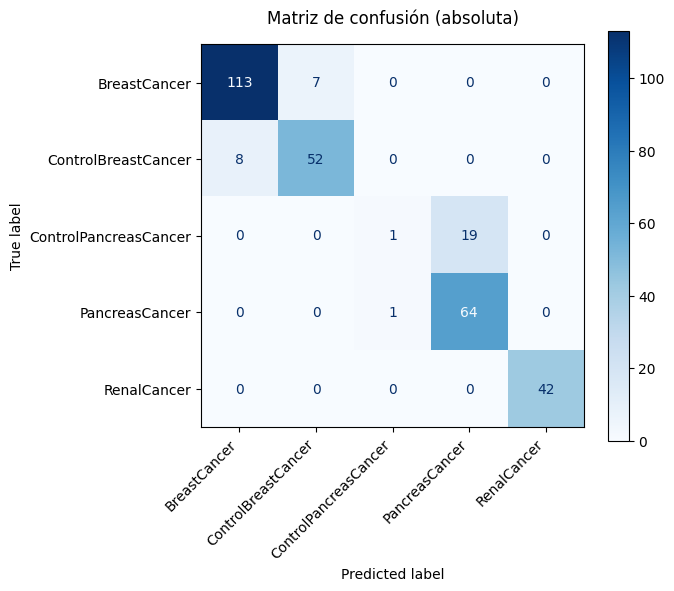

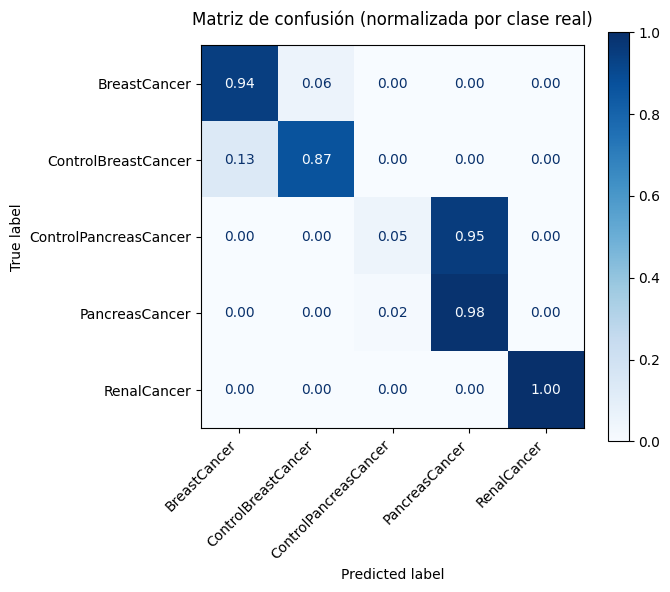


=== Métricas por clase (OOF) ===
                       precision    recall        f1  soporte
BreastCancer            0.933884  0.941667  0.937759    120.0
ControlBreastCancer     0.881356  0.866667  0.873950     60.0
ControlPancreasCancer   0.500000  0.050000  0.090909     20.0
PancreasCancer          0.771084  0.984615  0.864865     65.0
RenalCancer             1.000000  1.000000  1.000000     42.0
macro_avg               0.817265  0.768590  0.753497      NaN
micro_avg               0.885993  0.885993  0.885993    307.0


In [173]:
# ============================
# Baseline RF (SIN ComBat)
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import (
    f1_score, balanced_accuracy_score, make_scorer, accuracy_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_fscore_support
)
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42

#   X: Es la matriz previa a ComBat, imputada por dataset -> Xi
#   y: etiquetas re-etiquetadas                           -> y_5c
X_use = Xi.copy()
y_use = y_5c.reindex(X_use.index)

print(f"[INFO] X_use (SIN ComBat): {X_use.shape}")
print("[INFO] Conteo de clases:\n", y_use.value_counts())
if X_use.isna().any().any():  # por si acaso
    print("[AVISO] Se han detectado NaNs residuales en Xi; se imputan con mediana para poder evaluar.")
    X_eval = X_use.fillna(X_use.median())
else:
    X_eval = X_use

# Métricas y CV
scoring = {
    "accuracy": "accuracy",
    "macro_f1": make_scorer(f1_score, average="macro"),
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "auc_ovr_macro": make_scorer(
        roc_auc_score, needs_proba=True, multi_class="ovr", average="macro"
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Modelo: RF
rf_baseline = RandomForestClassifier(
    n_estimators=600,
    max_features="sqrt",
    class_weight="balanced_subsample",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Evaluación CV
res = cross_validate(
    rf_baseline,
    X_eval, y_use,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

res_df = pd.DataFrame(res)
res_df.loc['mean'] = res_df.mean(numeric_only=True)

print("\n=== Baseline RF (SIN ComBat) · CV Estratificada (k=5) ===")
print(res_df[["test_accuracy", "test_macro_f1", "test_balanced_acc", "test_auc_ovr_macro", "fit_time"]])

# Guardo para comparar luego con ComBat/SMOTE
res_baseline_rf_no_combat = res_df

# ====================================================
# OOF para matriz de confusión y métricas por clase
# ====================================================
# Probabilidades y predicciones OOF (cada muestra predicha por un modelo que no la ha visto)
proba_oof = cross_val_predict(
    rf_baseline, X_eval, y_use, cv=cv, method="predict_proba", n_jobs=-1
)
# Aseguro el orden de clases y convierto a etiquetas predichas
rf_baseline.fit(X_eval, y_use)
classes_ = rf_baseline.classes_
pred_idx = np.argmax(proba_oof, axis=1)
pred_labels = np.array([classes_[i] for i in pred_idx])

# Métricas globales OOF
acc_oof = accuracy_score(y_use, pred_labels)
try:
    auc_ovr_macro_oof = roc_auc_score(y_use, proba_oof, multi_class="ovr", average="macro")
except Exception:
    auc_ovr_macro_oof = np.nan

print(f"\n[OOF] Accuracy: {acc_oof:.4f} · AUC OvR (macro): {auc_ovr_macro_oof:.4f}")

# Matriz de confusión con sklearn
cm = confusion_matrix(y_use, pred_labels, labels=classes_)
cm_norm = confusion_matrix(y_use, pred_labels, labels=classes_, normalize="true")

# Absoluta
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
ax.set_title("Matriz de confusión (absoluta)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Normalizada
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
ax.set_title("Matriz de confusión (normalizada por clase real)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Precisión, recall y F1 por clase (OOF)
prec, rec, f1, support = precision_recall_fscore_support(
    y_use, pred_labels, labels=classes_, zero_division=0
)
per_class_df = pd.DataFrame({
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "soporte": support
}, index=classes_)
per_class_df.loc["macro_avg"] = per_class_df.iloc[:, :3].mean()
per_class_df.loc["micro_avg"] = [
    acc_oof,                                                    # precisión micro == recall micro == accuracy
    acc_oof,
    f1_score(y_use, pred_labels, average="micro"),
    support.sum()
]
print("\n=== Métricas por clase (OOF) ===")
print(per_class_df)


In [174]:
# ============================================================
# Guardar matriz de confusión normalizada como PNG (Baseline RF sin ComBat)
# ============================================================
import os

os.makedirs("content", exist_ok=True)

fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")

ax.set_title("Matriz de confusión (normalizada, % por clase real) — Baseline RF sin ComBat",
             fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

ruta_salida = "content/matriz_confusion_normalizada_BaselineRF_sinComBat.png"
plt.savefig(ruta_salida, dpi=300, bbox_inches="tight")
plt.close(fig)

print(f"[INFO] Matriz de confusión guardada en: {ruta_salida}")


[INFO] Matriz de confusión guardada en: content/matriz_confusion_normalizada_BaselineRF_sinComBat.png


#### **Baseline CON ComBat (RF balanceado)**

Voy a hacer el mismo módelo anterior, pero esta vez utilizando el dataset que tengo con ComBat (Xc_scaled_df), mantengo las etiquetas (y_5c) y vamos a ver si así correguimos los NaNs del Marco F1.


[INFO] X_use (CON ComBat): (307, 135)
[INFO] Conteo de clases:
 label_5c
BreastCancer             120
PancreasCancer            65
ControlBreastCancer       60
RenalCancer               42
ControlPancreasCancer     20
Name: count, dtype: int64

=== RF (CON ComBat) · CV Estratificada (k=5) ===
      test_accuracy  test_macro_f1  test_macro_f1_safe  test_balanced_acc  \
0          0.725806       0.550850            0.550850           0.577778   
1          0.806452       0.727858            0.727858           0.697009   
2          0.836066       0.651506            0.651506           0.658333   
3          0.803279       0.707326            0.707326           0.684615   
4          0.868852       0.703099            0.703099           0.708333   
mean       0.808091       0.668128            0.668128           0.665214   

      test_auc_ovr_macro  fit_time  
0                    NaN  8.447305  
1                    NaN  8.464788  
2                    NaN  8.934378  
3                 

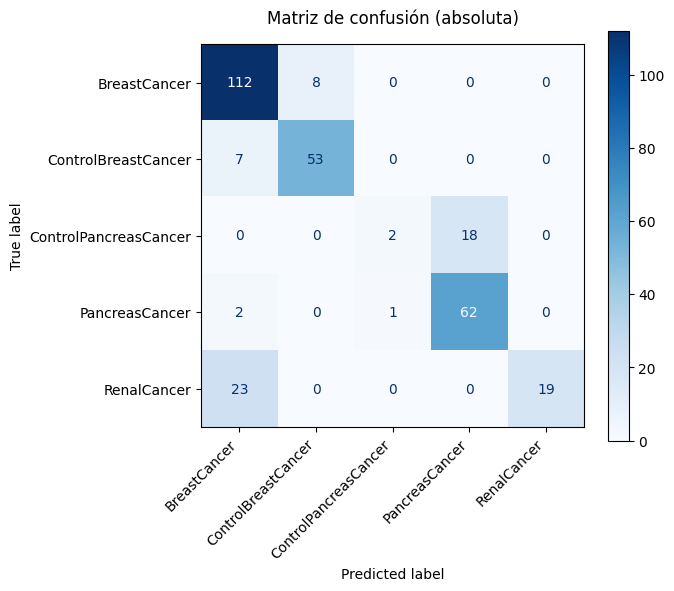

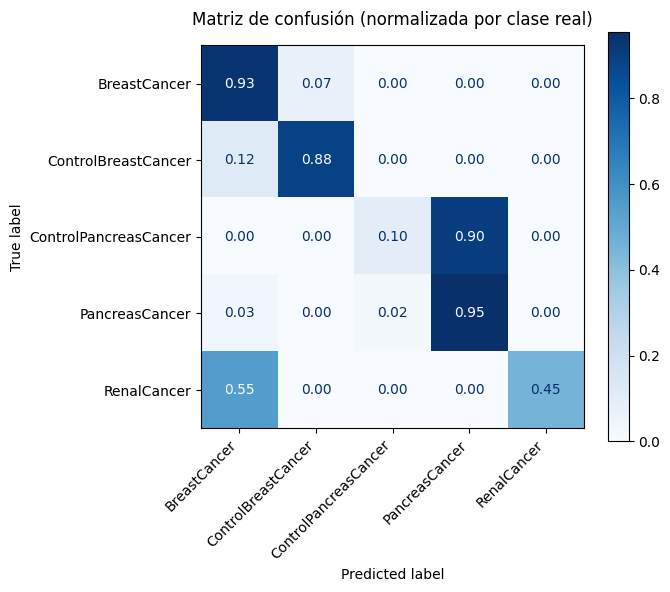


=== Métricas por clase (OOF) — RF con ComBat ===
                       precision    recall        f1  soporte
BreastCancer            0.777778  0.933333  0.848485    120.0
ControlBreastCancer     0.868852  0.883333  0.876033     60.0
ControlPancreasCancer   0.666667  0.100000  0.173913     20.0
PancreasCancer          0.775000  0.953846  0.855172     65.0
RenalCancer             1.000000  0.452381  0.622951     42.0
macro_avg               0.817659  0.664579  0.675311      NaN
micro_avg               0.807818  0.807818  0.807818    307.0


In [175]:
# =======================================================
# RF (CON ComBat) --> Xc_scaled_df + y_5c  · métricas ampliadas
# =======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import (
    f1_score, balanced_accuracy_score, make_scorer, accuracy_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_fscore_support
)
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42

X_use = Xc_scaled_df.copy()
y_use = y_5c.reindex(X_use.index)

print(f"[INFO] X_use (CON ComBat): {X_use.shape}")
print("[INFO] Conteo de clases:\n", y_use.value_counts())
if X_use.isna().any().any():
    print("[AVISO] Se detectaron NaNs en Xc_scaled_df; imputo mediana para poder evaluar.")
    X_eval = X_use.fillna(X_use.median())
else:
    X_eval = X_use

scoring = {
    "accuracy": "accuracy",
    "macro_f1": make_scorer(f1_score, average="macro"),
    "macro_f1_safe": make_scorer(f1_score, average="macro", zero_division=0),
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "auc_ovr_macro": make_scorer(
        roc_auc_score, needs_proba=True, multi_class="ovr", average="macro"
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Modelo RF balanceado
rf_baseline = RandomForestClassifier(
    n_estimators=600,
    max_features="sqrt",
    class_weight="balanced_subsample",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Evaluación CV
res = cross_validate(
    rf_baseline,
    X_eval, y_use,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

res_df_cb = pd.DataFrame(res)
res_df_cb.loc['mean'] = res_df_cb.mean(numeric_only=True)

print("\n=== RF (CON ComBat) · CV Estratificada (k=5) ===")
print(res_df_cb[[
    "test_accuracy", "test_macro_f1", "test_macro_f1_safe",
    "test_balanced_acc", "test_auc_ovr_macro", "fit_time"
]])

res_baseline_rf_combat = res_df_cb

# ============================================================
# OOF para matriz de confusión y métricas por clase
# ============================================================
# Probabilidades y predicciones OOF
proba_oof = cross_val_predict(
    rf_baseline, X_eval, y_use, cv=cv, method="predict_proba", n_jobs=-1
)

# Alineo el orden de clases y obtengo las etiquetas predichas
rf_baseline.fit(X_eval, y_use)
classes_ = rf_baseline.classes_
pred_idx = np.argmax(proba_oof, axis=1)
pred_labels = np.array([classes_[i] for i in pred_idx])

# Métricas OOF globales
acc_oof = accuracy_score(y_use, pred_labels)
try:
    auc_ovr_macro_oof = roc_auc_score(y_use, proba_oof, multi_class="ovr", average="macro")
except Exception:
    auc_ovr_macro_oof = np.nan

print(f"\n[OOF] Accuracy: {acc_oof:.4f} · AUC OvR (macro): {auc_ovr_macro_oof:.4f}")

# Matrices de confusión (sklearn)
cm = confusion_matrix(y_use, pred_labels, labels=classes_)
cm_norm = confusion_matrix(y_use, pred_labels, labels=classes_, normalize="true")

# Absoluta
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
ax.set_title("Matriz de confusión (absoluta)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Normalizada por clase real
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
ax.set_title("Matriz de confusión (normalizada por clase real)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Precisión, recall y F1 por clase (OOF)
prec, rec, f1, support = precision_recall_fscore_support(
    y_use, pred_labels, labels=classes_, zero_division=0
)

per_class_cb = pd.DataFrame({
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "soporte": support
}, index=classes_)

per_class_cb.loc["macro_avg"] = per_class_cb.iloc[:, :3].mean()
per_class_cb.loc["micro_avg"] = [
    acc_oof,  # precisión micro == recall micro == accuracy global
    acc_oof,
    f1_score(y_use, pred_labels, average="micro"),
    support.sum()
]

print("\n=== Métricas por clase (OOF) — RF con ComBat ===")
print(per_class_cb)


#### **Prueba de reequilibrado con SMOTE dentro de la CV**

La idea es comprobar si al crear más ejemplos sintéticos de las minoritarias (como ControlPancreasCancer) consego que el modelo aprenda algo de ellas y aparezca un F1 > 0 para todas las clases.

Nuevamente voy a probar con y sin ComBat y mantengo el RF balanceado y el StratifiedKFold (k=5).

[INFO] X_use (SIN ComBat, para SMOTE): (307, 135)
[INFO] Conteo de clases:
 label_5c
BreastCancer             120
PancreasCancer            65
ControlBreastCancer       60
RenalCancer               42
ControlPancreasCancer     20
Name: count, dtype: int64

=== RF + SMOTE (SIN ComBat) · CV Estratificada (k=5) ===
      test_accuracy  test_macro_f1  test_macro_f1_safe  test_balanced_acc  \
0          0.887097       0.812557            0.812557           0.816667   
1          0.903226       0.872567            0.872567           0.885897   
2          0.918033       0.834310            0.834310           0.825000   
3          0.885246       0.842063            0.842063           0.834615   
4          0.918033       0.825318            0.825318           0.817949   
mean       0.902327       0.837363            0.837363           0.836026   

      test_auc_ovr_macro   fit_time  
0                    NaN  15.841247  
1                    NaN  16.079491  
2                    NaN  14.080

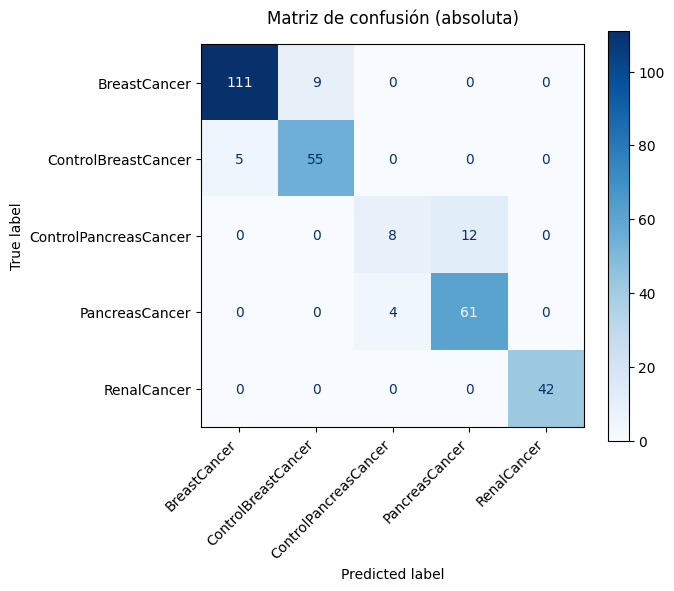

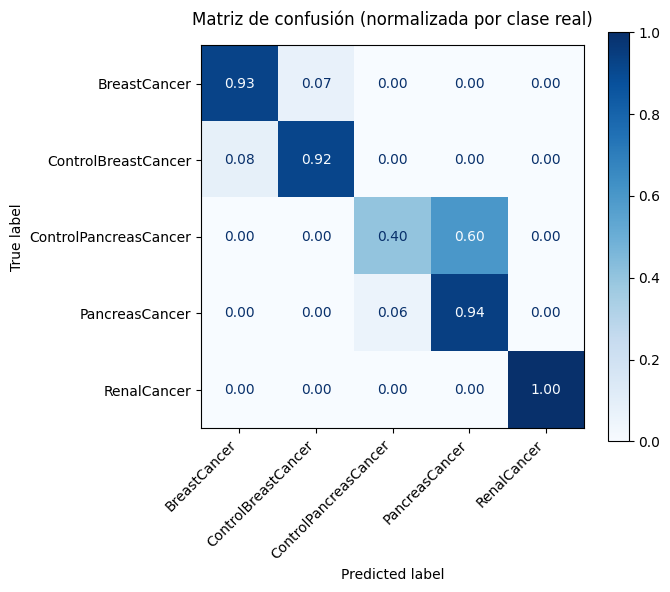


=== Métricas por clase (OOF) — RF + SMOTE sin ComBat ===
                       precision    recall        f1  soporte
BreastCancer            0.956897  0.925000  0.940678    120.0
ControlBreastCancer     0.859375  0.916667  0.887097     60.0
ControlPancreasCancer   0.666667  0.400000  0.500000     20.0
PancreasCancer          0.835616  0.938462  0.884058     65.0
RenalCancer             1.000000  1.000000  1.000000     42.0
macro_avg               0.863711  0.836026  0.842367      NaN
micro_avg               0.902280  0.902280  0.902280    307.0


In [176]:
# ============================
# RF + SMOTE (SIN ComBat)
# ============================
from imblearn.pipeline import Pipeline

RANDOM_STATE = 42

X_use = Xi.copy()
y_use = y_5c.reindex(X_use.index)

print(f"[INFO] X_use (SIN ComBat, para SMOTE): {X_use.shape}")
print("[INFO] Conteo de clases:\n", y_use.value_counts())

if X_use.isna().any().any():
    print("[AVISO] NaNs residuales detectados en Xi; imputo mediana para evaluar.")
    X_eval = X_use.fillna(X_use.median())
else:
    X_eval = X_use

# Métricas y CV
scoring = {
    "accuracy": "accuracy",
    "macro_f1": make_scorer(f1_score, average="macro"),
    "macro_f1_safe": make_scorer(f1_score, average="macro", zero_division=0),
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "auc_ovr_macro": make_scorer(
        roc_auc_score, needs_proba=True, multi_class="ovr", average="macro"
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Pipeline: SMOTE -> RF
pipe_smote_rf = Pipeline(steps=[
    ("smote", SMOTE(
        sampling_strategy="auto",
        k_neighbors=5,
        random_state=RANDOM_STATE
    )),
    ("rf", RandomForestClassifier(
        n_estimators=600,
        max_features="sqrt",
        class_weight="balanced_subsample",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# Evaluación CV
res = cross_validate(
    pipe_smote_rf,
    X_eval, y_use,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

res_smote_rf_no_combat = pd.DataFrame(res)
res_smote_rf_no_combat.loc['mean'] = res_smote_rf_no_combat.mean(numeric_only=True)

print("\n=== RF + SMOTE (SIN ComBat) · CV Estratificada (k=5) ===")
print(res_smote_rf_no_combat[[
    "test_accuracy", "test_macro_f1", "test_macro_f1_safe",
    "test_balanced_acc", "test_auc_ovr_macro", "fit_time"
]])

# ============================================================
# OOF para matriz de confusión y métricas por clase
# ============================================================
# Probabilidades y predicciones OOF
proba_oof = cross_val_predict(
    pipe_smote_rf, X_eval, y_use, cv=cv, method="predict_proba", n_jobs=-1
)

# Alineo el orden de clases y obtengo las etiquetas predichas
pipe_smote_rf.fit(X_eval, y_use)
classes_ = pipe_smote_rf.classes_
pred_idx = np.argmax(proba_oof, axis=1)
pred_labels = np.array([classes_[i] for i in pred_idx])

# Métricas OOF globales
acc_oof = accuracy_score(y_use, pred_labels)
try:
    auc_ovr_macro_oof = roc_auc_score(y_use, proba_oof, multi_class="ovr", average="macro")
except Exception:
    auc_ovr_macro_oof = np.nan

print(f"\n[OOF] Accuracy: {acc_oof:.4f} · AUC OvR (macro): {auc_ovr_macro_oof:.4f}")

# Matrices de confusión (sklearn)
cm = confusion_matrix(y_use, pred_labels, labels=classes_)
cm_norm = confusion_matrix(y_use, pred_labels, labels=classes_, normalize="true")

# Absoluta
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
ax.set_title("Matriz de confusión (absoluta)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Normalizada por clase real
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
ax.set_title("Matriz de confusión (normalizada por clase real)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Precisión, recall y F1 por clase (OOF)
prec, rec, f1, support = precision_recall_fscore_support(
    y_use, pred_labels, labels=classes_, zero_division=0
)

per_class_smote_rf = pd.DataFrame({
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "soporte": support
}, index=classes_)

per_class_smote_rf.loc["macro_avg"] = per_class_smote_rf.iloc[:, :3].mean()
per_class_smote_rf.loc["micro_avg"] = [
    acc_oof,  # precisión micro == recall micro == accuracy global
    acc_oof,
    f1_score(y_use, pred_labels, average="micro"),
    support.sum()
]

print("\n=== Métricas por clase (OOF) — RF + SMOTE sin ComBat ===")
print(per_class_smote_rf)


##### **RF sin ComBat y SMOTE focalizado**

[INFO] X_use (SIN ComBat, para SMOTE focalizado): (307, 135)
[INFO] Conteo de clases:
 label_5c
BreastCancer             120
PancreasCancer            65
ControlBreastCancer       60
RenalCancer               42
ControlPancreasCancer     20
Name: count, dtype: int64

=== RF + SMOTE FOCALIZADO (SIN ComBat) · CV Estratificada (k=5) ===
      test_accuracy  test_macro_f1  test_macro_f1_safe  test_balanced_acc  \
0          0.887097       0.812557            0.812557           0.816667   
1          0.903226       0.872567            0.872567           0.885897   
2          0.918033       0.834310            0.834310           0.825000   
3          0.885246       0.842063            0.842063           0.834615   
4          0.918033       0.825318            0.825318           0.817949   
mean       0.902327       0.837363            0.837363           0.836026   

      test_auc_ovr_macro   fit_time  
0                    NaN  12.594665  
1                    NaN  12.642529  
2         

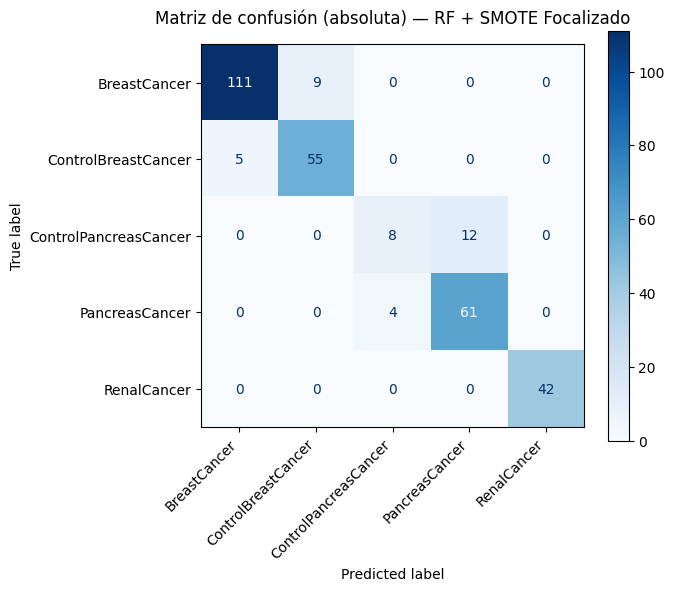

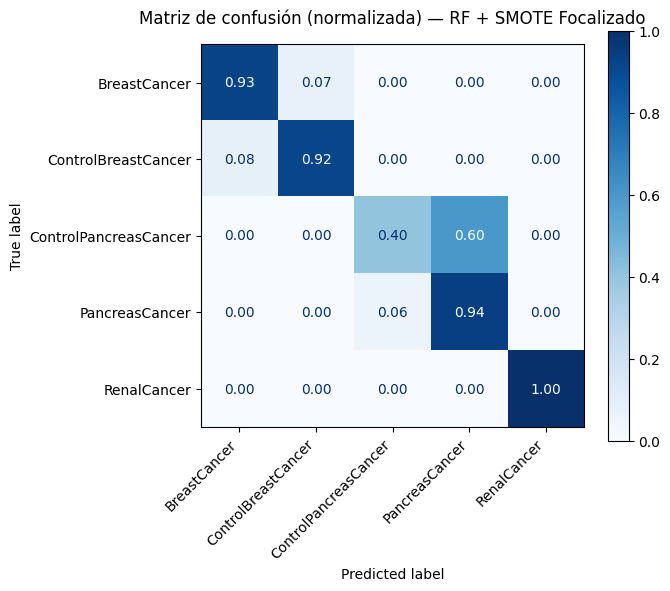


=== Métricas por clase (OOF) — RF + SMOTE Focalizado sin ComBat ===
                       precision    recall        f1  soporte
BreastCancer            0.956897  0.925000  0.940678    120.0
ControlBreastCancer     0.859375  0.916667  0.887097     60.0
ControlPancreasCancer   0.666667  0.400000  0.500000     20.0
PancreasCancer          0.835616  0.938462  0.884058     65.0
RenalCancer             1.000000  1.000000  1.000000     42.0
macro_avg               0.863711  0.836026  0.842367      NaN
micro_avg               0.902280  0.902280  0.902280    307.0


In [177]:
# ===========================================
# RF + SMOTE FOCALIZADO (SIN ComBat)
# ===========================================

RANDOM_STATE = 42
minority_label = "PancreasCancerBenigno"  # clase problemática
target_ratio = 0.8                        # voy a llevar esa clase al 80% de la mayoritaria dentro de cada fold
                                          # (he probado con difrentes valores y creo que este es suficientemente agresivo)

X_use = Xi.copy()
y_use = y_5c.reindex(X_use.index)

print(f"[INFO] X_use (SIN ComBat, para SMOTE focalizado): {X_use.shape}")
print("[INFO] Conteo de clases:\n", y_use.value_counts())

if X_use.isna().any().any():
    print("[AVISO] NaNs residuales detectados en Xi; imputo mediana para evaluar.")
    X_eval = X_use.fillna(X_use.median(numeric_only=True))
else:
    X_eval = X_use

# ====================================================================================================
#  SMOTE focalizado en una sola clase (minority_label).
#    Ajusta dinámicamente:
#      - sampling_strategy: {minority_label: target_n} con target_n = round(max_clase * target_ratio)
#     - k_neighbors: min(k_base, n_minority-1) para evitar errores con pocas muestras
# ====================================================================================================
class FocalSMOTE(SMOTE):
    def __init__(self, minority_label, target_ratio=0.8, k_base=5, random_state=None):
        super().__init__(sampling_strategy="auto", k_neighbors=k_base, random_state=random_state)
        self.minority_label = minority_label
        self.target_ratio = target_ratio
        self.k_base = k_base

    def fit_resample(self, X, y):
        y_series = pd.Series(y)
        counts = y_series.value_counts()
        if self.minority_label not in counts:
            # Si la clase no aparece en el fold, no hago nada
            self.sampling_strategy = "auto"
            return super().fit_resample(X, y)

        n_min = int(counts[self.minority_label])
        n_max = int(counts.max())
        target_n = max(int(round(n_max * self.target_ratio)), n_min)

        # k_neighbors seguro (SMOTE requiere al menos 2 muestras de la minoritaria)
        k_safe = max(1, min(self.k_base, n_min - 1))
        # si solo hay 1 muestra de esa clase en el fold, no se puede sintetizar
        if k_safe < 1 or n_min < 2:
            return np.asarray(X), np.asarray(y)

        # Actualizo los parámetros dinámicos antes de llamar al padre
        self.k_neighbors = k_safe
        self.sampling_strategy = {self.minority_label: target_n}
        return super().fit_resample(X, y)

# Métricas y CV
scoring = {
    "accuracy": "accuracy",
    "macro_f1": make_scorer(f1_score, average="macro"),
    "macro_f1_safe": make_scorer(f1_score, average="macro", zero_division=0),
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "auc_ovr_macro": make_scorer(
        roc_auc_score, needs_proba=True, multi_class="ovr", average="macro"
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Pipeline: Focal SMOTE -> RF
pipe_smote_rf = Pipeline(steps=[
    ("smote", FocalSMOTE(
        minority_label=minority_label,
        target_ratio=target_ratio,
        k_base=5,
        random_state=RANDOM_STATE
    )),
    ("rf", RandomForestClassifier(
        n_estimators=600,
        max_features="sqrt",
        class_weight="balanced_subsample",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# Evaluación CV
res = cross_validate(
    pipe_smote_rf,
    X_eval, y_use,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

res_smoteFocal_rf_no_combat = pd.DataFrame(res)
res_smoteFocal_rf_no_combat.loc["mean"] = res_smoteFocal_rf_no_combat.mean(numeric_only=True)

print("\n=== RF + SMOTE FOCALIZADO (SIN ComBat) · CV Estratificada (k=5) ===")
print(res_smoteFocal_rf_no_combat[[
    "test_accuracy", "test_macro_f1", "test_macro_f1_safe",
    "test_balanced_acc", "test_auc_ovr_macro", "fit_time"
]])

# ==================================================
# OOF para matriz de confusión y métricas por clase
# ==================================================
# Probabilidades y predicciones OOF
proba_oof = cross_val_predict(
    pipe_smote_rf, X_eval, y_use, cv=cv, method="predict_proba", n_jobs=-1
)

pipe_smote_rf.fit(X_eval, y_use)
classes_ = pipe_smote_rf.classes_

# Etiquetas predichas OOF
pred_idx = np.argmax(proba_oof, axis=1)
pred_labels = np.array([classes_[i] for i in pred_idx])

# Métricas OOF globales
acc_oof = accuracy_score(y_use, pred_labels)
try:
    auc_ovr_macro_oof = roc_auc_score(y_use, proba_oof, multi_class="ovr", average="macro")
except Exception:
    auc_ovr_macro_oof = np.nan

print(f"\n[OOF] Accuracy: {acc_oof:.4f} · AUC OvR (macro): {auc_ovr_macro_oof:.4f}")

# Matrices de confusión
cm = confusion_matrix(y_use, pred_labels, labels=classes_)
cm_norm = confusion_matrix(y_use, pred_labels, labels=classes_, normalize="true")

# Absoluta
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
ax.set_title("Matriz de confusión (absoluta) — RF + SMOTE Focalizado", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Normalizada por clase real
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
ax.set_title("Matriz de confusión (normalizada) — RF + SMOTE Focalizado", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Precisión, recall y F1 por clase (OOF)
prec, rec, f1, support = precision_recall_fscore_support(
    y_use, pred_labels, labels=classes_, zero_division=0
)

per_class_smoteFocal_rf = pd.DataFrame({
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "soporte": support
}, index=classes_)

per_class_smoteFocal_rf.loc["macro_avg"] = per_class_smoteFocal_rf.iloc[:, :3].mean()
per_class_smoteFocal_rf.loc["micro_avg"] = [
    acc_oof,
    acc_oof,
    f1_score(y_use, pred_labels, average="micro"),
    support.sum()
]

print("\n=== Métricas por clase (OOF) — RF + SMOTE Focalizado sin ComBat ===")
print(per_class_smoteFocal_rf)


##### **RF con ComBat y SMOTE**

[INFO] X_use (CON ComBat, para SMOTE): (307, 135)
[INFO] Conteo de clases:
 label_5c
BreastCancer             120
PancreasCancer            65
ControlBreastCancer       60
RenalCancer               42
ControlPancreasCancer     20
Name: count, dtype: int64

=== RF + SMOTE (CON ComBat) · CV Estratificada (k=5) ===
      test_accuracy  test_macro_f1  test_macro_f1_safe  test_balanced_acc  \
0          0.822581       0.740209            0.740209           0.733333   
1          0.854839       0.831231            0.831231           0.819231   
2          0.950820       0.859310            0.859310           0.850000   
3          0.852459       0.806159            0.806159           0.784615   
4          0.901639       0.808066            0.808066           0.792949   
mean       0.876467       0.808995            0.808995           0.796026   

      test_auc_ovr_macro   fit_time  
0                    NaN  17.957280  
1                    NaN  18.237026  
2                    NaN  11.313

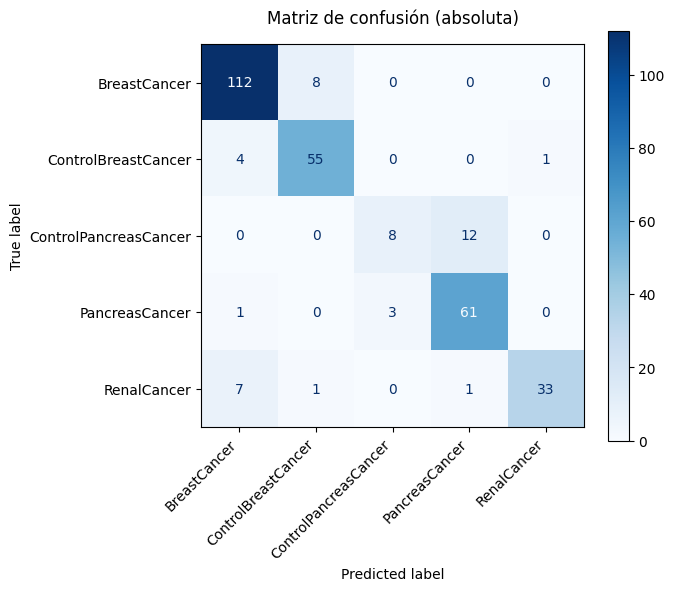

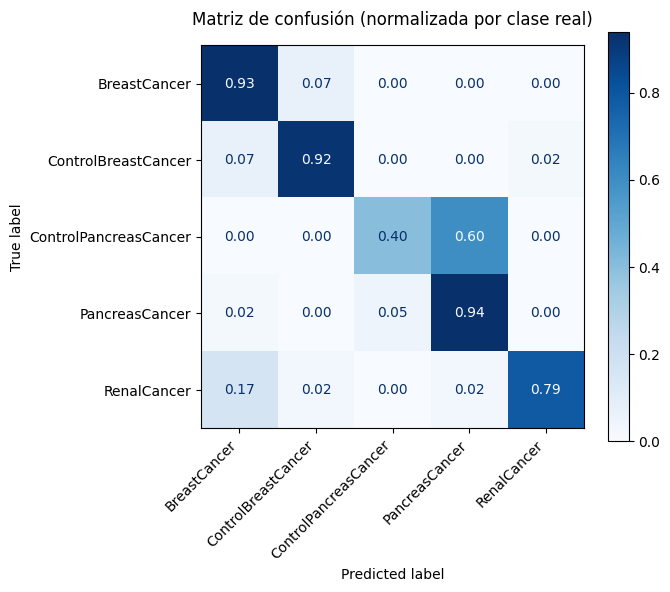


=== Métricas por clase (OOF) — RF + SMOTE con ComBat ===
                       precision    recall        f1  soporte
BreastCancer            0.903226  0.933333  0.918033    120.0
ControlBreastCancer     0.859375  0.916667  0.887097     60.0
ControlPancreasCancer   0.727273  0.400000  0.516129     20.0
PancreasCancer          0.824324  0.938462  0.877698     65.0
RenalCancer             0.970588  0.785714  0.868421     42.0
macro_avg               0.856957  0.794835  0.813475      NaN
micro_avg               0.876221  0.876221  0.876221    307.0


In [178]:
# ============================
# RF + SMOTE (CON ComBat)
# ============================

RANDOM_STATE = 42

X_use = Xc_scaled_df.copy()
y_use = y_5c.reindex(X_use.index)

print(f"[INFO] X_use (CON ComBat, para SMOTE): {X_use.shape}")
print("[INFO] Conteo de clases:\n", y_use.value_counts())

if X_use.isna().any().any():
    print("[AVISO] NaNs detectados en Xc_scaled; imputo mediana para poder evaluar.")
    X_eval = X_use.fillna(X_use.median())
else:
    X_eval = X_use

# Métricas y CV
scoring = {
    "accuracy": "accuracy",
    "macro_f1": make_scorer(f1_score, average="macro"),
    "macro_f1_safe": make_scorer(f1_score, average="macro", zero_division=0),  # diagnóstico
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "auc_ovr_macro": make_scorer(
        roc_auc_score, needs_proba=True, multi_class="ovr", average="macro"
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Pipeline: SMOTE -> RF
pipe_smote_rf_cb = Pipeline(steps=[
    ("smote", SMOTE(
        sampling_strategy="auto",
        k_neighbors=5,
        random_state=RANDOM_STATE
    )),
    ("rf", RandomForestClassifier(
        n_estimators=600,
        max_features="sqrt",
        class_weight="balanced_subsample",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# Evaluación CV
res = cross_validate(
    pipe_smote_rf_cb,
    X_eval, y_use,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

res_smote_rf_combat = pd.DataFrame(res)
res_smote_rf_combat.loc['mean'] = res_smote_rf_combat.mean(numeric_only=True)

print("\n=== RF + SMOTE (CON ComBat) · CV Estratificada (k=5) ===")
print(res_smote_rf_combat[[
    "test_accuracy", "test_macro_f1", "test_macro_f1_safe",
    "test_balanced_acc", "test_auc_ovr_macro", "fit_time"
]])

# ============================================================
# OOF para matriz de confusión y métricas por clase
# ============================================================
# Probabilidades y predicciones OOF
proba_oof = cross_val_predict(
    pipe_smote_rf_cb, X_eval, y_use, cv=cv, method="predict_proba", n_jobs=-1
)

# Alineo el orden de clases y obtengo las etiquetas predichas
pipe_smote_rf_cb.fit(X_eval, y_use)  # solo para leer classes_
classes_ = pipe_smote_rf_cb.classes_
pred_idx = np.argmax(proba_oof, axis=1)
pred_labels = np.array([classes_[i] for i in pred_idx])

# Métricas OOF globales
acc_oof = accuracy_score(y_use, pred_labels)
try:
    auc_ovr_macro_oof = roc_auc_score(y_use, proba_oof, multi_class="ovr", average="macro")
except Exception:
    auc_ovr_macro_oof = np.nan

print(f"\n[OOF] Accuracy: {acc_oof:.4f} · AUC OvR (macro): {auc_ovr_macro_oof:.4f}")

# Matrices de confusión (sklearn)
cm = confusion_matrix(y_use, pred_labels, labels=classes_)
cm_norm = confusion_matrix(y_use, pred_labels, labels=classes_, normalize="true")

# Absoluta
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
ax.set_title("Matriz de confusión (absoluta)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Normalizada por clase real
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
ax.set_title("Matriz de confusión (normalizada por clase real)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Precisión, recall y F1 por clase (OOF)
prec, rec, f1, support = precision_recall_fscore_support(
    y_use, pred_labels, labels=classes_, zero_division=0
)

per_class_smote_rf_cb = pd.DataFrame({
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "soporte": support
}, index=classes_)

per_class_smote_rf_cb.loc["macro_avg"] = per_class_smote_rf_cb.iloc[:, :3].mean()
per_class_smote_rf_cb.loc["micro_avg"] = [
    acc_oof,  # precisión micro == recall micro == accuracy global
    acc_oof,
    f1_score(y_use, pred_labels, average="micro"),
    support.sum()
]

print("\n=== Métricas por clase (OOF) — RF + SMOTE con ComBat ===")
print(per_class_smote_rf_cb)


#### **RF con class_weight manual SIN ComBat**

Voy a probar una última cosa, para ver si puedo solucionar los NaNs del F1_score.

La idea es partir de los pesos *balanced* automáticos, pero multiplicarl el de **ControlPancreasCancer** (p.ej., ×5). Así se penaliza de manera más fuerte los errores en esa clase y forzamos al modelo a emitir predicciones allí (evitando el F1=0).

[INFO] X_use (SIN ComBat, RF class_weight manual): (307, 135)
[INFO] Conteo de clases:
 label_5c
BreastCancer             120
PancreasCancer            65
ControlBreastCancer       60
RenalCancer               42
ControlPancreasCancer     20
Name: count, dtype: int64
[INFO] Clases codificadas: {'BreastCancer': 0, 'ControlBreastCancer': 1, 'ControlPancreasCancer': 2, 'PancreasCancer': 3, 'RenalCancer': 4}
[INFO] class_weight usado:
{'BreastCancer': np.float64(0.5116666666666667), 'ControlBreastCancer': np.float64(1.0233333333333334), 'ControlPancreasCancer': np.float64(15.35), 'PancreasCancer': np.float64(0.9446153846153846), 'RenalCancer': np.float64(1.4619047619047618)}

=== RF (class_weight manual) · CV Estratificada (k=5) ===
      test_accuracy  test_macro_f1  test_macro_f1_safe  test_balanced_acc  \
0          0.854839       0.714074            0.714074           0.750000   
1          0.903226       0.822544            0.822544           0.816667   
2          0.901639       0.74

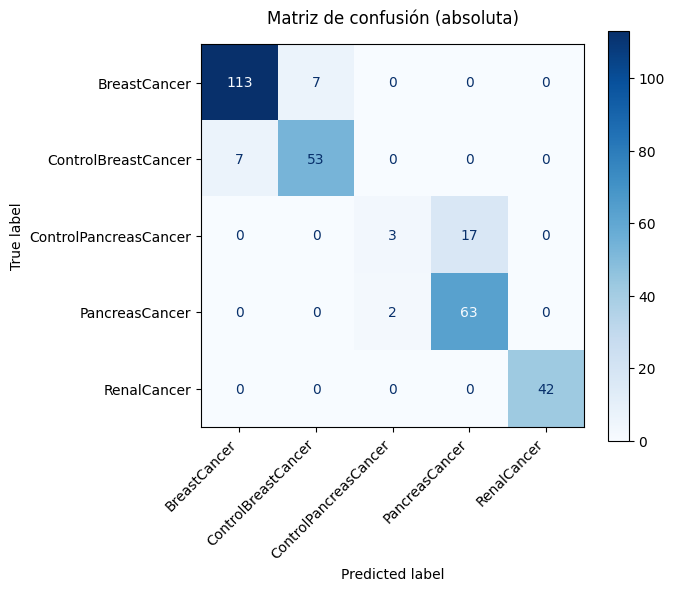

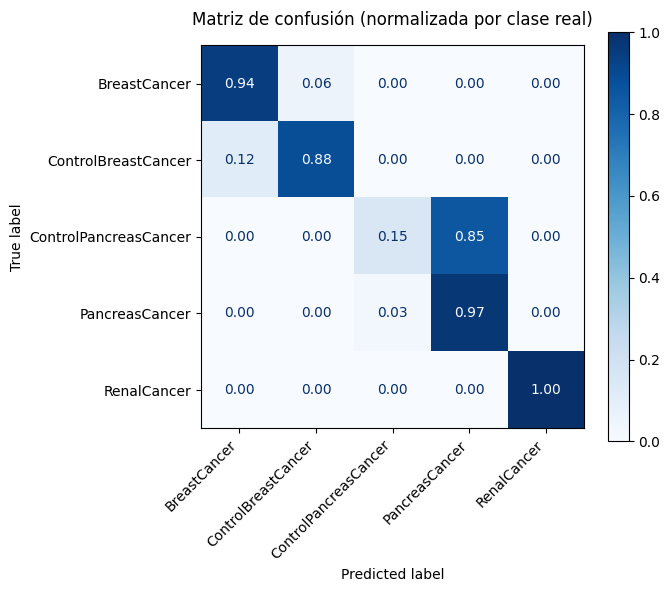


=== Métricas por clase (OOF) — RF class_weight manual sin ComBat ===
                       precision    recall        f1  soporte
BreastCancer            0.941667  0.941667  0.941667    120.0
ControlBreastCancer     0.883333  0.883333  0.883333     60.0
ControlPancreasCancer   0.600000  0.150000  0.240000     20.0
PancreasCancer          0.787500  0.969231  0.868966     65.0
RenalCancer             1.000000  1.000000  1.000000     42.0
macro_avg               0.842500  0.788846  0.786793      NaN
micro_avg               0.892508  0.892508  0.892508    307.0


In [179]:
# ==========================================
# RF con class_weight manual (SIN ComBat)
# ==========================================

RANDOM_STATE = 42

X_use = Xi.copy()
y_use = y_5c.reindex(X_use.index)

print(f"[INFO] X_use (SIN ComBat, RF class_weight manual): {X_use.shape}")
print("[INFO] Conteo de clases:\n", y_use.value_counts())

if X_use.isna().any().any():
    print("[AVISO] NaNs detectados en Xi; imputo mediana.")
    X_eval = X_use.fillna(X_use.median())
else:
    X_eval = X_use

# Codifico las etiquetas a números para evitar conflictos en class_weight
le = LabelEncoder()
y_encoded = le.fit_transform(y_use)
classes = le.classes_
print(f"[INFO] Clases codificadas: {dict(zip(classes, range(len(classes))))}")

# Pesos de clase manuales
base_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_encoded), y=y_encoded)
cw = {i: w for i, w in enumerate(base_weights)}

# Refuerzo adicional para ControlPancreasCancer
boost_factor = 5.0
target_class_name = "ControlPancreasCancer"
if target_class_name in classes:
    idx_target = list(classes).index(target_class_name)
    cw[idx_target] = cw[idx_target] * boost_factor
else:
    print(f"[AVISO] Clase '{target_class_name}' no está en y_5c; se usan pesos balanced sin refuerzo.")

print("[INFO] class_weight usado:")
print({classes[k]: v for k, v in cw.items()})

# Métricas y CV
scoring = {
    "accuracy": "accuracy",
    "macro_f1": make_scorer(f1_score, average="macro"),
    "macro_f1_safe": make_scorer(f1_score, average="macro", zero_division=0),
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "auc_ovr_macro": make_scorer(
        roc_auc_score, needs_proba=True, multi_class="ovr", average="macro"
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Modelo RF con pesos manuales
rf_weighted = RandomForestClassifier(
    n_estimators=700,
    max_features="sqrt",
    class_weight=cw,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Evaluación CV
res = cross_validate(
    rf_weighted,
    X_eval, y_encoded,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

res_rf_cw_manual = pd.DataFrame(res)
res_rf_cw_manual.loc['mean'] = res_rf_cw_manual.mean(numeric_only=True)

print("\n=== RF (class_weight manual) · CV Estratificada (k=5) ===")
print(res_rf_cw_manual[[
    "test_accuracy", "test_macro_f1", "test_macro_f1_safe",
    "test_balanced_acc", "test_auc_ovr_macro", "fit_time"
]])

# OOF para matriz de confusión y métricas por clase
proba_oof = cross_val_predict(
    rf_weighted, X_eval, y_encoded, cv=cv, method="predict_proba", n_jobs=-1
)

rf_weighted.fit(X_eval, y_encoded)
pred_idx = np.argmax(proba_oof, axis=1)
pred_labels = le.inverse_transform(pred_idx)
true_labels = y_use.values

# Métricas OOF globales
acc_oof = accuracy_score(true_labels, pred_labels)
try:
    auc_ovr_macro_oof = roc_auc_score(y_encoded, proba_oof, multi_class="ovr", average="macro")
except Exception:
    auc_ovr_macro_oof = np.nan

print(f"\n[OOF] Accuracy: {acc_oof:.4f} · AUC OvR (macro): {auc_ovr_macro_oof:.4f}")

# Matrices de confusión (sklearn)
cm = confusion_matrix(true_labels, pred_labels, labels=classes)
cm_norm = confusion_matrix(true_labels, pred_labels, labels=classes, normalize="true")

# Absoluta
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
ax.set_title("Matriz de confusión (absoluta)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Normalizada
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
ax.set_title("Matriz de confusión (normalizada por clase real)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Precisión, recall y F1 por clase (OOF)
prec, rec, f1, support = precision_recall_fscore_support(
    true_labels, pred_labels, labels=classes, zero_division=0
)

per_class_rf_cw_manual = pd.DataFrame({
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "soporte": support
}, index=classes)

per_class_rf_cw_manual.loc["macro_avg"] = per_class_rf_cw_manual.iloc[:, :3].mean()
per_class_rf_cw_manual.loc["micro_avg"] = [
    acc_oof,
    acc_oof,
    f1_score(true_labels, pred_labels, average="micro"),
    support.sum()
]

print("\n=== Métricas por clase (OOF) — RF class_weight manual sin ComBat ===")
print(per_class_rf_cw_manual)


#### **Logistic Regression (multiclase balances)**

Voy a probar ahora con un clasificador más sensible al desbalanceo como es 'Logistic Regression', a ver si consigo eliminar los NaNs del F1_core.

Y así compruebo también que modelo obtiene mejores resultados.

Nuevamente voy a probar por tanto el dataset tartado con Combat como el sin tartar.

Nota*: Para saber exactamente qué clase causa el NaN, he calculado el **classification report (precision/recall/F1 por clase)** dentro de la validación cruzada. De esta manera, puedo saber que clase no se ha predicho nunca o si hubo algún racall = 0 (no acertó ninguna predicción de una clase).


=== Logistic Regression (SIN ComBat) · CV Estratificada (k=5) ===
      test_accuracy  test_macro_f1  test_macro_f1_safe  test_balanced_acc  \
0          0.838710       0.710390            0.710390           0.735897   
1          0.854839       0.787777            0.787777           0.806410   
2          0.868852       0.730462            0.730462           0.738462   
3          0.885246       0.832465            0.832465           0.835897   
4          0.918033       0.820106            0.820106           0.819231   
mean       0.873136       0.776240            0.776240           0.787179   

      test_auc_ovr_macro  fit_time  
0                    NaN  2.151478  
1                    NaN  1.459200  
2                    NaN  2.046410  
3                    NaN  2.226851  
4                    NaN  1.329209  
mean                 NaN  1.842630  


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



[OOF] Accuracy: 0.8730 · AUC OvR (macro): 0.9498


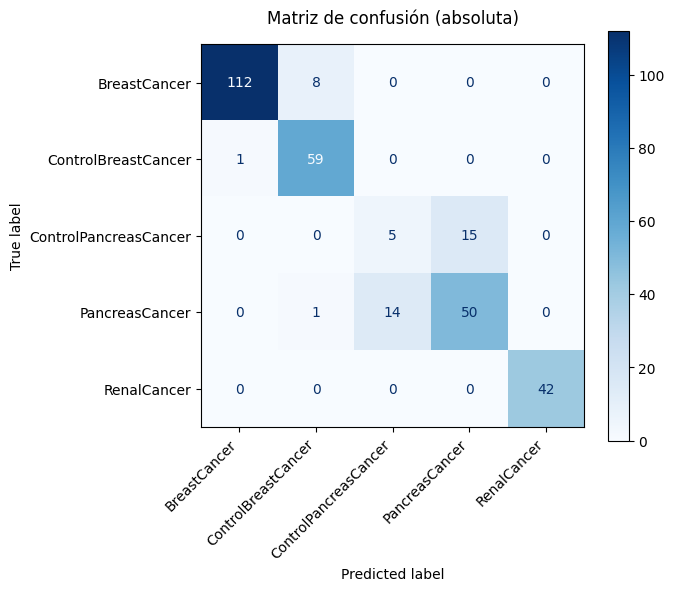

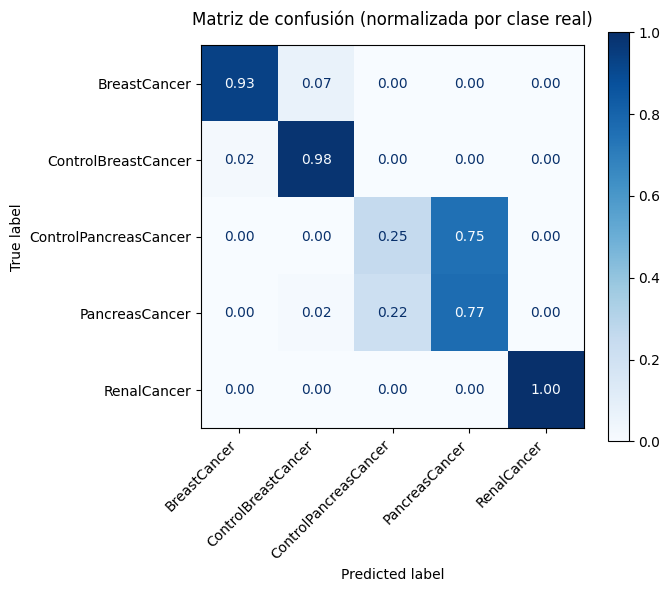


=== Métricas por clase (OOF) — Logistic Regression sin ComBat ===
                       precision    recall        f1  soporte
BreastCancer            0.991150  0.933333  0.961373    120.0
ControlBreastCancer     0.867647  0.983333  0.921875     60.0
ControlPancreasCancer   0.263158  0.250000  0.256410     20.0
PancreasCancer          0.769231  0.769231  0.769231     65.0
RenalCancer             1.000000  1.000000  1.000000     42.0
macro_avg               0.778237  0.787179  0.781778      NaN
micro_avg               0.872964  0.872964  0.872964    307.0


In [180]:
# =================================
# Logistic Regression (SIN ComBat)
# =================================

RANDOM_STATE = 42

X_use = Xi.copy()
y_use = y_5c.reindex(X_use.index)

if X_use.isna().any().any():
    print("[AVISO] NaNs detectados en Xi; imputo mediana para poder evaluar.")
    X_eval = X_use.fillna(X_use.median())
else:
    X_eval = X_use

# Pipeline: escalado -> LogisticRegression
pipe_lr = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        multi_class="multinomial",   # softmax
        solver="saga",               # robusto en alta dimensión
        penalty="l2",
        class_weight="balanced",
        max_iter=5000,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Evaluación CV (métricas ampliadas)
scoring = {
    "accuracy": "accuracy",
    "macro_f1": make_scorer(f1_score, average="macro"),
    "macro_f1_safe": make_scorer(f1_score, average="macro", zero_division=0),
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "auc_ovr_macro": make_scorer(
        roc_auc_score, needs_proba=True, multi_class="ovr", average="macro"
    ),
}

res_lr_no_combat = cross_validate(
    pipe_lr, X_eval, y_use,
    cv=cv, scoring=scoring,
    n_jobs=-1, return_train_score=False
)

res_lr_no_combat = pd.DataFrame(res_lr_no_combat)
res_lr_no_combat.loc["mean"] = res_lr_no_combat.mean(numeric_only=True)

print("\n=== Logistic Regression (SIN ComBat) · CV Estratificada (k=5) ===")
print(res_lr_no_combat[[
    "test_accuracy", "test_macro_f1", "test_macro_f1_safe",
    "test_balanced_acc", "test_auc_ovr_macro", "fit_time"
]])

# Probabilidades y predicciones OOF
proba_oof = cross_val_predict(
    pipe_lr, X_eval, y_use, cv=cv, method="predict_proba", n_jobs=-1
)

# Alineo el orden de clases y obtengo etiquetas predichas
pipe_lr.fit(X_eval, y_use)
classes_ = pipe_lr.named_steps["lr"].classes_
pred_idx = np.argmax(proba_oof, axis=1)
pred_labels = np.array([classes_[i] for i in pred_idx])

# Métricas OOF globales
acc_oof = accuracy_score(y_use, pred_labels)
try:
    auc_ovr_macro_oof = roc_auc_score(y_use, proba_oof, multi_class="ovr", average="macro")
except Exception:
    auc_ovr_macro_oof = np.nan

print(f"\n[OOF] Accuracy: {acc_oof:.4f} · AUC OvR (macro): {auc_ovr_macro_oof:.4f}")

# Matrices de confusión (sklearn)
cm = confusion_matrix(y_use, pred_labels, labels=classes_)
cm_norm = confusion_matrix(y_use, pred_labels, labels=classes_, normalize="true")

# Absoluta
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
ax.set_title("Matriz de confusión (absoluta)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Normalizada por clase real
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
ax.set_title("Matriz de confusión (normalizada por clase real)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Precisión, recall y F1 por clase (OOF)
prec, rec, f1, support = precision_recall_fscore_support(
    y_use, pred_labels, labels=classes_, zero_division=0
)

per_class_lr_no_combat = pd.DataFrame({
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "soporte": support
}, index=classes_)

per_class_lr_no_combat.loc["macro_avg"] = per_class_lr_no_combat.iloc[:, :3].mean()
per_class_lr_no_combat.loc["micro_avg"] = [
    acc_oof,  # precisión micro == recall micro == accuracy global
    acc_oof,
    f1_score(y_use, pred_labels, average="micro"),
    support.sum()
]

print("\n=== Métricas por clase (OOF) — Logistic Regression sin ComBat ===")
print(per_class_lr_no_combat)



=== Logistic Regression (CON ComBat) · CV Estratificada (k=5) ===
      test_accuracy  test_macro_f1  test_macro_f1_safe  test_balanced_acc  \
0          0.403226       0.290608            0.290608           0.315385   
1          0.419355       0.407215            0.407215           0.369658   
2          0.409836       0.305072            0.305072           0.300000   
3          0.426230       0.415257            0.415257           0.423718   
4          0.459016       0.427106            0.427106           0.422436   
mean       0.423533       0.369052            0.369052           0.366239   

      test_auc_ovr_macro  fit_time  
0                    NaN  3.735159  
1                    NaN  3.772316  
2                    NaN  3.842191  
3                    NaN  3.650261  
4                    NaN  4.200589  
mean                 NaN  3.840103  


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



[OOF] Accuracy: 0.4235 · AUC OvR (macro): 0.5933


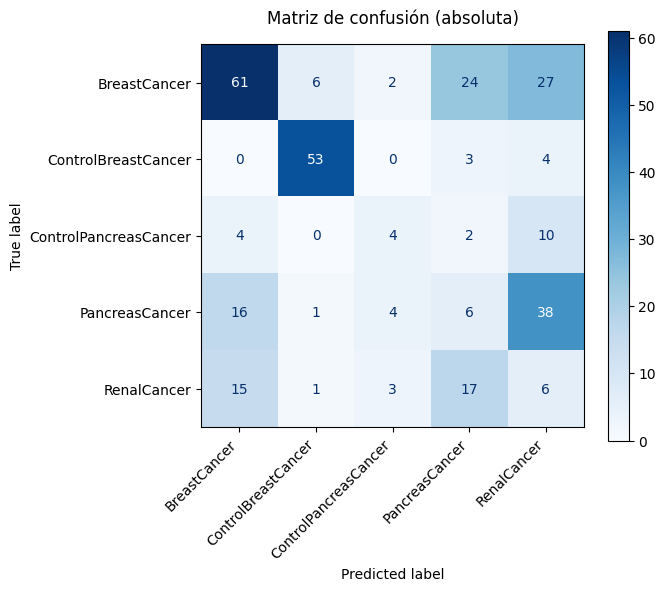

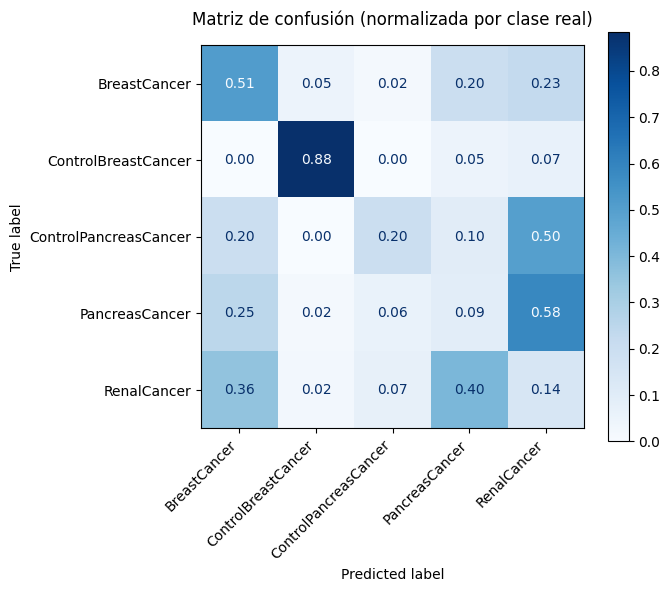


=== Métricas por clase (OOF) — Logistic Regression con ComBat ===
                       precision    recall        f1  soporte
BreastCancer            0.635417  0.508333  0.564815    120.0
ControlBreastCancer     0.868852  0.883333  0.876033     60.0
ControlPancreasCancer   0.307692  0.200000  0.242424     20.0
PancreasCancer          0.115385  0.092308  0.102564     65.0
RenalCancer             0.070588  0.142857  0.094488     42.0
macro_avg               0.399587  0.365366  0.376065      NaN
micro_avg               0.423453  0.423453  0.423453    307.0


In [181]:
# ============================================================
# Logistic Regression (CON ComBat)
# ============================================================

RANDOM_STATE = 42

X_use = Xc_scaled_df.copy()
y_use = y_5c.reindex(X_use.index)

if X_use.isna().any().any():
    print("[AVISO] NaNs detectados en Xc_scaled_df; imputo mediana para poder evaluar.")
    X_eval = X_use.fillna(X_use.median())
else:
    X_eval = X_use

# Pipeline: escalado -> LogisticRegression
pipe_lr_cb = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        multi_class="multinomial",
        solver="saga",
        penalty="l2",
        class_weight="balanced",
        max_iter=5000,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Evaluación CV (métricas ampliadas)
scoring = {
    "accuracy": "accuracy",
    "macro_f1": make_scorer(f1_score, average="macro"),
    "macro_f1_safe": make_scorer(f1_score, average="macro", zero_division=0),
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "auc_ovr_macro": make_scorer(
        roc_auc_score, needs_proba=True, multi_class="ovr", average="macro"
    ),
}

res_lr_combat = cross_validate(
    pipe_lr_cb, X_eval, y_use,
    cv=cv, scoring=scoring,
    n_jobs=-1, return_train_score=False
)

res_lr_combat = pd.DataFrame(res_lr_combat)
res_lr_combat.loc["mean"] = res_lr_combat.mean(numeric_only=True)

print("\n=== Logistic Regression (CON ComBat) · CV Estratificada (k=5) ===")
print(res_lr_combat[[
    "test_accuracy", "test_macro_f1", "test_macro_f1_safe",
    "test_balanced_acc", "test_auc_ovr_macro", "fit_time"
]])

# Probabilidades y predicciones OOF
proba_oof = cross_val_predict(
    pipe_lr_cb, X_eval, y_use, cv=cv, method="predict_proba", n_jobs=-1
)

# Alineo el orden de clases y obtengo etiquetas predichas
pipe_lr_cb.fit(X_eval, y_use)
classes_ = pipe_lr_cb.named_steps["lr"].classes_
pred_idx = np.argmax(proba_oof, axis=1)
pred_labels = np.array([classes_[i] for i in pred_idx])

# Métricas OOF globales
acc_oof = accuracy_score(y_use, pred_labels)
try:
    auc_ovr_macro_oof = roc_auc_score(y_use, proba_oof, multi_class="ovr", average="macro")
except Exception:
    auc_ovr_macro_oof = np.nan

print(f"\n[OOF] Accuracy: {acc_oof:.4f} · AUC OvR (macro): {auc_ovr_macro_oof:.4f}")

# Matrices de confusión (sklearn)
cm = confusion_matrix(y_use, pred_labels, labels=classes_)
cm_norm = confusion_matrix(y_use, pred_labels, labels=classes_, normalize="true")

# Absoluta
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
ax.set_title("Matriz de confusión (absoluta)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Normalizada por clase real
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
ax.set_title("Matriz de confusión (normalizada por clase real)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Precisión, recall y F1 por clase (OOF)
prec, rec, f1, support = precision_recall_fscore_support(
    y_use, pred_labels, labels=classes_, zero_division=0
)

per_class_lr_combat = pd.DataFrame({
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "soporte": support
}, index=classes_)

per_class_lr_combat.loc["macro_avg"] = per_class_lr_combat.iloc[:, :3].mean()
per_class_lr_combat.loc["micro_avg"] = [
    acc_oof,  # precisión micro == recall micro == accuracy global
    acc_oof,
    f1_score(y_use, pred_labels, average="micro"),
    support.sum()
]

print("\n=== Métricas por clase (OOF) — Logistic Regression con ComBat ===")
print(per_class_lr_combat)


---
**Resultados**

---
- Balanced Accuracy --> 0.78.
- Macro F1 --> Mantiene los NaNs (alguna clase no predicha).
- La clase problemática es **ControlPancreasCancer**, ya que en varios folds el **Recall = 0 o la Precisión = 0**, explicando así porque el macro-F1 gloabl es NaNs.

Es decir, ni RF ni LR con *class_weight* ni SMOTE global han logrado estabilizar la predicción de **ControlPancreasCancer**.

Voy a intentar varias cosas diferentes:
- Uso de SMOTE focalizado --> Es decir, aumentar específicamente solo ControlPancreasCancer (en vez de todas las minoritarias).

- Ajuste manual de class_weight --> darle un peso mayor que el automático a ControlPancreasCancer.

- Probar un clasificador distinto (p.ej. SVM lineal o XGBoost) para ver si maneja mejor esa clase.

Voy a pobar con SMOTE focalizado en **ControlPancreasCancer** y con Logistic Regression. De momento utilizo el dataset sin ComBat pq estoy obteniendo mejores resultados.

[INFO] X_use (SIN ComBat, focal SMOTE): (307, 135)
[INFO] Conteo de clases:
 label_5c
BreastCancer             120
PancreasCancer            65
ControlBreastCancer       60
RenalCancer               42
ControlPancreasCancer     20
Name: count, dtype: int64

=== LR + SMOTE focalizado (ControlPancreasCancer) · CV Estratificada (k=5) ===
      test_accuracy  test_macro_f1  test_macro_f1_safe  test_balanced_acc  \
0          0.838710       0.710390            0.710390           0.735897   
1          0.854839       0.787777            0.787777           0.806410   
2          0.868852       0.730462            0.730462           0.738462   
3          0.852459       0.767080            0.767080           0.770513   
4          0.918033       0.820106            0.820106           0.819231   
mean       0.866579       0.763163            0.763163           0.774103   

      test_auc_ovr_macro  fit_time  
0                    NaN  5.919871  
1                    NaN  6.102130  
2           

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



[OOF] Accuracy: 0.8730 · AUC OvR (macro): 0.9498


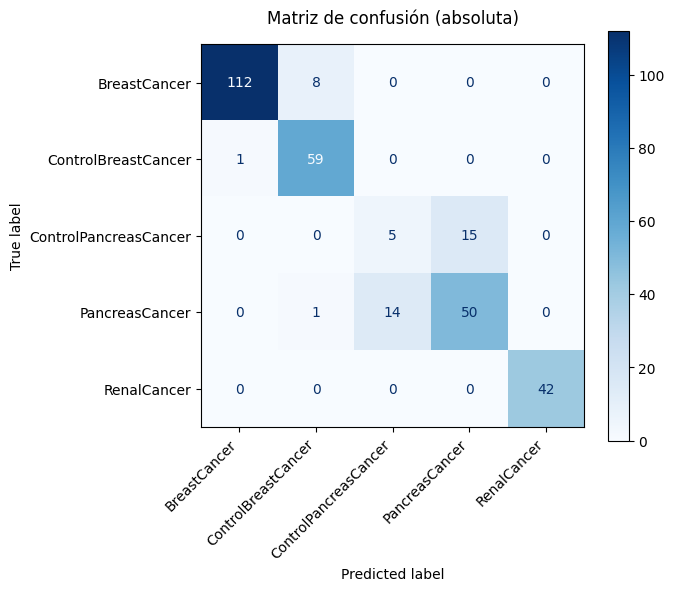

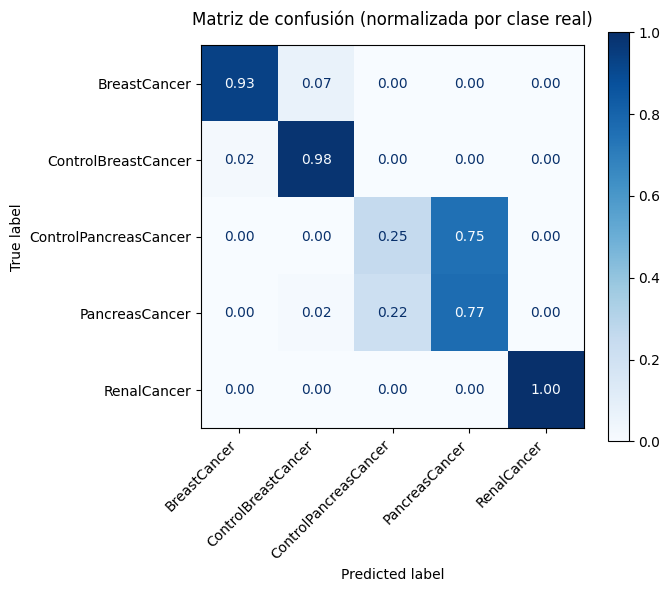


=== Métricas por clase (OOF) — LR + SMOTE focalizado sin ComBat ===
                       precision    recall        f1  soporte
BreastCancer            0.991150  0.933333  0.961373    120.0
ControlBreastCancer     0.867647  0.983333  0.921875     60.0
ControlPancreasCancer   0.263158  0.250000  0.256410     20.0
PancreasCancer          0.769231  0.769231  0.769231     65.0
RenalCancer             1.000000  1.000000  1.000000     42.0
macro_avg               0.778237  0.787179  0.781778      NaN
micro_avg               0.872964  0.872964  0.872964    307.0


In [183]:
# ========================================================
# LR + SMOTE focalizado (ControlPancreasCancer) SIN ComBat
# ========================================================

RANDOM_STATE = 42

X_use = Xi.copy()
y_use = y_5c.reindex(X_use.index)

print(f"[INFO] X_use (SIN ComBat, focal SMOTE): {X_use.shape}")
print("[INFO] Conteo de clases:\n", y_use.value_counts())

if X_use.isna().any().any():
    print("[AVISO] NaNs detectados en Xi; imputo mediana.")
    X_eval = X_use.fillna(X_use.median())
else:
    X_eval = X_use

# SMOTE seguro (evita intentar oversampling en clases ausentes) --> Me fallaba en algún fold
class SafeSMOTE(SMOTE):
    def fit_resample(self, X, y):
        y_series = pd.Series(y)
        present_classes = set(y_series.unique())
        # copia solo las clases presentes en el fold
        ss = {k: v for k, v in self.sampling_strategy.items() if k in present_classes}
        if not ss:
            return X, y  # no hay clases para sobremuestrear (me fallaba pq había algún fold sin la clase de ControlPancreasCancer)
        self.sampling_strategy = ss
        return super().fit_resample(X, y)

# Métricas y CV
scoring = {
    "accuracy": "accuracy",
    "macro_f1": make_scorer(f1_score, average="macro"),
    "macro_f1_safe": make_scorer(f1_score, average="macro", zero_division=0),
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "auc_ovr_macro": make_scorer(
        roc_auc_score, needs_proba=True, multi_class="ovr", average="macro"
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Pipeline: SMOTE focalizado -> escalado -> LR
target_size = 65
sampling_strategy = {"ControlPancreasCancer": target_size}

pipe_lr_smote_focal = Pipeline(steps=[
    ("smote", SafeSMOTE(
        sampling_strategy=sampling_strategy,
        k_neighbors=3,
        random_state=RANDOM_STATE
    )),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        multi_class="multinomial",
        solver="saga",
        penalty="l2",
        class_weight="balanced",
        max_iter=5000,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# Evaluación CV
res = cross_validate(
    pipe_lr_smote_focal,
    X_eval, y_use,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

res_lr_smote_focal = pd.DataFrame(res)
res_lr_smote_focal.loc['mean'] = res_lr_smote_focal.mean(numeric_only=True)

print("\n=== LR + SMOTE focalizado (ControlPancreasCancer) · CV Estratificada (k=5) ===")
print(res_lr_smote_focal[[
    "test_accuracy", "test_macro_f1", "test_macro_f1_safe",
    "test_balanced_acc", "test_auc_ovr_macro", "fit_time"
]])

# OOF para matriz de confusión y métricas por clase
proba_oof = cross_val_predict(
    pipe_lr_smote_focal, X_eval, y_use, cv=cv, method="predict_proba", n_jobs=-1
)

pipe_lr_smote_focal.fit(X_eval, y_use)
classes_ = pipe_lr_smote_focal.named_steps["lr"].classes_
pred_idx = np.argmax(proba_oof, axis=1)
pred_labels = np.array([classes_[i] for i in pred_idx])

# Métricas OOF globales
acc_oof = accuracy_score(y_use, pred_labels)
try:
    auc_ovr_macro_oof = roc_auc_score(y_use, proba_oof, multi_class="ovr", average="macro")
except Exception:
    auc_ovr_macro_oof = np.nan

print(f"\n[OOF] Accuracy: {acc_oof:.4f} · AUC OvR (macro): {auc_ovr_macro_oof:.4f}")

# Matrices de confusión (sklearn)
cm = confusion_matrix(y_use, pred_labels, labels=classes_)
cm_norm = confusion_matrix(y_use, pred_labels, labels=classes_, normalize="true")

# Absoluta
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
ax.set_title("Matriz de confusión (absoluta)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Normalizada por clase real
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
ax.set_title("Matriz de confusión (normalizada por clase real)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Precisión, recall y F1 por clase (OOF)
prec, rec, f1, support = precision_recall_fscore_support(
    y_use, pred_labels, labels=classes_, zero_division=0
)

per_class_lr_smote_focal = pd.DataFrame({
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "soporte": support
}, index=classes_)

per_class_lr_smote_focal.loc["macro_avg"] = per_class_lr_smote_focal.iloc[:, :3].mean()
per_class_lr_smote_focal.loc["micro_avg"] = [
    acc_oof,
    acc_oof,
    f1_score(y_use, pred_labels, average="micro"),
    support.sum()
]

print("\n=== Métricas por clase (OOF) — LR + SMOTE focalizado sin ComBat ===")
print(per_class_lr_smote_focal)


#### **SVM lineal (balanced) SIN ComBat**

Voy a probar con otro clasificador (SVM lineal), para ver si consigo eliminar la problemática del desbalanceo.

[INFO] X_use (SIN ComBat, para SVM lineal): (307, 135)
[INFO] Conteo de clases:
 label_5c
BreastCancer             120
PancreasCancer            65
ControlBreastCancer       60
RenalCancer               42
ControlPancreasCancer     20
Name: count, dtype: int64

=== SVM lineal (SIN ComBat) · CV Estratificada (k=5) ===
      test_accuracy  test_macro_f1  test_macro_f1_safe  test_balanced_acc  \
0          0.854839       0.721587            0.721587           0.744231   
1          0.919355       0.833129            0.833129           0.816667   
2          0.885246       0.736682            0.736682           0.752564   
3          0.901639       0.752740            0.752740           0.767949   
4          0.868852       0.717949            0.717949           0.733333   
mean       0.885986       0.752417            0.752417           0.762949   

      test_auc_ovr_macro  fit_time  
0                    NaN  2.146975  
1                    NaN  2.248418  
2                    NaN  2.61

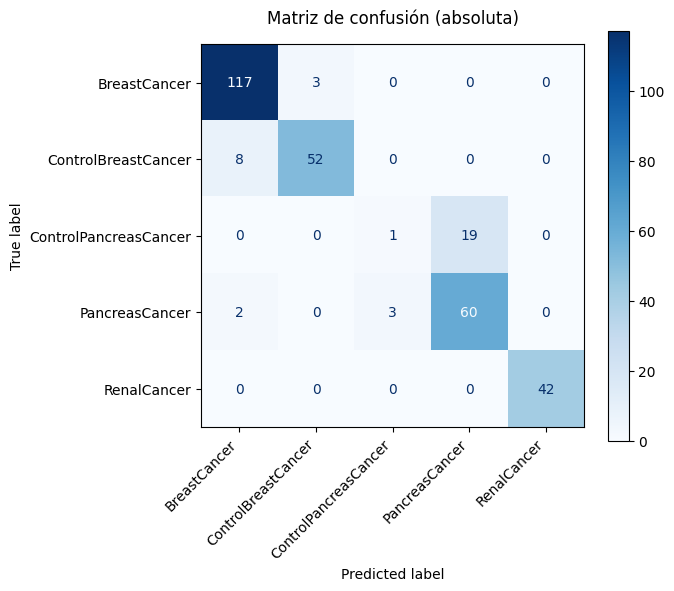

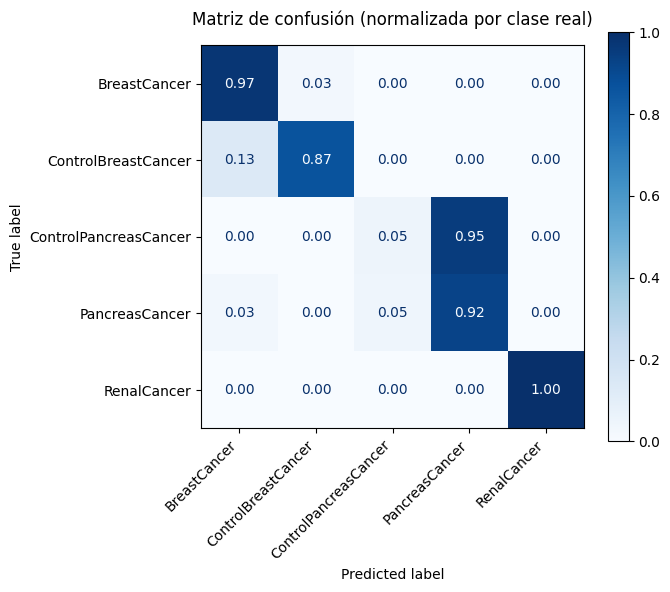


=== Métricas por clase (OOF) — SVM lineal sin ComBat ===
                       precision    recall        f1  soporte
BreastCancer            0.921260  0.975000  0.947368    120.0
ControlBreastCancer     0.945455  0.866667  0.904348     60.0
ControlPancreasCancer   0.250000  0.050000  0.083333     20.0
PancreasCancer          0.759494  0.923077  0.833333     65.0
RenalCancer             1.000000  1.000000  1.000000     42.0
macro_avg               0.775242  0.762949  0.753677      NaN
micro_avg               0.885993  0.885993  0.885993    307.0


In [186]:
# ============================
# SVM lineal (SIN ComBat)
# ============================

RANDOM_STATE = 42

X_use = Xi.copy()
y_use = y_5c.reindex(X_use.index)

print(f"[INFO] X_use (SIN ComBat, para SVM lineal): {X_use.shape}")
print("[INFO] Conteo de clases:\n", y_use.value_counts())

if X_use.isna().any().any():
    print("[AVISO] NaNs detectados en Xi; imputo mediana.")
    X_eval = X_use.fillna(X_use.median())
else:
    X_eval = X_use

scoring = {
    "accuracy": "accuracy",
    "macro_f1": make_scorer(f1_score, average="macro"),
    "macro_f1_safe": make_scorer(f1_score, average="macro", zero_division=0),
    "balanced_acc": make_scorer(balanced_accuracy_score),
    # AUC requiere probabilidades -> lo manejo con CalibratedClassifierCV
    "auc_ovr_macro": make_scorer(
        roc_auc_score, needs_proba=True, multi_class="ovr", average="macro"
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# ============================================
# Pipeline: escalado -> SVM lineal calibrado
# ============================================
# LinearSVC no da probabilidades, así que lo envuelvo con CalibratedClassifierCV
base_svm = LinearSVC(
    class_weight="balanced",
    C=1.0,
    max_iter=5000,
    random_state=RANDOM_STATE
)

pipe_svm = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svm", CalibratedClassifierCV(base_svm, method="sigmoid", cv=3))
])

# Evaluación CV
res = cross_validate(
    pipe_svm,
    X_eval, y_use,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

res_svm_no_combat = pd.DataFrame(res)
res_svm_no_combat.loc["mean"] = res_svm_no_combat.mean(numeric_only=True)

print("\n=== SVM lineal (SIN ComBat) · CV Estratificada (k=5) ===")
print(res_svm_no_combat[[
    "test_accuracy", "test_macro_f1", "test_macro_f1_safe",
    "test_balanced_acc", "test_auc_ovr_macro", "fit_time"
]])

# OOF para matriz de confusión y métricas por clase
proba_oof = cross_val_predict(
    pipe_svm, X_eval, y_use, cv=cv, method="predict_proba", n_jobs=-1
)

pipe_svm.fit(X_eval, y_use)
classes_ = pipe_svm.named_steps["svm"].classes_
pred_idx = np.argmax(proba_oof, axis=1)
pred_labels = np.array([classes_[i] for i in pred_idx])

# Métricas OOF globales
acc_oof = accuracy_score(y_use, pred_labels)
try:
    auc_ovr_macro_oof = roc_auc_score(y_use, proba_oof, multi_class="ovr", average="macro")
except Exception:
    auc_ovr_macro_oof = np.nan

print(f"\n[OOF] Accuracy: {acc_oof:.4f} · AUC OvR (macro): {auc_ovr_macro_oof:.4f}")

# Matrices de confusión (sklearn)
cm = confusion_matrix(y_use, pred_labels, labels=classes_)
cm_norm = confusion_matrix(y_use, pred_labels, labels=classes_, normalize="true")

# Absoluta
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
ax.set_title("Matriz de confusión (absoluta)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Normalizada por clase real
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
ax.set_title("Matriz de confusión (normalizada por clase real)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Precisión, recall y F1 por clase (OOF)
prec, rec, f1, support = precision_recall_fscore_support(
    y_use, pred_labels, labels=classes_, zero_division=0
)

per_class_svm_no_combat = pd.DataFrame({
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "soporte": support
}, index=classes_)

per_class_svm_no_combat.loc["macro_avg"] = per_class_svm_no_combat.iloc[:, :3].mean()
per_class_svm_no_combat.loc["micro_avg"] = [
    acc_oof,
    acc_oof,
    f1_score(y_use, pred_labels, average="micro"),
    support.sum()
]

print("\n=== Métricas por clase (OOF) — SVM lineal sin ComBat ===")
print(per_class_svm_no_combat)


---
**Resultados**

---
- Balanced Accuracy --> 0.77.
- Macro F1 --> Mantiene los NaNs.



In [ ]:
# ============================
# SVM lineal (CON ComBat)
# ============================

RANDOM_STATE = 42

X_use = Xc_scaled_df.copy()
y_use = y_5c.reindex(X_use.index)

print(f"[INFO] X_use (CON ComBat, para SVM lineal): {X_use.shape}")
print("[INFO] Conteo de clases:\n", y_use.value_counts())

if X_use.isna().any().any():
    print("[AVISO] NaNs detectados en Xc_scaled; imputo mediana.")
    X_eval = X_use.fillna(X_use.median())
else:
    X_eval = X_use

# Métricas y CV
scoring = {
    "accuracy": "accuracy",
    "macro_f1": make_scorer(f1_score, average="macro"),
    "macro_f1_safe": make_scorer(f1_score, average="macro", zero_division=0),
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "auc_ovr_macro": make_scorer(
        roc_auc_score, needs_proba=True, multi_class="ovr", average="macro"
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Pipeline: escalado -> SVM lineal calibrado
base_svm_cb = LinearSVC(
    class_weight="balanced",
    C=1.0,
    max_iter=5000,
    random_state=RANDOM_STATE
)

pipe_svm_cb = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svm", CalibratedClassifierCV(base_svm_cb, method="sigmoid", cv=3))
])

# Evaluación CV
res = cross_validate(
    pipe_svm_cb,
    X_eval, y_use,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

res_svm_combat = pd.DataFrame(res)
res_svm_combat.loc['mean'] = res_svm_combat.mean(numeric_only=True)

print("\n=== SVM lineal (CON ComBat) · CV Estratificada (k=5) ===")
print(res_svm_combat[[
    "test_accuracy", "test_macro_f1", "test_macro_f1_safe",
    "test_balanced_acc", "test_auc_ovr_macro", "fit_time"
]])

# OOF para matriz de confusión y métricas por clase
proba_oof = cross_val_predict(
    pipe_svm_cb, X_eval, y_use, cv=cv, method="predict_proba", n_jobs=-1
)

pipe_svm_cb.fit(X_eval, y_use)
classes_ = pipe_svm_cb.named_steps["svm"].classes_
pred_idx = np.argmax(proba_oof, axis=1)
pred_labels = np.array([classes_[i] for i in pred_idx])

# Métricas OOF globales
acc_oof = accuracy_score(y_use, pred_labels)
try:
    auc_ovr_macro_oof = roc_auc_score(y_use, proba_oof, multi_class="ovr", average="macro")
except Exception:
    auc_ovr_macro_oof = np.nan

print(f"\n[OOF] Accuracy: {acc_oof:.4f} · AUC OvR (macro): {auc_ovr_macro_oof:.4f}")

# Matrices de confusión (sklearn)
cm = confusion_matrix(y_use, pred_labels, labels=classes_)
cm_norm = confusion_matrix(y_use, pred_labels, labels=classes_, normalize="true")

# Absoluta
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
ax.set_title("Matriz de confusión (absoluta)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Normalizada por clase real
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
ax.set_title("Matriz de confusión (normalizada por clase real)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Precisión, recall y F1 por clase (OOF)
prec, rec, f1, support = precision_recall_fscore_support(
    y_use, pred_labels, labels=classes_, zero_division=0
)

per_class_svm_combat = pd.DataFrame({
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "soporte": support
}, index=classes_)

per_class_svm_combat.loc["macro_avg"] = per_class_svm_combat.iloc[:, :3].mean()
per_class_svm_combat.loc["micro_avg"] = [
    acc_oof,
    acc_oof,
    f1_score(y_use, pred_labels, average="micro"),
    support.sum()
]

print("\n=== Métricas por clase (OOF) — SVM lineal con ComBat ===")
print(per_class_svm_combat)


#### **Gradient Boosting**

Voy a probar con otro modelo, esta vez un modelo de boosting nativo de scikit-learn como es Gradient Boost.


[INFO] X_use (SIN ComBat, para Gradient Boosting): (307, 135)
[INFO] Conteo de clases:
 label_5c
BreastCancer             120
PancreasCancer            65
ControlBreastCancer       60
RenalCancer               42
ControlPancreasCancer     20
Name: count, dtype: int64

=== Gradient Boosting (SIN ComBat) · CV Estratificada (k=5) ===
      test_accuracy  test_macro_f1  test_macro_f1_safe  test_balanced_acc  \
0          0.903226       0.872294            0.872294           0.866667   
1          0.870968       0.728751            0.728751           0.751282   
2          0.918033       0.822075            0.822075           0.826282   
3          0.868852       0.784939            0.784939           0.792949   
4          0.901639       0.752740            0.752740           0.767949   
mean       0.892544       0.792160            0.792160           0.801026   

      test_auc_ovr_macro   fit_time  
0                    NaN  12.540403  
1                    NaN  13.658344  
2            

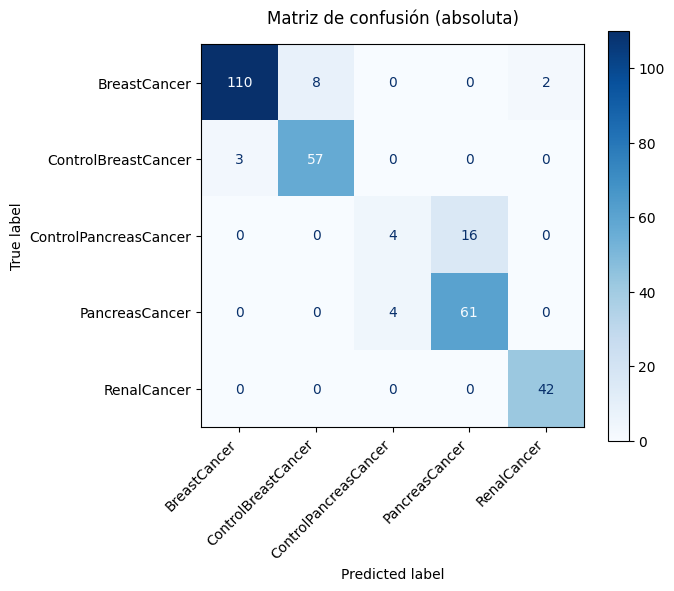

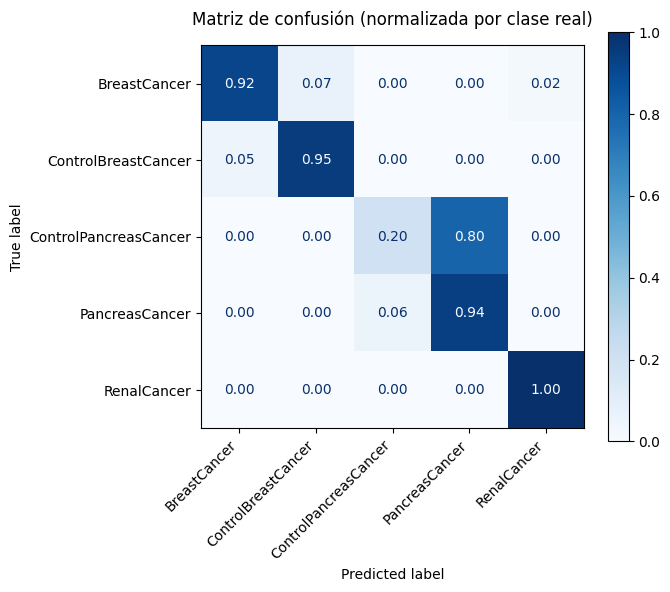


=== Métricas por clase (OOF) — Gradient Boosting sin ComBat ===
                       precision    recall        f1  soporte
BreastCancer            0.973451  0.916667  0.944206    120.0
ControlBreastCancer     0.876923  0.950000  0.912000     60.0
ControlPancreasCancer   0.500000  0.200000  0.285714     20.0
PancreasCancer          0.792208  0.938462  0.859155     65.0
RenalCancer             0.954545  1.000000  0.976744     42.0
macro_avg               0.819426  0.801026  0.795564      NaN
micro_avg               0.892508  0.892508  0.892508    307.0


In [187]:
# ============================
# Gradient Boosting (SIN ComBat)
# ============================

RANDOM_STATE = 42

X_use = Xi.copy()
y_use = y_5c.reindex(X_use.index)

print(f"[INFO] X_use (SIN ComBat, para Gradient Boosting): {X_use.shape}")
print("[INFO] Conteo de clases:\n", y_use.value_counts())

if X_use.isna().any().any():
    print("[AVISO] NaNs detectados en Xi; imputo mediana.")
    X_eval = X_use.fillna(X_use.median())
else:
    X_eval = X_use

# Métricas y CV
scoring = {
    "accuracy": "accuracy",
    "macro_f1": make_scorer(f1_score, average="macro"),
    "macro_f1_safe": make_scorer(f1_score, average="macro", zero_division=0),
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "auc_ovr_macro": make_scorer(
        roc_auc_score, needs_proba=True, multi_class="ovr", average="macro"
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Modelo: HistGradientBoostingClassifier
gb_clf = HistGradientBoostingClassifier(
    class_weight="balanced",
    learning_rate=0.1,
    max_depth=None,
    max_iter=300,
    random_state=RANDOM_STATE
)

# Evaluación CV
res = cross_validate(
    gb_clf,
    X_eval, y_use,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

res_gb_no_combat = pd.DataFrame(res)
res_gb_no_combat.loc['mean'] = res_gb_no_combat.mean(numeric_only=True)

print("\n=== Gradient Boosting (SIN ComBat) · CV Estratificada (k=5) ===")
print(res_gb_no_combat[[
    "test_accuracy", "test_macro_f1", "test_macro_f1_safe",
    "test_balanced_acc", "test_auc_ovr_macro", "fit_time"
]])

# OOF para matriz de confusión y métricas por clase
proba_oof = cross_val_predict(
    gb_clf, X_eval, y_use, cv=cv, method="predict_proba", n_jobs=-1
)

gb_clf.fit(X_eval, y_use)
classes_ = gb_clf.classes_
pred_idx = np.argmax(proba_oof, axis=1)
pred_labels = np.array([classes_[i] for i in pred_idx])

# Métricas OOF globales
acc_oof = accuracy_score(y_use, pred_labels)
try:
    auc_ovr_macro_oof = roc_auc_score(y_use, proba_oof, multi_class="ovr", average="macro")
except Exception:
    auc_ovr_macro_oof = np.nan

print(f"\n[OOF] Accuracy: {acc_oof:.4f} · AUC OvR (macro): {auc_ovr_macro_oof:.4f}")

# Matrices de confusión (sklearn)
cm = confusion_matrix(y_use, pred_labels, labels=classes_)
cm_norm = confusion_matrix(y_use, pred_labels, labels=classes_, normalize="true")

# Absoluta
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
ax.set_title("Matriz de confusión (absoluta)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Normalizada por clase real
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
ax.set_title("Matriz de confusión (normalizada por clase real)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Precisión, recall y F1 por clase (OOF)
prec, rec, f1, support = precision_recall_fscore_support(
    y_use, pred_labels, labels=classes_, zero_division=0
)

per_class_gb_no_combat = pd.DataFrame({
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "soporte": support
}, index=classes_)

per_class_gb_no_combat.loc["macro_avg"] = per_class_gb_no_combat.iloc[:, :3].mean()
per_class_gb_no_combat.loc["micro_avg"] = [
    acc_oof,
    acc_oof,
    f1_score(y_use, pred_labels, average="micro"),
    support.sum()
]

print("\n=== Métricas por clase (OOF) — Gradient Boosting sin ComBat ===")
print(per_class_gb_no_combat)


---
**Resultados**

---
- Balanced Accuracy --> 0.80 (Bastante bueno).
- Macro F1 --> Mantiene los NaNs.



[INFO] X_use (CON ComBat, para Gradient Boosting): (307, 135)
[INFO] Conteo de clases:
 label_5c
BreastCancer             120
PancreasCancer            65
ControlBreastCancer       60
RenalCancer               42
ControlPancreasCancer     20
Name: count, dtype: int64

=== Gradient Boosting (CON ComBat) · CV Estratificada (k=5) ===
      test_accuracy  test_macro_f1  test_macro_f1_safe  test_balanced_acc  \
0          0.822581       0.741046            0.741046           0.748504   
1          0.903226       0.843346            0.843346           0.831838   
2          0.934426       0.841895            0.841895           0.825000   
3          0.885246       0.795850            0.795850           0.784615   
4          0.852459       0.756177            0.756177           0.737179   
mean       0.879588       0.795663            0.795663           0.785427   

      test_auc_ovr_macro   fit_time  
0                    NaN  11.982866  
1                    NaN  11.516191  
2            

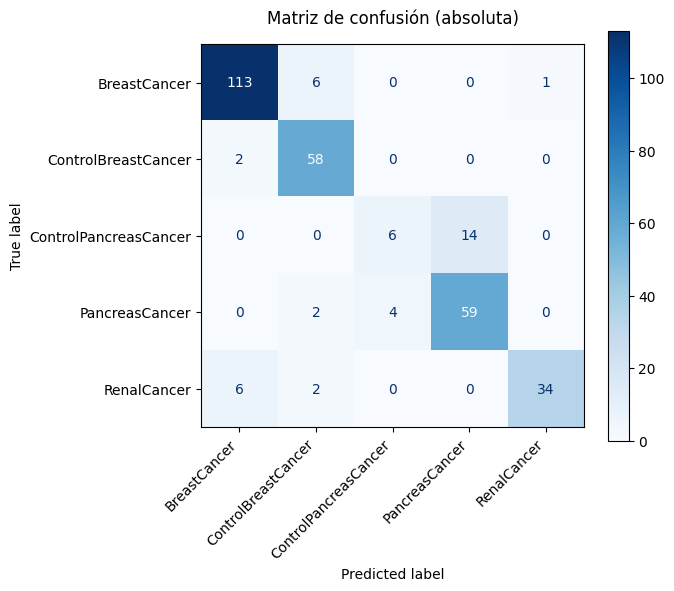

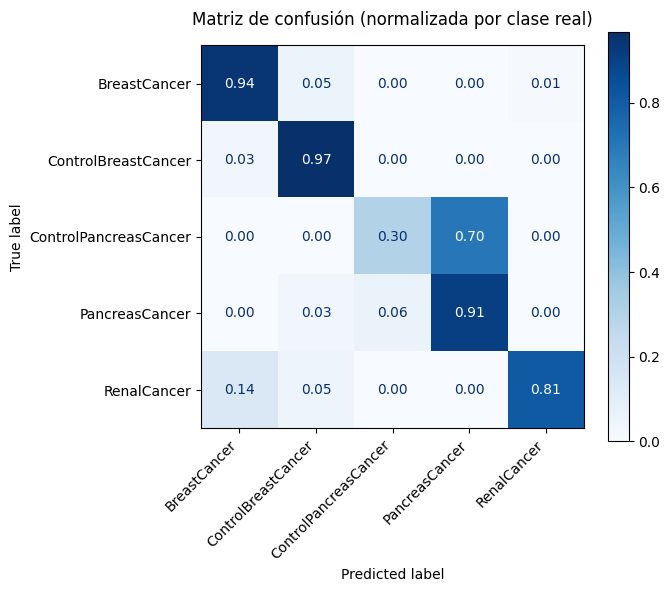


=== Métricas por clase (OOF) — Gradient Boosting con ComBat ===
                       precision    recall        f1  soporte
BreastCancer            0.933884  0.941667  0.937759    120.0
ControlBreastCancer     0.852941  0.966667  0.906250     60.0
ControlPancreasCancer   0.600000  0.300000  0.400000     20.0
PancreasCancer          0.808219  0.907692  0.855072     65.0
RenalCancer             0.971429  0.809524  0.883117     42.0
macro_avg               0.833295  0.785110  0.796440      NaN
micro_avg               0.879479  0.879479  0.879479    307.0


In [188]:
# ===================================
# Gradient Boosting (CON ComBat)
# ===================================

RANDOM_STATE = 42

X_use = Xc_scaled_df.copy()
y_use = y_5c.reindex(X_use.index)

print(f"[INFO] X_use (CON ComBat, para Gradient Boosting): {X_use.shape}")
print("[INFO] Conteo de clases:\n", y_use.value_counts())

if X_use.isna().any().any():
    print("[AVISO] NaNs detectados en Xc_scaled; imputo mediana.")
    X_eval = X_use.fillna(X_use.median())
else:
    X_eval = X_use

# Métricas y CV
scoring = {
    "accuracy": "accuracy",
    "macro_f1": make_scorer(f1_score, average="macro"),
    "macro_f1_safe": make_scorer(f1_score, average="macro", zero_division=0),
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "auc_ovr_macro": make_scorer(
        roc_auc_score, needs_proba=True, multi_class="ovr", average="macro"
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Modelo: HistGradientBoostingClassifier
gb_clf_cb = HistGradientBoostingClassifier(
    class_weight="balanced",
    learning_rate=0.1,
    max_depth=None,
    max_iter=300,
    random_state=RANDOM_STATE
)

# Evaluación CV
res = cross_validate(
    gb_clf_cb,
    X_eval, y_use,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

res_gb_combat = pd.DataFrame(res)
res_gb_combat.loc['mean'] = res_gb_combat.mean(numeric_only=True)

print("\n=== Gradient Boosting (CON ComBat) · CV Estratificada (k=5) ===")
print(res_gb_combat[[
    "test_accuracy", "test_macro_f1", "test_macro_f1_safe",
    "test_balanced_acc", "test_auc_ovr_macro", "fit_time"
]])

# OOF para matriz de confusión y métricas por clase
proba_oof = cross_val_predict(
    gb_clf_cb, X_eval, y_use, cv=cv, method="predict_proba", n_jobs=-1
)

gb_clf_cb.fit(X_eval, y_use)
classes_ = gb_clf_cb.classes_
pred_idx = np.argmax(proba_oof, axis=1)
pred_labels = np.array([classes_[i] for i in pred_idx])

# Métricas OOF globales
acc_oof = accuracy_score(y_use, pred_labels)
try:
    auc_ovr_macro_oof = roc_auc_score(y_use, proba_oof, multi_class="ovr", average="macro")
except Exception:
    auc_ovr_macro_oof = np.nan

print(f"\n[OOF] Accuracy: {acc_oof:.4f} · AUC OvR (macro): {auc_ovr_macro_oof:.4f}")

# Matrices de confusión (sklearn)
cm = confusion_matrix(y_use, pred_labels, labels=classes_)
cm_norm = confusion_matrix(y_use, pred_labels, labels=classes_, normalize="true")

# Absoluta
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
ax.set_title("Matriz de confusión (absoluta)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Normalizada por clase real
fig, ax = plt.subplots(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
ax.set_title("Matriz de confusión (normalizada por clase real)", fontsize=12, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Precisión, recall y F1 por clase (OOF)
prec, rec, f1, support = precision_recall_fscore_support(
    y_use, pred_labels, labels=classes_, zero_division=0
)

per_class_gb_combat = pd.DataFrame({
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "soporte": support
}, index=classes_)

per_class_gb_combat.loc["macro_avg"] = per_class_gb_combat.iloc[:, :3].mean()
per_class_gb_combat.loc["micro_avg"] = [
    acc_oof,
    acc_oof,
    f1_score(y_use, pred_labels, average="micro"),
    support.sum()
]

print("\n=== Métricas por clase (OOF) — Gradient Boosting con ComBat ===")
print(per_class_gb_combat)


## **Reagrupación a 4 clases**

Como ControlPancreasCancer tiene sólo 20 muestars y ningún clasificador es capaz de tartar el desbalanceo de clases. Además de que en contexto biologógico son ambos cánceres de pancreas, pero uno maligno y otro benigno. He dicidido probar a  juntar *ControlPancreasCancer* con *PancreasCancer*, obteniendo una clase de 85 muestras y evitando el desbalanceamiento.

---
**Posible texto para la memoria**

---
**Evaluación de estrategias de clasificación y balanceo de clases**


El dataset integrado incluyó inicialmente **cinco clases**: BreastCancer (120 muestras), ControlBreastCancer (60), PancreasCancer (65), ControlPancreasCancer (20) y RenalCancer (42). Esta distribución presentó un desbalance importante, con la clase más grande (BreastCancer) sextuplicando a la más pequeña (ControlPancreasCancer).

Esta situación ha generadp muchps problemas recurrentes en los modelos: la clase minoritaria no era predicha en absoluto, produciendo valores nulos en las métricas de F1 para dicha clase y, en consecuencia, en el macro-F1 global.

Para abordar este problema se han aplicado diversas estrategias:

- **Modelos base sin reequilibrio:**

Se han probado diferentes clasificadores: Random Forest, Logistic Regression, SVM lineal y Gradient Boosting tanto con los datos originales como tras corrección por lotes con ComBat.

Los resultados mostraron que el **desbalance persistía**: la clase ControlPancreasCancer quedaba sistemáticamente sin predecir, lo que reducía la robustez de las métricas globales.

- Reequilibrado de datos
Se han probado además, **técnicas de sobremuestreo (SMOTE global y focalizado)**, así como ajuste de pesos de clase (class_weight balanced y ponderaciones manuales).

Aunque estas estrategias mejoraron marginalmente la sensibilidad en clases minoritarias, no lograron estabilizar la predicción de ControlPancreasCancer. La escasez extrema de muestras (n=20) se mantuvo como el principal cuello de botella.

- **Reducción a 4 clases**
Se ha valorado la fusión de PancreasCancer y ControlPancreasCancer en una sola clase denominada Pancreas.

Este cambio ha equilibrado el dataset (85 muestras en Pancreas) y eliminado el principal foco de desbalance.

Con este escenario de 4 clases, Gradient Boosting con class_weight="balanced" alcanza un Macro-F1 ≈ 0.96, con valores F1 superiores a 0.91 en todas las clases, demostrando un rendimiento muy estable y sin valores nulos en las métricas.

**Notas adicionales:** Impacto de ComBat

La aplicación de ComBat sobre el escenario de 4 clases reduce el Macro-F1 a ≈ 0.90, debido principalmente a una caída en la clase RenalCancer (F1 ≈ 0.75).

Esto indica que, en este caso, la corrección por lote no aporta beneficio y, por el contrario, degrada el rendimiento en clases con menor número de muestras.

---
**Conclusiones**

- El análisis evidencia que el principal limitante no son los modelos, sino la distribución de clases.

- Las técnicas de balanceo (SMOTE, class_weight) no han conseguido resolver el problema cuando existía una clase extremadamente pequeña.

- La fusión de clases pancreáticas es clave para obtener un dataset equilibrado y un modelo con desempeño robusto (Macro-F1 ≈ 0.96).

- El uso de ComBat debe considerarse con cautela, ya que puede introducir ruido en clases minoritarias. En este trabajo, el mejor rendimiento se ha obtenido sin ComBat.

**Texo para la memoria**

---

**Estrategia de modelado en páncreas**

En el caso del páncreas, el dataset incluye 65 pacientes con cáncer de páncreas (mayoritariamente adenocarcinoma ductal pancreático, PDAC) y 20 pacientes con patologías benignas pancreáticas (10 con neoplasia mucinosa papilar intraductal, IPMN, y 10 con pancreatitis crónica, CP).

Desde el punto de vista clínico, la distinción entre PDAC maligno y lesiones benignas resulta de especial interés, ya que representa una de las principales preguntas diagnósticas en el uso de biopsias líquidas. Por ello, se realizó un análisis específico dentro del cohorte pancreático evaluando modelos binarios para diferenciar maligno frente a benigno. Pese al desbalance entre clases, se exploraron técnicas de rebalanceo (SMOTE, class_weight) y se utilizaron métricas robustas como AUC-ROC, F1 por clase y sensibilidad a diferentes umbrales. Este análisis proporciona información sobre la viabilidad de detectar malignidad pancreática frente a lesiones benignas en entornos reales.

Por otra parte, en el escenario multiclase global, donde se integran los datos de mama, páncreas y renal, se decidió unificar ambas clases pancreáticas (PDAC e IPMN/CP) en una sola clase “Pancreas”. La justificación es metodológica y conceptual:

Metodológicamente, la fusión reduce el desbalance extremo y evita que la clase benigna quede infrarepresentada.

Conceptualmente, este escenario busca evaluar la capacidad de los modelos para identificar el origen tumoral o la condición orgánica (mama, páncreas, renal), más que la distinción entre malignidad y benignidad en un mismo órgano.

De este modo, el TFM aborda dos niveles complementarios de análisis:

Análisis clínico específico (binario PDAC vs benigno) → orientado a la pregunta de diagnóstico diferencial en páncreas.

Análisis exploratorio multiclase (4 clases: mama, control mama, páncreas, renal) → orientado a la clasificación del origen tisular, donde los subgrupos pancreáticos se unifican para maximizar estabilidad y comparabilidad.

#### **Comparativa de clasificadores (4 clases, SIN ComBat)**


=== Comparativa de clasificadores (4 clases, SIN ComBat) · Medias CV (k=5) ===
                 Modelo  Accuracy  BalancedAcc  macro_F1  macro_F1_safe  \
0    LogisticRegression  0.967530     0.974142  0.969387       0.969387   
1             LinearSVM  0.967425     0.964583  0.967955       0.967955   
2          RandomForest  0.957641     0.956250  0.958847       0.958847   
3  HistGradientBoosting  0.954521     0.961111  0.955076       0.955076   

   AUC_OvR_macro  FitTime(s)  
0            NaN    1.675882  
1            NaN    1.434571  
2            NaN    9.187952  
3            NaN    7.339310  

=== OOF — RandomForest (4 clases, SIN ComBat) ===
[OOF] Accuracy: 0.9577 · AUC OvR (macro): 0.9943


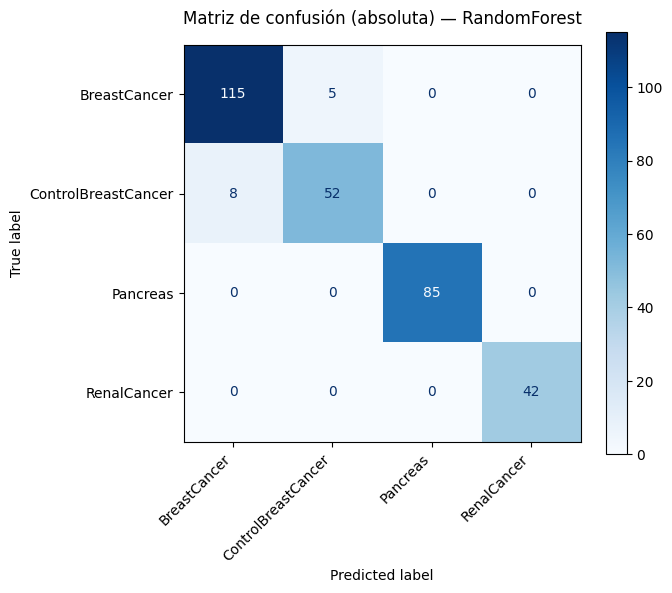

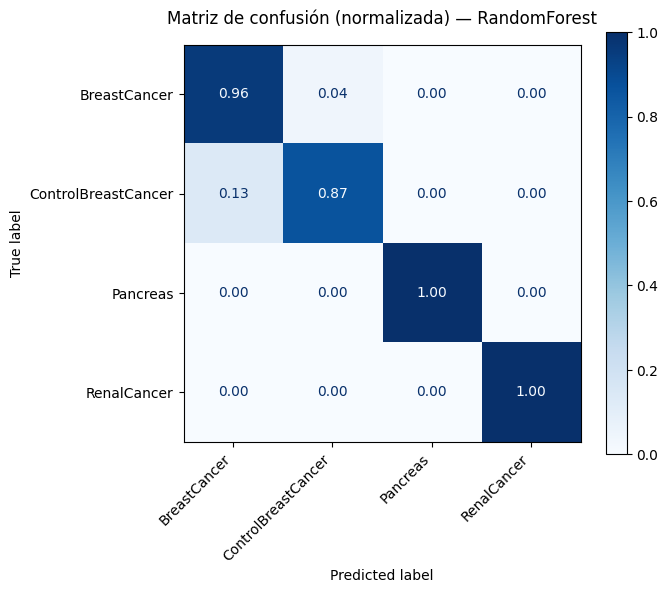

                     precision    recall        f1  soporte
BreastCancer          0.934959  0.958333  0.946502    120.0
ControlBreastCancer   0.912281  0.866667  0.888889     60.0
Pancreas              1.000000  1.000000  1.000000     85.0
RenalCancer           1.000000  1.000000  1.000000     42.0
macro_avg             0.961810  0.956250  0.958848      NaN
micro_avg             0.957655  0.957655  0.957655    307.0

=== OOF — HistGradientBoosting (4 clases, SIN ComBat) ===
[OOF] Accuracy: 0.9544 · AUC OvR (macro): 0.9937


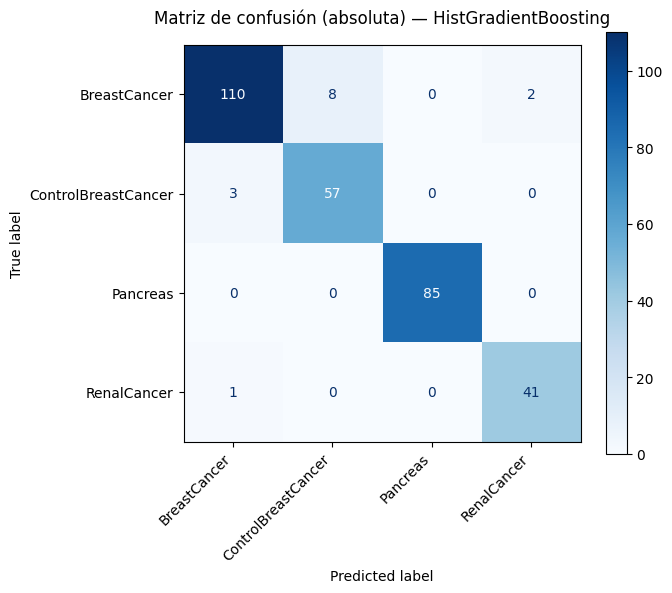

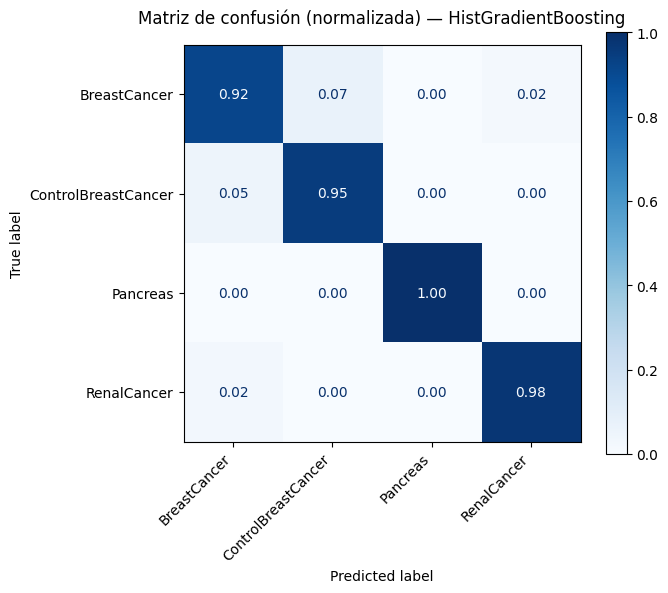

                     precision    recall        f1  soporte
BreastCancer          0.964912  0.916667  0.940171    120.0
ControlBreastCancer   0.876923  0.950000  0.912000     60.0
Pancreas              1.000000  1.000000  1.000000     85.0
RenalCancer           0.953488  0.976190  0.964706     42.0
macro_avg             0.948831  0.960714  0.954219      NaN
micro_avg             0.954397  0.954397  0.954397    307.0

=== OOF — LogisticRegression (4 clases, SIN ComBat) ===


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[OOF] Accuracy: 0.9674 · AUC OvR (macro): 0.9964


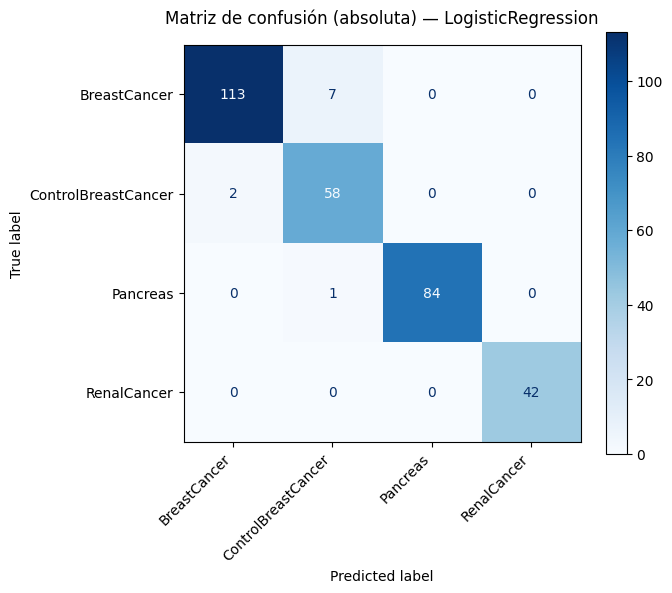

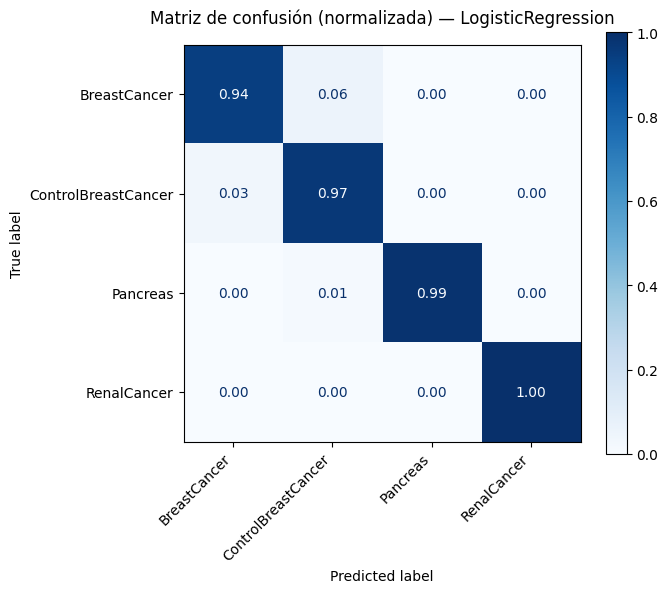

                     precision    recall        f1  soporte
BreastCancer          0.982609  0.941667  0.961702    120.0
ControlBreastCancer   0.878788  0.966667  0.920635     60.0
Pancreas              1.000000  0.988235  0.994083     85.0
RenalCancer           1.000000  1.000000  1.000000     42.0
macro_avg             0.965349  0.974142  0.969105      NaN
micro_avg             0.967427  0.967427  0.967427    307.0

=== OOF — LinearSVM (4 clases, SIN ComBat) ===
[OOF] Accuracy: 0.9674 · AUC OvR (macro): 0.9968


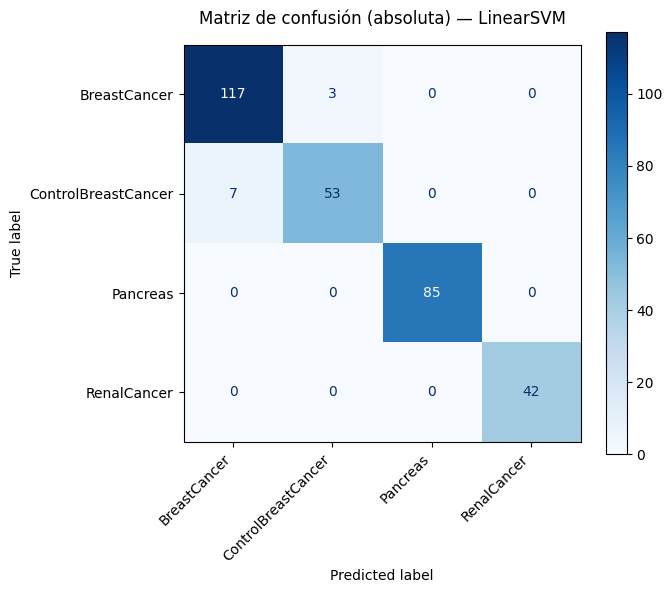

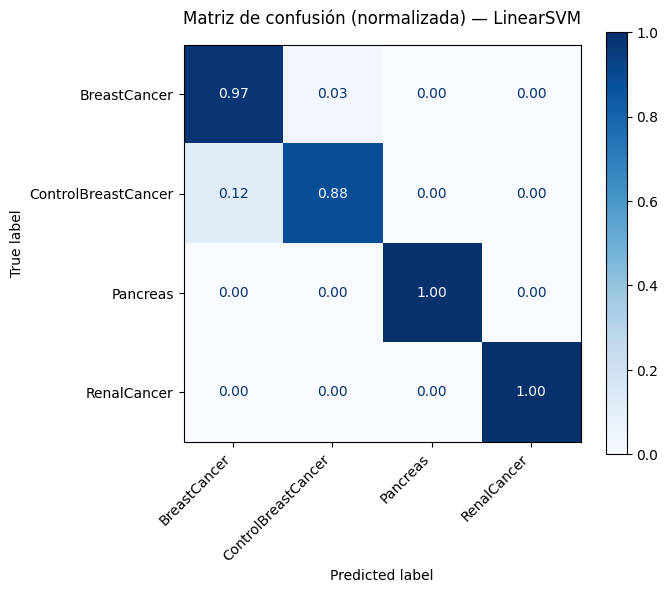

                     precision    recall        f1  soporte
BreastCancer          0.943548  0.975000  0.959016    120.0
ControlBreastCancer   0.946429  0.883333  0.913793     60.0
Pancreas              1.000000  1.000000  1.000000     85.0
RenalCancer           1.000000  1.000000  1.000000     42.0
macro_avg             0.972494  0.964583  0.968202      NaN
micro_avg             0.967427  0.967427  0.967427    307.0


In [190]:
# ========================================================
# Comparativa de clasificadores con 4 clases (SIN ComBat)
# =========================================================

RANDOM_STATE = 42

# Etiquetas 4 clases (fusiono PancreasCancer y ControlPancreasCancer)
y_4c = y_5c.replace({
    "PancreasCancer": "Pancreas",
    "ControlPancreasCancer": "Pancreas"
})

X_use = Xi.copy()
y_use = y_4c.reindex(X_use.index)

if X_use.isna().any().any():
    print("[AVISO] NaNs detectados en Xi; se imputan con mediana para evaluar.")
    X_eval = X_use.fillna(X_use.median())
else:
    X_eval = X_use

# Métricas (añado Accuracy y AUC multiclase OvR macro)
scoring = {
    "accuracy": "accuracy",
    "macro_f1": make_scorer(f1_score, average="macro"),
    "macro_f1_safe": make_scorer(f1_score, average="macro", zero_division=0),
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "auc_ovr_macro": make_scorer(
        roc_auc_score, needs_proba=True, multi_class="ovr", average="macro"
    ),
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Modelos (LinearSVM calibrado para obtener probabilidades)
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=700, max_features="sqrt",
        class_weight="balanced",
        random_state=RANDOM_STATE, n_jobs=-1
    ),
    "HistGradientBoosting": HistGradientBoostingClassifier(
        class_weight="balanced",
        learning_rate=0.1, max_iter=300,
        random_state=RANDOM_STATE
    ),
    "LogisticRegression": Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            multi_class="multinomial", solver="saga",
            penalty="l2", class_weight="balanced",
            max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
        ))
    ]),
    "LinearSVM": Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("svm_cal", CalibratedClassifierCV(
            estimator=LinearSVC(  # <-- cambio aquí
                class_weight="balanced",
                C=1.0, max_iter=5000, random_state=RANDOM_STATE
            ),
            method="sigmoid", cv=3
        ))
    ]),
}

# =============================================
# Evaluación CV · resumen de métricas globales
# =============================================
rows = []
per_model_results = {}

for name, model in models.items():
    res = cross_validate(
        model, X_eval, y_use,
        cv=cv, scoring=scoring,
        n_jobs=-1, return_train_score=False
    )
    df = pd.DataFrame(res)
    df.loc["mean"] = df.mean(numeric_only=True)
    per_model_results[name] = df

    rows.append({
        "Modelo": name,
        "Accuracy": df.loc["mean", "test_accuracy"],
        "BalancedAcc": df.loc["mean", "test_balanced_acc"],
        "macro_F1": df.loc["mean", "test_macro_f1"],
        "macro_F1_safe": df.loc["mean", "test_macro_f1_safe"],
        "AUC_OvR_macro": df.loc["mean", "test_auc_ovr_macro"],
        "FitTime(s)": df.loc["mean", "fit_time"],
    })

summary_4c = pd.DataFrame(rows).sort_values("macro_F1_safe", ascending=False).reset_index(drop=True)

print("\n=== Comparativa de clasificadores (4 clases, SIN ComBat) · Medias CV (k=5) ===")
print(summary_4c)

# ===============================================
# OOF: matrices de confusión y métricas por clase
# ===============================================
for name, model in models.items():
    print(f"\n=== OOF — {name} (4 clases, SIN ComBat) ===")
    proba_oof = cross_val_predict(
        model, X_eval, y_use, cv=cv, method="predict_proba", n_jobs=-1
    )

    model.fit(X_eval, y_use)
    if isinstance(model, Pipeline):
        last_step = list(model.named_steps.values())[-1]
        classes_ = last_step.classes_
    else:
        classes_ = model.classes_

    pred_idx = np.argmax(proba_oof, axis=1)
    pred_labels = np.array([classes_[i] for i in pred_idx])

    acc_oof = accuracy_score(y_use, pred_labels)
    try:
        auc_ovr_macro_oof = roc_auc_score(y_use, proba_oof, multi_class="ovr", average="macro")
    except Exception:
        auc_ovr_macro_oof = np.nan
    print(f"[OOF] Accuracy: {acc_oof:.4f} · AUC OvR (macro): {auc_ovr_macro_oof:.4f}")

    cm = confusion_matrix(y_use, pred_labels, labels=classes_)
    cm_norm = confusion_matrix(y_use, pred_labels, labels=classes_, normalize="true")

    fig, ax = plt.subplots(figsize=(7,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_)
    disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
    ax.set_title(f"Matriz de confusión (absoluta) — {name}", fontsize=12, pad=15)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(7,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes_)
    disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
    ax.set_title(f"Matriz de confusión (normalizada) — {name}", fontsize=12, pad=15)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    prec, rec, f1, support = precision_recall_fscore_support(
        y_use, pred_labels, labels=classes_, zero_division=0
    )
    per_class = pd.DataFrame({
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "soporte": support
    }, index=classes_)
    per_class.loc["macro_avg"] = per_class.iloc[:, :3].mean()
    per_class.loc["micro_avg"] = [
        acc_oof, acc_oof,
        f1_score(y_use, pred_labels, average="micro"),
        support.sum()
    ]
    print(per_class)


In [191]:
# ============================================================
# Guardar matrices de confusión normalizadas (LR sin ComBat)
# ============================================================

os.makedirs("content", exist_ok=True)
RANDOM_STATE = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Modelos LR (sin y con SMOTE)
lr_baseline = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        multi_class="multinomial", solver="saga",
        penalty="l2", class_weight="balanced",
        max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
    ))
])

lr_smote = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=RANDOM_STATE, k_neighbors=5)),
    ("clf", LogisticRegression(
        multi_class="multinomial", solver="saga",
        penalty="l2", class_weight=None,
        max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
    ))
])

# Función para generar y guardar matriz de confusión
def guardar_matriz_confusion(model, X, y, nombre_salida, titulo):
    """Ajusta modelo en CV y guarda matriz de confusión normalizada."""
    print(f"[INFO] Generando matriz: {titulo}")
    y_pred = cross_val_predict(model, X, y, cv=cv, method="predict", n_jobs=-1)
    classes_ = np.unique(y)
    cm = confusion_matrix(y, y_pred, labels=classes_, normalize="true")

    fig, ax = plt.subplots(figsize=(7,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_)
    disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
    ax.set_title(titulo, fontsize=12, pad=15)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    ruta = f"content/{nombre_salida}.png"
    plt.savefig(ruta, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"[OK] Guardada en: {ruta}\n")

# Generar imágenes
guardar_matriz_confusion(
    lr_baseline, X_eval, y_use,
    nombre_salida="cm_LR_sinComBat_sinSMOTE",
    titulo="Matriz de confusión (normalizada) — LR sin ComBat y sin SMOTE"
)

guardar_matriz_confusion(
    lr_smote, X_eval, y_use,
    nombre_salida="cm_LR_sinComBat_conSMOTE",
    titulo="Matriz de confusión (normalizada) — LR sin ComBat y con SMOTE"
)

[INFO] Generando matriz: Matriz de confusión (normalizada) — LR sin ComBat y sin SMOTE
[OK] Guardada en: content/cm_LR_sinComBat_sinSMOTE.png

[INFO] Generando matriz: Matriz de confusión (normalizada) — LR sin ComBat y con SMOTE
[OK] Guardada en: content/cm_LR_sinComBat_conSMOTE.png




=== Comparativa de clasificadores (4 clases, SIN SMOTE (class_weight)) · Medias CV (k=5) ===
                 Modelo  Accuracy  BalancedAcc  macro_F1  macro_F1_safe  \
0    LogisticRegression  0.967530     0.974142  0.969387       0.969387   
1             LinearSVM  0.967425     0.964583  0.967955       0.967955   
2          RandomForest  0.957641     0.956250  0.958847       0.958847   
3  HistGradientBoosting  0.954521     0.961111  0.955076       0.955076   

   AUC_OvR_macro  FitTime(s)  
0            NaN    1.736525  
1            NaN    1.406619  
2            NaN    9.866441  
3            NaN    5.726626  

=== Comparativa de clasificadores (4 clases, CON SMOTE) · Medias CV (k=5) ===
                         Modelo  Accuracy  BalancedAcc  macro_F1  \
0    LogisticRegression + SMOTE  0.973982     0.978309  0.975096   
1             LinearSVM + SMOTE  0.967478     0.968750  0.968832   
2          RandomForest + SMOTE  0.964252     0.968750  0.966367   
3  HistGradientBoosting 

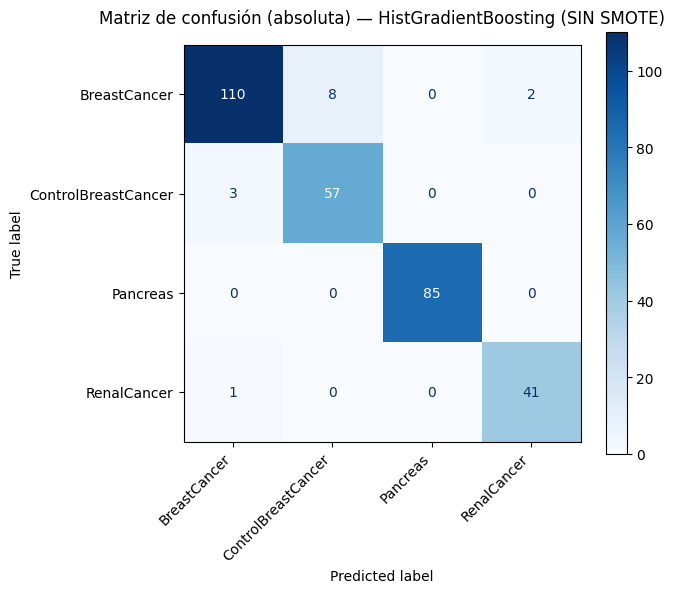

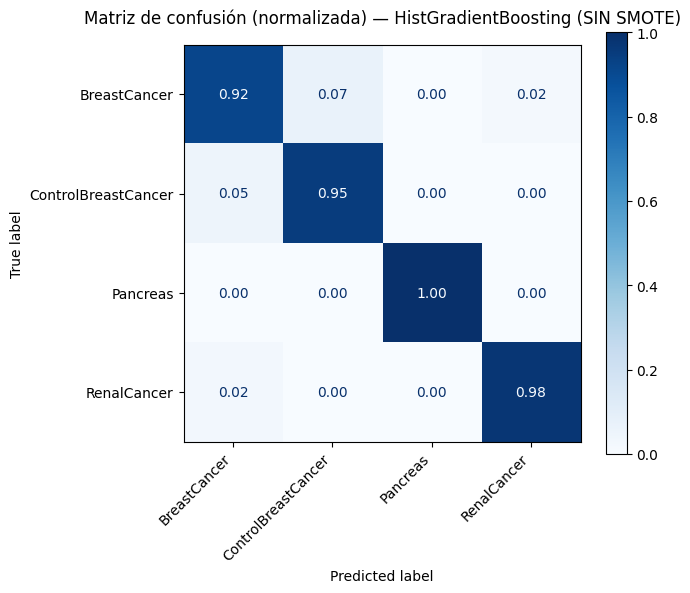

                     precision    recall        f1  soporte
BreastCancer          0.964912  0.916667  0.940171    120.0
ControlBreastCancer   0.876923  0.950000  0.912000     60.0
Pancreas              1.000000  1.000000  1.000000     85.0
RenalCancer           0.953488  0.976190  0.964706     42.0
macro_avg             0.948831  0.960714  0.954219      NaN
micro_avg             0.954397  0.954397  0.954397    307.0

=== OOF — HistGradientBoosting + SMOTE (4 clases, CON SMOTE) ===
[OOF] Accuracy: 0.9609 · AUC OvR (macro): 0.9940


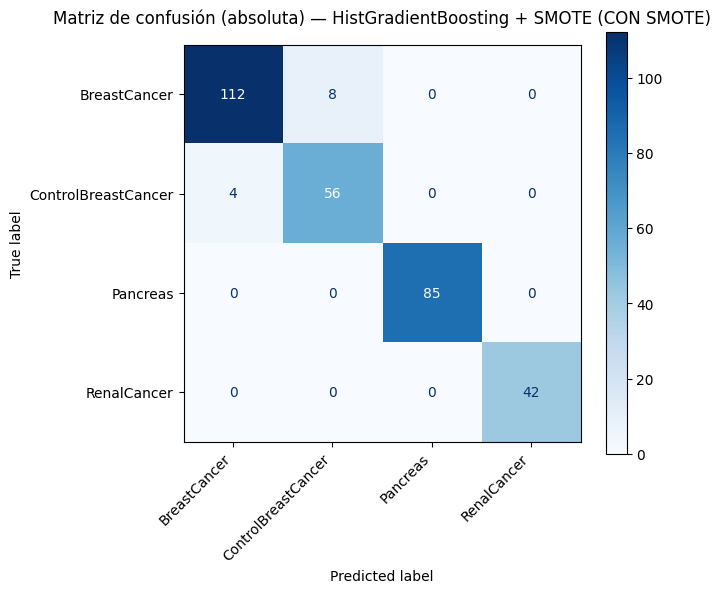

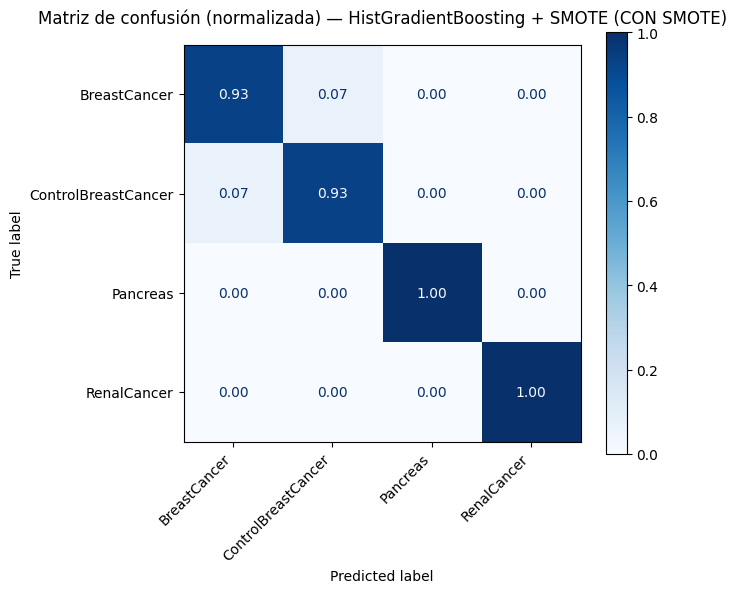

                     precision    recall        f1  soporte
BreastCancer          0.965517  0.933333  0.949153    120.0
ControlBreastCancer   0.875000  0.933333  0.903226     60.0
Pancreas              1.000000  1.000000  1.000000     85.0
RenalCancer           1.000000  1.000000  1.000000     42.0
macro_avg             0.960129  0.966667  0.963095      NaN
micro_avg             0.960912  0.960912  0.960912    307.0


In [192]:
# ==========================================================================
# Comparativa de clasificadores con 4 clases (SIN ComBat) + variante SMOTE
# ==========================================================================

RANDOM_STATE = 42

# Etiquetas 4 clases (fusiono PancreasCancer y ControlPancreasCancer)
y_4c = y_5c.replace({
    "PancreasCancer": "Pancreas",
    "ControlPancreasCancer": "Pancreas"
})

X_use = Xi.copy()
y_use = y_4c.reindex(X_use.index)

if X_use.isna().any().any():
    print("[AVISO] NaNs detectados en Xi; se imputan con mediana para evaluar.")
    X_eval = X_use.fillna(X_use.median())
else:
    X_eval = X_use

# Métricas (incluye AUC multiclase OvR macro)
scoring = {
    "accuracy": "accuracy",
    "macro_f1": make_scorer(f1_score, average="macro"),
    "macro_f1_safe": make_scorer(f1_score, average="macro", zero_division=0),
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "auc_ovr_macro": make_scorer(
        roc_auc_score, needs_proba=True, multi_class="ovr", average="macro"
    ),
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Definición de modelos
# Pipelines SIN SMOTE (uso class_weight='balanced')
def build_models_baseline():
    models = {
        "RandomForest": RandomForestClassifier(
            n_estimators=700, max_features="sqrt",
            class_weight="balanced",
            random_state=RANDOM_STATE, n_jobs=-1
        ),
        "HistGradientBoosting": HistGradientBoostingClassifier(
            class_weight="balanced",
            learning_rate=0.1, max_iter=300,
            random_state=RANDOM_STATE
        ),
        "LogisticRegression": SkPipeline(steps=[
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                multi_class="multinomial", solver="saga",
                penalty="l2", class_weight="balanced",
                max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
            ))
        ]),
        "LinearSVM": SkPipeline(steps=[
            ("scaler", StandardScaler()),
            ("svm_cal", CalibratedClassifierCV(
                estimator=LinearSVC(
                    class_weight="balanced",
                    C=1.0, max_iter=5000, random_state=RANDOM_STATE
                ),
                method="sigmoid", cv=3
            ))
        ]),
    }
    return models

# Pipelines CON SMOTE (sin class_weight para evitar doble compensación)
def build_models_smote():
    smote = SMOTE(
        sampling_strategy="auto",
        k_neighbors=5,
        random_state=RANDOM_STATE
    )
    models = {
        "RandomForest + SMOTE": ImbPipeline(steps=[
            ("smote", smote),
            ("clf", RandomForestClassifier(
                n_estimators=700, max_features="sqrt",
                class_weight=None,
                random_state=RANDOM_STATE, n_jobs=-1
            ))
        ]),
        "HistGradientBoosting + SMOTE": ImbPipeline(steps=[
            ("smote", smote),
            ("clf", HistGradientBoostingClassifier(
                class_weight=None,
                learning_rate=0.1, max_iter=300,
                random_state=RANDOM_STATE
            ))
        ]),
        "LogisticRegression + SMOTE": ImbPipeline(steps=[
            ("scaler", StandardScaler()),
            ("smote", smote),
            ("clf", LogisticRegression(
                multi_class="multinomial", solver="saga",
                penalty="l2", class_weight=None,
                max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
            ))
        ]),
        "LinearSVM + SMOTE": ImbPipeline(steps=[
            ("scaler", StandardScaler()),
            ("smote", smote),
            ("svm_cal", CalibratedClassifierCV(
                estimator=LinearSVC(
                    class_weight=None,
                    C=1.0, max_iter=5000, random_state=RANDOM_STATE
                ),
                method="sigmoid", cv=3
            ))
        ]),
    }
    return models

# Evaluación CV (dos variantes)
def eval_models(models_dict, X, y, tag="BASE"):
    rows = []
    per_model_results = {}
    print(f"\n=== Comparativa de clasificadores (4 clases, {tag}) · Medias CV (k=5) ===")

    for name, model in models_dict.items():
        res = cross_validate(
            model, X, y, cv=cv, scoring=scoring,
            n_jobs=-1, return_train_score=False
        )
        df = pd.DataFrame(res)
        df.loc["mean"] = df.mean(numeric_only=True)
        per_model_results[name] = df

        rows.append({
            "Modelo": name,
            "Accuracy": df.loc["mean", "test_accuracy"],
            "BalancedAcc": df.loc["mean", "test_balanced_acc"],
            "macro_F1": df.loc["mean", "test_macro_f1"],
            "macro_F1_safe": df.loc["mean", "test_macro_f1_safe"],
            "AUC_OvR_macro": df.loc["mean", "test_auc_ovr_macro"],
            "FitTime(s)": df.loc["mean", "fit_time"],
        })

    summary = pd.DataFrame(rows).sort_values("macro_F1_safe", ascending=False).reset_index(drop=True)
    print(summary)
    return summary, per_model_results

baseline_models = build_models_baseline()
smote_models = build_models_smote()

summary_base, res_base = eval_models(baseline_models, X_eval, y_use, tag="SIN SMOTE (class_weight)")
summary_smote, res_smote = eval_models(smote_models, X_eval, y_use, tag="CON SMOTE")

# OOF: matrices de confusión y métricas por clase
def oof_report(model_name, model, X, y, tag=""):
    print(f"\n=== OOF — {model_name} (4 clases, {tag}) ===")
    proba_oof = cross_val_predict(
        model, X, y, cv=cv, method="predict_proba", n_jobs=-1
    )

    # Ajuste final para obtener orden de clases
    model.fit(X, y)
    if hasattr(model, "classes_"):
        classes_ = model.classes_
    else:
        # Pipelines: buscar último estimador con 'classes_'
        classes_ = None
        if hasattr(model, "named_steps"):
            for step in model.named_steps.values():
                if hasattr(step, "classes_"):
                    classes_ = step.classes_
        if classes_ is None:
            classes_ = np.unique(y)

    pred_idx = np.argmax(proba_oof, axis=1)
    pred_labels = np.array([classes_[i] for i in pred_idx])

    acc_oof = accuracy_score(y, pred_labels)
    try:
        auc_ovr_macro_oof = roc_auc_score(y, proba_oof, multi_class="ovr", average="macro")
    except Exception:
        auc_ovr_macro_oof = np.nan
    print(f"[OOF] Accuracy: {acc_oof:.4f} · AUC OvR (macro): {auc_ovr_macro_oof:.4f}")

    cm = confusion_matrix(y, pred_labels, labels=classes_)
    cm_norm = confusion_matrix(y, pred_labels, labels=classes_, normalize="true")

    fig, ax = plt.subplots(figsize=(7,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_)
    disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
    ax.set_title(f"Matriz de confusión (absoluta) — {model_name} ({tag})", fontsize=12, pad=15)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(7,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes_)
    disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
    ax.set_title(f"Matriz de confusión (normalizada) — {model_name} ({tag})", fontsize=12, pad=15)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    prec, rec, f1, support = precision_recall_fscore_support(
        y, pred_labels, labels=classes_, zero_division=0
    )
    per_class = pd.DataFrame({
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "soporte": support
    }, index=classes_)
    per_class.loc["macro_avg"] = per_class.iloc[:, :3].mean()
    per_class.loc["micro_avg"] = [
        acc_oof, acc_oof,
        f1_score(y, pred_labels, average="micro"),
        support.sum()
    ]
    print(per_class)

# Ejemplos de OOF para comparar
oof_report("HistGradientBoosting", baseline_models["HistGradientBoosting"], X_eval, y_use, tag="SIN SMOTE")
oof_report("HistGradientBoosting + SMOTE", smote_models["HistGradientBoosting + SMOTE"], X_eval, y_use, tag="CON SMOTE")


[INFO] X_use (CON ComBat, 4 clases): (307, 135)
[INFO] Conteo de clases:
 label_5c
BreastCancer           120
Pancreas                85
ControlBreastCancer     60
RenalCancer             42
Name: count, dtype: int64

=== Comparativa de clasificadores (4 clases, CON ComBat) · Medias CV (k=5) ===
                 Modelo  Accuracy  BalancedAcc  macro_F1  macro_F1_safe  \
0  HistGradientBoosting  0.921735     0.890278  0.895640       0.895640   
1          RandomForest  0.872977     0.799306  0.812702       0.812702   
2             LinearSVM  0.625119     0.536560  0.565503       0.565503   
3    LogisticRegression  0.413908     0.404534  0.415984       0.415984   

   AUC_OvR_macro  FitTime(s)  
0            NaN    4.534632  
1            NaN    7.008286  
2            NaN    1.254482  
3            NaN    2.194292  

=== OOF — RandomForest (4 clases, CON ComBat) ===
[OOF] Accuracy: 0.8730 · AUC OvR (macro): 0.9865


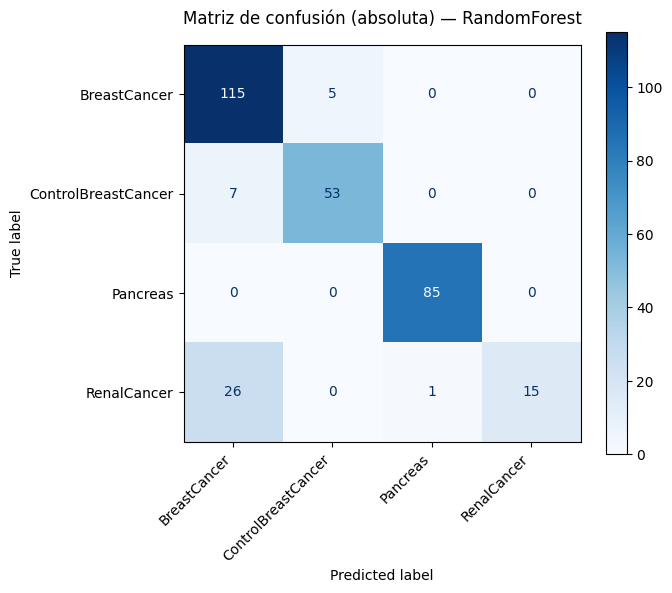

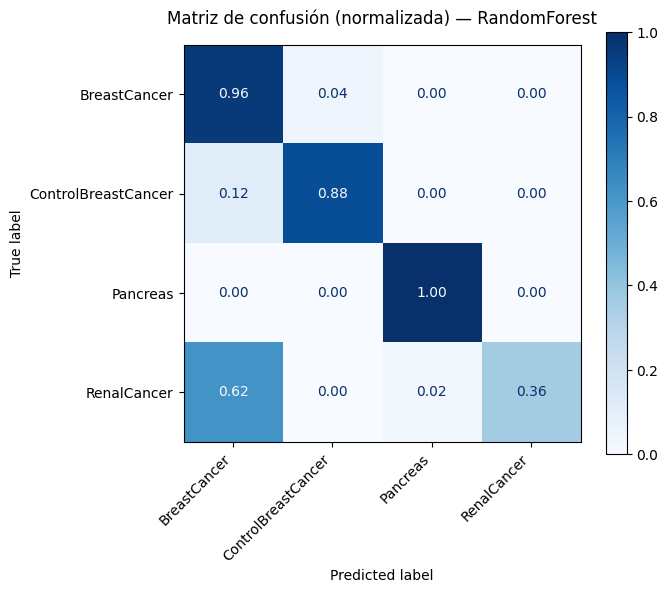

                     precision    recall        f1  soporte
BreastCancer          0.777027  0.958333  0.858209    120.0
ControlBreastCancer   0.913793  0.883333  0.898305     60.0
Pancreas              0.988372  1.000000  0.994152     85.0
RenalCancer           1.000000  0.357143  0.526316     42.0
macro_avg             0.919798  0.799702  0.819245      NaN
micro_avg             0.872964  0.872964  0.872964    307.0

=== OOF — HistGradientBoosting (4 clases, CON ComBat) ===
[OOF] Accuracy: 0.9218 · AUC OvR (macro): 0.9880


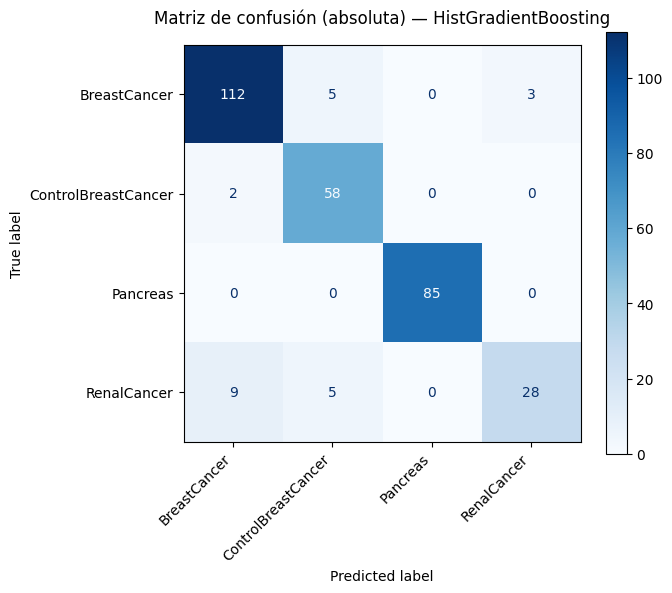

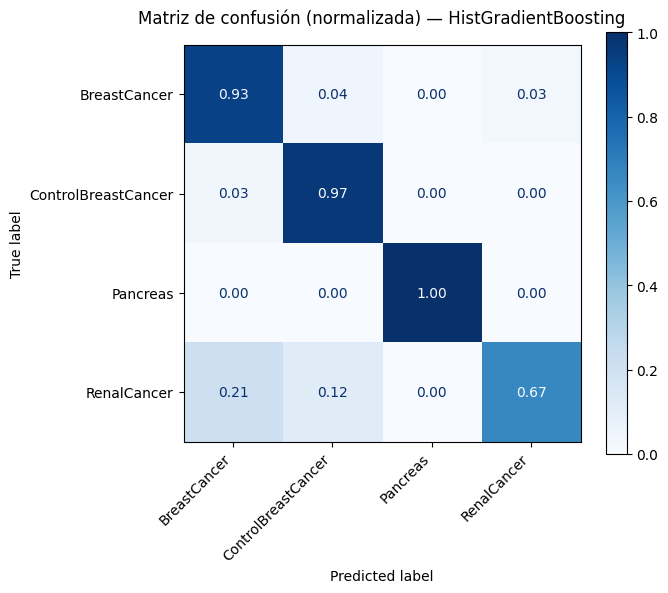

                     precision    recall        f1  soporte
BreastCancer          0.910569  0.933333  0.921811    120.0
ControlBreastCancer   0.852941  0.966667  0.906250     60.0
Pancreas              1.000000  1.000000  1.000000     85.0
RenalCancer           0.903226  0.666667  0.767123     42.0
macro_avg             0.916684  0.891667  0.898796      NaN
micro_avg             0.921824  0.921824  0.921824    307.0

=== OOF — LogisticRegression (4 clases, CON ComBat) ===


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[OOF] Accuracy: 0.4137 · AUC OvR (macro): 0.5779


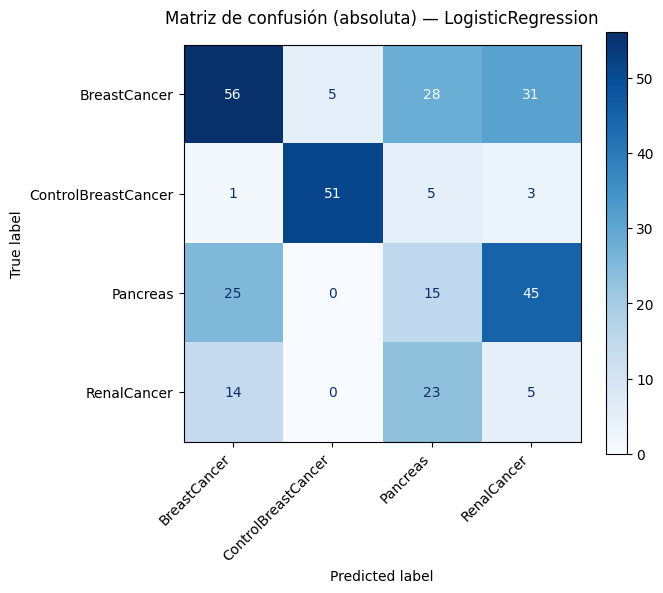

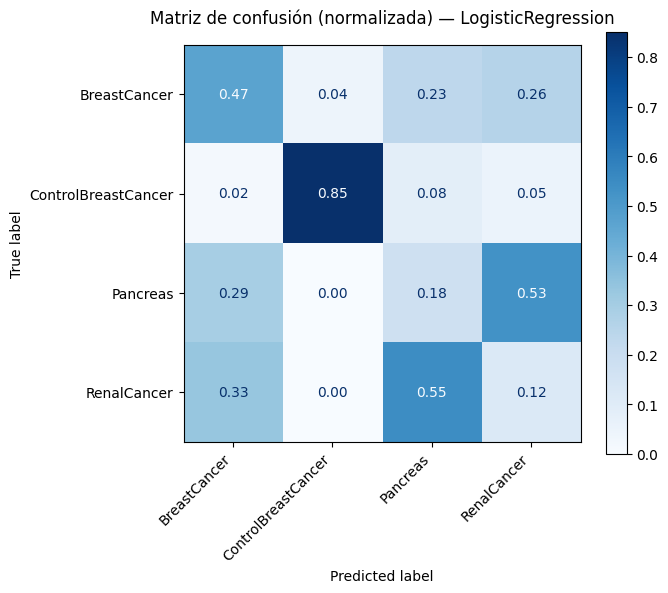

                     precision    recall        f1  soporte
BreastCancer          0.583333  0.466667  0.518519    120.0
ControlBreastCancer   0.910714  0.850000  0.879310     60.0
Pancreas              0.211268  0.176471  0.192308     85.0
RenalCancer           0.059524  0.119048  0.079365     42.0
macro_avg             0.441210  0.403046  0.417375      NaN
micro_avg             0.413681  0.413681  0.413681    307.0

=== OOF — LinearSVM (4 clases, CON ComBat) ===
[OOF] Accuracy: 0.6254 · AUC OvR (macro): 0.8464


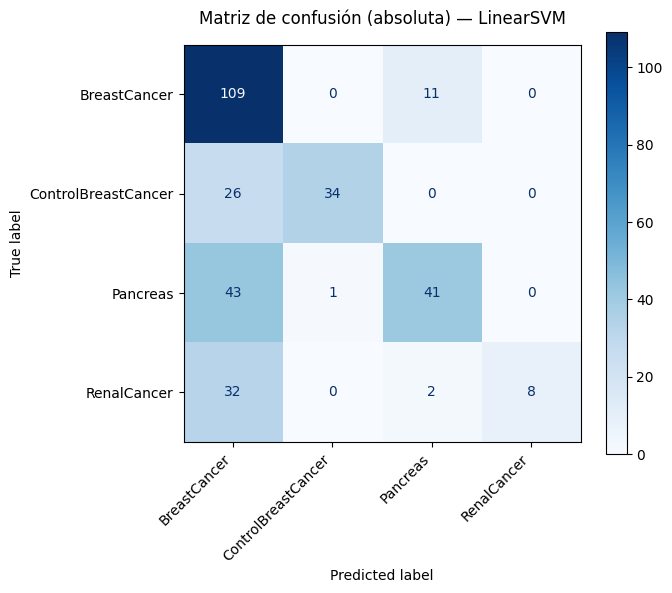

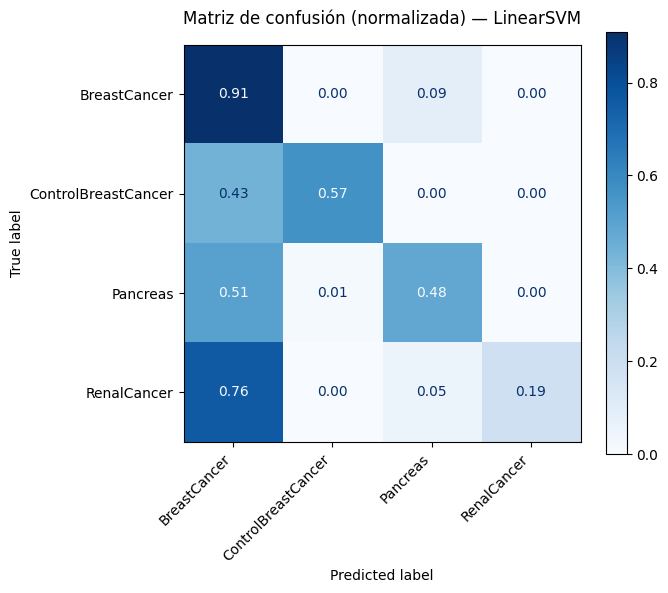

                     precision    recall        f1  soporte
BreastCancer          0.519048  0.908333  0.660606    120.0
ControlBreastCancer   0.971429  0.566667  0.715789     60.0
Pancreas              0.759259  0.482353  0.589928     85.0
RenalCancer           1.000000  0.190476  0.320000     42.0
macro_avg             0.812434  0.536957  0.571581      NaN
micro_avg             0.625407  0.625407  0.625407    307.0


In [193]:
# =========================================================
# Comparativa de clasificadores con 4 clases (CON ComBat)
# =========================================================

RANDOM_STATE = 42

# ============================================================
# Etiquetas de 4 clases (Pancreas fusionado)
# ============================================================
y_4c = y_5c.replace({
    "PancreasCancer": "Pancreas",
    "ControlPancreasCancer": "Pancreas"
})

X_use = Xc_scaled_df.copy()
y_use = y_4c.reindex(X_use.index)

print(f"[INFO] X_use (CON ComBat, 4 clases): {X_use.shape}")
print("[INFO] Conteo de clases:\n", y_use.value_counts())

if X_use.isna().any().any():
    print("[AVISO] NaNs detectados en Xc_scaled_df; se imputan con mediana para evaluar.")
    X_eval = X_use.fillna(X_use.median())
else:
    X_eval = X_use

# Definición de métricas
scoring = {
    "accuracy": "accuracy",
    "macro_f1": make_scorer(f1_score, average="macro"),
    "macro_f1_safe": make_scorer(f1_score, average="macro", zero_division=0),
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "auc_ovr_macro": make_scorer(
        roc_auc_score, needs_proba=True, multi_class="ovr", average="macro"
    ),
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Definición de modelos
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=700, max_features="sqrt",
        class_weight="balanced",
        random_state=RANDOM_STATE, n_jobs=-1
    ),
    "HistGradientBoosting": HistGradientBoostingClassifier(
        class_weight="balanced",
        learning_rate=0.1, max_iter=300,
        random_state=RANDOM_STATE
    ),
    "LogisticRegression": Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            multi_class="multinomial", solver="saga",
            penalty="l2", class_weight="balanced",
            max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
        ))
    ]),
    "LinearSVM": Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("svm_cal", CalibratedClassifierCV(
            estimator=LinearSVC(
                class_weight="balanced",
                C=1.0, max_iter=5000, random_state=RANDOM_STATE
            ),
            method="sigmoid", cv=3
        ))
    ]),
}

# Evaluación CV · resumen de métricas globales
rows = []
per_model_results_combat = {}

for name, model in models.items():
    res = cross_validate(
        model, X_eval, y_use,
        cv=cv, scoring=scoring,
        n_jobs=-1, return_train_score=False
    )
    df = pd.DataFrame(res)
    df.loc["mean"] = df.mean(numeric_only=True)
    per_model_results_combat[name] = df

    rows.append({
        "Modelo": name,
        "Accuracy": df.loc["mean", "test_accuracy"],
        "BalancedAcc": df.loc["mean", "test_balanced_acc"],
        "macro_F1": df.loc["mean", "test_macro_f1"],
        "macro_F1_safe": df.loc["mean", "test_macro_f1_safe"],
        "AUC_OvR_macro": df.loc["mean", "test_auc_ovr_macro"],
        "FitTime(s)": df.loc["mean", "fit_time"],
    })

summary_4c_combat = pd.DataFrame(rows).sort_values("macro_F1_safe", ascending=False).reset_index(drop=True)

print("\n=== Comparativa de clasificadores (4 clases, CON ComBat) · Medias CV (k=5) ===")
print(summary_4c_combat)

# OOF: matrices de confusión y métricas por clase
for name, model in models.items():
    print(f"\n=== OOF — {name} (4 clases, CON ComBat) ===")
    proba_oof = cross_val_predict(
        model, X_eval, y_use, cv=cv, method="predict_proba", n_jobs=-1
    )

    model.fit(X_eval, y_use)
    if isinstance(model, Pipeline):
        last_step = list(model.named_steps.values())[-1]
        classes_ = last_step.classes_
    else:
        classes_ = model.classes_

    pred_idx = np.argmax(proba_oof, axis=1)
    pred_labels = np.array([classes_[i] for i in pred_idx])

    acc_oof = accuracy_score(y_use, pred_labels)
    try:
        auc_ovr_macro_oof = roc_auc_score(y_use, proba_oof, multi_class="ovr", average="macro")
    except Exception:
        auc_ovr_macro_oof = np.nan
    print(f"[OOF] Accuracy: {acc_oof:.4f} · AUC OvR (macro): {auc_ovr_macro_oof:.4f}")

    cm = confusion_matrix(y_use, pred_labels, labels=classes_)
    cm_norm = confusion_matrix(y_use, pred_labels, labels=classes_, normalize="true")

    fig, ax = plt.subplots(figsize=(7,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_)
    disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
    ax.set_title(f"Matriz de confusión (absoluta) — {name}", fontsize=12, pad=15)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(7,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes_)
    disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f")
    ax.set_title(f"Matriz de confusión (normalizada) — {name}", fontsize=12, pad=15)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    prec, rec, f1, support = precision_recall_fscore_support(
        y_use, pred_labels, labels=classes_, zero_division=0
    )
    per_class = pd.DataFrame({
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "soporte": support
    }, index=classes_)
    per_class.loc["macro_avg"] = per_class.iloc[:, :3].mean()
    per_class.loc["micro_avg"] = [
        acc_oof, acc_oof,
        f1_score(y_use, pred_labels, average="micro"),
        support.sum()
    ]
    print(per_class)


Una vez tengo el mejor modelo y ya está entrenado (LogisticRegression multinomial SIN ComBat), quiero ver qué miARNs han pesado más en la predicción de cada muestra.

Esto se puede hacer de dos formas:
 - **Coeficientes del modelo (globales)**: cada coeficiente de la regresión logística nos dice cuánto contribuye un miARN a la probabilidad de cada clase.

Es un mapa general, no específico de cada paciente.

- **Explicaciones locales (muestra a muestra)**: con librerías como SHAP o con las propias decision_function de LR, se puede ver qué features tiraron hacia arriba o abajo en cada decisión concreta.

### **Importancia de miARNs por clase en (LogisticRegression, SIN ComBat, utilizando SHAP)**

En este bloque se busca interpretar el comportamiento interno del modelo de regresión logística multinomial aplicado al conjunto de datos de expresión de microARNs, tras la fusión de las clases relacionadas con páncreas en una única categoría (Pancreas).

El objetivo principal es **analizar las contribuciones de cada miRNA a la predicción de cada clase**, tanto a nivel global (identificando los miRNA más influyentes por tipo de diagnóstico) como a nivel local (explicando qué miRNA concretos impulsan la predicción de una muestra individual).

Para ello:
- Se entrena un modelo de **Logistic Regression multiclase con regularización L2 y pesos balanceados**, tras estandarizar las variables de entrada.
- A partir de los coeficientes del modelo y las variables estandarizadas, se calcula una **matriz de contribuciones** (Xz * coef) que refleja cuánto aporta cada miRNA a la decisión del clasificador en cada muestra y clase.
- Se obtiene un **ranking de importancia promedio por clase**, basado en la magnitud media de las contribuciones absolutas para las muestras predichas como dicha clase. Este ranking permite identificar los miRNA con mayor peso discriminativo para cada diagnóstico.

Finalmente, se implementa una **función de explicación local** que, dada una muestra, muestra los miRNA que más influyen (positiva o negativamente) en su predicción.

En resumen, este análisis permite comprender el razonamiento del modelo, tanto en términos de las variables más relevantes globalmente por clase, como de las que determinan la clasificación individual de cada paciente. Es una aproximación interpretativa previa al uso de métodos más complejos como SHAP o LIME, pero basada únicamente en los coeficientes lineales del modelo.

In [195]:
# ================================================================================
# Importancias por clase y por muestra con LR multinomial (SIN SHAP)
# ================================================================================

RANDOM_STATE = 42

# Etiquetas a 4 clases
y_4c = y_5c.replace({
    "PancreasCancer": "Pancreas",
    "ControlPancreasCancer": "Pancreas"
})

X_use = Xi.copy()
y_use = y_4c.reindex(X_use.index)

# Imputación defensiva si hubiera NaNs residuales --> (no hay pero por si acaso)
if X_use.isna().any().any():
    X_use = X_use.fillna(X_use.median())

# Entreno Logistic Regression (que es la que mejor rendimiento ha dado de todas)
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        multi_class="multinomial",
        solver="saga",
        penalty="l2",
        class_weight="balanced",
        max_iter=5000,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])
pipe.fit(X_use, y_use)

scaler = pipe.named_steps["scaler"]
lr = pipe.named_steps["lr"]
classes = lr.classes_
coefs = lr.coef_               # shape: (n_classes, n_features)
intercepts = lr.intercept_     # shape: (n_classes,)
Xz = scaler.transform(X_use)   # estandarizado
feature_names = X_use.columns

# Contribuciones: matriz por clase (n_samples x n_features)
# contribs[k] = Xz * coefs[k] (broadcasting por columnas)
contribs_by_class = {cls: Xz * coefs[i, :] for i, cls in enumerate(classes)}    # dict: clase -> (n_samples, n_features)

# Predicciones para filtrar por clase predicha
y_pred = pipe.predict(X_use)

# RANKING POR CLASE --> (media de |contribución| entre muestras predichas como esa clase)
rankings_por_clase = {}
for i, cls in enumerate(classes):
    idx = (y_pred == cls)
    if idx.sum() == 0:
        print(f"[AVISO] No hay muestras predichas como {cls}; se omite ranking.")
        continue
    abs_mean_contrib = np.mean(np.abs(contribs_by_class[cls][idx, :]), axis=0)  # (n_features,)
    df_rank = pd.DataFrame({
        "miRNA": feature_names,
        "mean_abs_contrib": abs_mean_contrib
    }).sort_values("mean_abs_contrib", ascending=False).reset_index(drop=True)
    rankings_por_clase[cls] = df_rank

    print(f"\n=== Top-20 miRNA por importancia (clase predicha: {cls}) ===")
    print(df_rank.head(20))

# Explicación local (por muestra): top miRNA que empujan su clase predicha
# Devuelve un DataFrame con los miRNA que más contribuyen (±) a la clase predicha de 'sample_id'.
def explicar_muestra(sample_id, top=15):
    if sample_id not in X_use.index:
        raise ValueError(f"{sample_id} no está en el índice de X_use.")
    i = X_use.index.get_loc(sample_id)

    cls_hat = y_pred[i]
    k = np.where(classes == cls_hat)[0][0]

    # vector de contribuciones para esa muestra y clase
    contrib_i = contribs_by_class[cls_hat][i, :]  # shape: (n_features,)
    df_local = pd.DataFrame({
        "miRNA": feature_names,
        "contrib": contrib_i
    }).sort_values("contrib", key=np.abs, ascending=False).head(top)

    # signo: positivo empuja hacia la clase predicha; negativo la aleja
    return cls_hat, df_local

# Ejemplo: explicar la primera muestra predicha como Pancreas --> He probado con todos, solamente es ilustrativo, con lo que me quiero quedar es con los otros tops
ejemplos_pancreas = X_use.index[y_pred == "Pancreas"]
if len(ejemplos_pancreas) > 0:
    sample_id = ejemplos_pancreas[0]
    clase_predicha, df_local = explicar_muestra(sample_id, top=15)
    print(f"\n=== Explicación local · muestra {sample_id} · clase predicha: {clase_predicha} ===")
    print(df_local)
else:
    print("\n[INFO] No hay muestras predichas como Pancreas en este conjunto.")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Top-20 miRNA por importancia (clase predicha: BreastCancer) ===
          miRNA  mean_abs_contrib
0      mir-4492          0.556639
1       mir-484          0.479921
2     mir-21-5p          0.463654
3   mir-151a-3p          0.416680
4   mir-106b-5p          0.287433
5    mir-140-3p          0.287270
6    mir-660-5p          0.286733
7    mir-29a-3p          0.261265
8    mir-20a-5p          0.251819
9       mir-543          0.250322
10   mir-27a-3p          0.245183
11   mir-34a-5p          0.240422
12    mir-98-3p          0.225141
13    mir-98-5p          0.214832
14  mir-378a-5p          0.198980
15   mir-363-3p          0.194286
16   mir-497-5p          0.190031
17   mir-377-3p          0.181395
18    mir-32-5p          0.181110
19   mir-10b-5p          0.176272

=== Top-20 miRNA por importancia (clase predicha: ControlBreastCancer) ===
          miRNA  mean_abs_contrib
0    mir-29a-3p          0.345588
1      mir-4492          0.257721
2   mir-151a-3p          0.249886
3    

**Interpretabilidad con SHAP en Logistic Regression multinomial (4 clases, SIN ComBat)**

---
En este bloque se aplica el **método SHAP (SHapley Additive exPlanations)** para interpretar el comportamiento del modelo de regresión logística multinomial previamente entrenado sobre los datos originales sin corrección por batch effect (SIN ComBat), tras fusionar las clases asociadas al páncreas en una única categoría Pancreas.

El objetivo es **cuantificar y visualizar la contribución individual de cada miRNA en las decisiones del modelo**, tanto a nivel global (qué miRNA son los más influyentes por clase) como local (qué miRNA concretos impulsan la predicción de una muestra específica).

El proceso se desarrolla en las siguientes fases:
- Entrenamiento del modelo: se ajusta una **regresión logística multinomial con regularización L2 y pesos balanceados**, precedida por una estandarización de las variables de entrada.

- **Cálculo de valores SHAP**: se utiliza el **método LinearExplainer**, apropiado para modelos lineales, para obtener las contribuciones de cada variable en cada muestra y para cada clase. Los valores SHAP representan el cambio esperado en la probabilidad de pertenencia a una clase al modificar el valor de un miRNA respecto al promedio.

- **Análisis global por clase**: se calcula el **valor medio absoluto de SHAP (|SHAP|) entre las muestras predichas como cada clase**, permitiendo obtener un ranking de miRNA más influyentes por diagnóstico.

- **Análisis local (por muestra)**: se selecciona una muestra de ejemplo (por defecto, una predicha como *Pancreas*) y se listan los miRNA que más contribuyen positiva o negativamente a su clasificación individual.

- **Visualización**: se generan gráficos summary plot de SHAP, tanto globales (sumando la influencia total de cada miRNA en todas las clases) como específicos de una clase, lo que facilita la interpretación visual de la importancia y dirección de cada variable.

Este análisis proporciona una interpretación robusta y cuantitativa del modelo, basada en los fundamentos teóricos de los valores de Shapley. Permite identificar los miRNA con mayor impacto predictivo y entender cómo influyen sus valores en las predicciones, reforzando la transparencia del modelo y su utilidad para la investigación biomédica.

In [197]:
# ===========================================================================
# SHAP por clase y por muestra (LogReg multinomial, 4 clases, SIN ComBat)
# ===========================================================================

RANDOM_STATE = 42

y_4c = y_5c.replace({
    "PancreasCancer": "Pancreas",
    "ControlPancreasCancer": "Pancreas"
})

X_use = Xi.copy()
y_use = y_4c.reindex(X_use.index)

feature_names = X_use.columns

# Entreno el mejor modelo anterior: LR multinomial + escalado
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        multi_class="multinomial",
        solver="saga",
        penalty="l2",
        class_weight="balanced",
        max_iter=5000,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])
pipe.fit(X_use, y_use)

scaler = pipe.named_steps["scaler"]
lr = pipe.named_steps["lr"]
classes = lr.classes_

# Transformo los datos (SHAP debe ver lo mismo que ve el clasificador)
Xz = pd.DataFrame(scaler.transform(X_use), index=X_use.index, columns=feature_names)

# SHAP (LinearExplainer para modelos lineales)
# Uso Xz (estandarizado) como background y para explicar
expl = shap.LinearExplainer(lr, Xz, feature_perturbation="interventional")
shap_vals = expl.shap_values(Xz)

# Normalizo a una lista de matrices [(n_samples, n_features) por clase]
def normalize_shap_to_list(shap_values, n_classes):
    if isinstance(shap_values, list):
        assert len(shap_values) == n_classes, "SHAP devolvió lista con nº de clases inesperado."
        return [np.asarray(m) for m in shap_values]
    arr = np.asarray(shap_values)
    if arr.ndim == 3 and arr.shape[0] == n_classes:
        return [arr[k, :, :] for k in range(n_classes)]
    if arr.ndim == 3 and arr.shape[2] == n_classes:
        return [arr[:, :, k] for k in range(n_classes)]
    if arr.ndim == 2 and n_classes == 2:
        return [arr, -arr]
    raise ValueError(f"Forma SHAP no reconocida: {arr.shape}")

shap_list = normalize_shap_to_list(shap_vals, len(classes))  # lista de (n_samples, n_features)

# Predicciones para filtrar por clase predicha
y_pred = pipe.predict(X_use)

# Ranking de miARNs por clase (media de |SHAP| en muestras predichas como esa clase)
rankings_por_clase = {}
for i, cls in enumerate(classes):
    idx = (y_pred == cls)
    if idx.sum() == 0:
        print(f"[AVISO] No hay muestras predichas como {cls}; se omite.")
        continue
    # shap_list[i] -> (n_samples, n_features)
    mean_abs = np.mean(np.abs(shap_list[i][idx, :]), axis=0)  # (n_features,)
    df_rank = pd.DataFrame({
        "miRNA": feature_names,
        "mean_abs_SHAP": mean_abs
    }).sort_values("mean_abs_SHAP", ascending=False).reset_index(drop=True)
    rankings_por_clase[cls] = df_rank
    print(f"\n=== Top-20 miARNs (|SHAP| medio) · clase predicha: {cls} ===")
    print(df_rank.head(20))

# Explicación local por muestra (top miARNs que empujan la clase predicha)
def explicar_muestra_SHAP(sample_id, top=15):
    """Devuelve (clase_predicha, DataFrame con miRNA y SHAP de mayor impacto para esa clase)."""
    if sample_id not in X_use.index:
        raise ValueError(f"{sample_id} no está en el índice.")
    i = X_use.index.get_loc(sample_id)
    cls_hat = y_pred[i]
    k = np.where(classes == cls_hat)[0][0]
    shap_i = shap_list[k][i, :]  # contribuciones SHAP para la clase predicha
    df_local = pd.DataFrame({
        "miRNA": feature_names,
        "SHAP": shap_i,
        "z_value": Xz.iloc[i, :].values  # valor estandarizado de la feature (útil para interpretar signo)
    }).sort_values("SHAP", key=np.abs, ascending=False).head(top)
    return cls_hat, df_local

# Ejemplo: primera muestra predicha como Pancreas (si existe)
ejemplos_pancreas = X_use.index[y_pred == "Pancreas"]
if len(ejemplos_pancreas) > 0:
    eg = ejemplos_pancreas[0]
    clase_pred, df_local = explicar_muestra_SHAP(eg, top=15)
    print(f"\n=== Explicación local (SHAP) · muestra {eg} · clase predicha: {clase_pred} ===")
    print(df_local)
else:
    print("\n[INFO] No hay muestras predichas como 'Pancreas' en este conjunto.")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Top-20 miARNs (|SHAP| medio) · clase predicha: BreastCancer ===
          miRNA  mean_abs_SHAP
0      mir-4492       0.542778
1       mir-484       0.438046
2   mir-151a-3p       0.421911
3     mir-21-5p       0.421638
4    mir-140-3p       0.287444
5   mir-106b-5p       0.283930
6    mir-29a-3p       0.260076
7    mir-20a-5p       0.257884
8    mir-660-5p       0.250551
9    mir-34a-5p       0.239072
10      mir-543       0.227787
11   mir-27a-3p       0.223141
12    mir-98-5p       0.203861
13   mir-363-3p       0.200598
14    mir-98-3p       0.199683
15   mir-497-5p       0.196285
16  mir-378a-5p       0.186094
17    mir-32-5p       0.184644
18   mir-7-1-3p       0.178290
19   mir-10b-5p       0.174451

=== Top-20 miARNs (|SHAP| medio) · clase predicha: ControlBreastCancer ===
          miRNA  mean_abs_SHAP
0    mir-29a-3p       0.332311
1      mir-4492       0.263288
2    mir-7-1-3p       0.259876
3   mir-151a-3p       0.251789
4    mir-29c-3p       0.246485
5   mir-106b-3p   

/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
